In [50]:
import pandas as pd
import numpy as np
import bitfinex
import datetime
import time
import matplotlib.pyplot as plt
import talib
from collections import Counter
from statistics import mode
import talib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import utils
import math
from sklearn.metrics import mean_squared_error
import numpy
from collections import Counter
from itertools import compress
import math as m
import random
import plotly.graph_objects as go
from datetime import timedelta
from datetime import datetime as dtime
import os

In [51]:
%run ./functions.ipynb
%run ./utils.ipynb

No keys, only access to public API functions


In [52]:
# df_large = pd.read_csv('btcusd.csv')
# df_large = df_large.rename(columns={'time': 'Date'})
# df_large.Date = pd.to_datetime(df_large.Date,unit='ms')

In [53]:
#df_large = pd.read_csv('BTC2015_2021_15m.csv')

In [54]:
fixer1 = pd.read_csv('Dataset/BTCUSD_1min.csv')
fixer1.Date = fixer1.Date.apply(lambda x: dtime.strptime(x, '%Y-%m-%d %H:%M:%S'))
fixer1 = fixer1.drop(labels=['Unix Timestamp','Symbol'],axis=1)
fixer1 = fixer1.sort_values('Date',ascending=True)
fixer1 = fixer1.reset_index(drop=True)

In [55]:
#Set parameter

#dataset
pair = 'BTCUSD'
period = '15m'
limit = 10000
start_year = 2019
stop_year = 2021
threshold_significant_change = 0.99

#signal
    #set parameter and generate
    #detect_size = Size of checking per round
    #trigger = confident threshold that count as a buy/sell spot
detect_size = 15
trigger = 0.55
spread_size = 0
rsi_filter = False
rsi_buy = 0.4
rsi_sell = 0.6

get_dataset = True
fix_dataset = True
save_dataset = False
transform_to_array = True

#Set File Path
dir_folder = 'C:/Users/User/Desktop/Deep_Learning/Live_Trading/New_Dataset/'
dir_signal = 'C:/Users/User/Desktop/Deep_Learning/Live_Trading/New_Dataset/Signaled/'
dir_completed = 'C:/Users/User/Desktop/Deep_Learning/Live_Trading/New_Dataset/Completed/'
dir_masked = 'C:/Users/User/Desktop/Deep_Learning/Live_Trading/New_Dataset/Completed/masked'

#dataset name directory
df_signal_name = str(detect_size)+'_'+str(int(trigger*100))+'_'+pair+'_'+period+'_'+str(start_year)+'_'+str(stop_year)+'_t'+\
                        str(threshold_significant_change)+'_'+'spread'+'_'+str(spread_size)+'.csv'
df_signal_name_for_dir = str(detect_size)+'_'+str(int(trigger*100))+'_'+pair+'_'+period+'_'+str(start_year)+'_'+str(stop_year)+'_t'+\
                        str(threshold_significant_change)+'_'+'spread'+'_'+str(spread_size)

print(f'Dataset name = {df_signal_name}')


#divider
mask_threshold = 0.9
name_masked = df_signal_name_for_dir+'_masked'+str(mask_threshold)
name = df_signal_name_for_dir+'_masked'+str(mask_threshold)+'.csv'
directory_masked = os.path.join(dir_masked, name)


#read/save directory
df_large_directory = os.path.join(dir_completed, df_signal_name)


if period == '1D':
    interval = 24*60
elif period == '4h':
    interval = 4*60
elif period == '1h':
    interval = 1*60
elif period == '15m':
    interval = 15
elif period == '5m':
    interval = 5
elif period == '1m':
    interval = 1
else:
    print('Invalid period input!')
    interval = 0

Dataset name = 15_55_BTCUSD_15m_2019_2021_t0.99_spread_0.csv


In [56]:
if get_dataset:
    df_large = getLargeDataset(pair,period,start_year,stop_year,limit)
    if fix_dataset:
        df_large = fixDataset(df_large,interval,[fixer1],True)
        df_large = getSignificantChange(df_large,threshold_significant_change,False)
        df_large = getPercentChange_tf15m(df_large)
        df_large = getRSI(df_large,14,'Close')
        df_signal = generateBuySellPoint(df_large,detect_size,trigger,spread_size,rsi_filter=rsi_filter\
                                        ,rsi_buy=rsi_buy,rsi_sell=rsi_sell)
        #df_candle = recognize_candlestick(df_signal)
        #df_candle = df_candle.drop(labels=candle_names,axis=1)
        #df_candle = pd.concat([df_candle,pd.get_dummies(df_candle.candlestick_pattern)],axis=1)
        df_candle = df_signal
        print(df_candle)
        testProfit2(df_candle,1000,0,'Signal',0,len(df_candle),\
                 False,calculate_fee=True,has_confident_column=False)
        df_candle = eliminateLoseSpot(df_candle,'Actual_act','Signal','Index_Buy')
        testProfit2(df_candle,1000,0,'Signal',0,len(df_candle),\
                 False,calculate_fee=True,has_confident_column=False)
        df_ema = getEMA50_200(df_candle,'Close')
        print(df_ema.keys())
        df_cleaned,df_with_date = getCleanedDataset(df_ema)
        if period == '1D':
            t = datetime.time(hour=0, minute=0)
            df_cleaned.Date = df_cleaned.Date.apply(lambda x: str(datetime.datetime.combine(x, t)))
        df_to_csv = scaledDataset(df_cleaned)
        df_scaled = df_to_array(df_to_csv)
        
        
    if save_dataset:
        df_to_csv.to_csv(df_large_directory,index=False)

Dataset size = 90224
Proper size = 90528
Number of missing data : 305
Fixed with fixer 1 : Missing data is 137
Filled missing : Missing data is 0
Done
Time period = 15 minutes
Done
                     Date     Open    Close     High      Low      Volume  \
0     2019-01-01 20:30:00   3878.7   3877.7   3886.6   3873.4  266.314333   
1     2019-01-01 20:45:00   3878.3   3888.8   3890.0   3874.6  201.417850   
2     2019-01-01 21:00:00   3889.8   3879.2   3905.6   3868.4  515.201995   
3     2019-01-01 21:15:00   3877.6   3880.7   3884.0   3872.0   66.486732   
4     2019-01-01 21:30:00   3882.5   3870.1   3887.7   3864.0  328.586696   
...                   ...      ...      ...      ...      ...         ...   
90317 2021-07-30 15:45:00  39061.0  39079.0  39079.0  39026.0   10.926555   
90318 2021-07-30 16:00:00  39079.0  38963.0  39079.0  38963.0   17.414400   
90319 2021-07-30 16:15:00  38963.0  39004.0  39188.0  38860.0   49.462712   
90320 2021-07-30 16:30:00  39010.0  38996.0  3905

I sell 0.29181552092815805 BTC and get profit 1.4801439686511912 USD at price 4118.5 USD at 2019-01-09 01:45:00
Fee : 1.2018422229426189 USD
I buy 0.29004032166649607 BTC with 1200.6403807196764 USD at price 4135.4241143 USD at 2019-01-09 08:00:00
Fee : 1.2006403807196764 USD
I sell 0.29004032166649607 BTC and get profit -6.550496269499263 USD at price 4121.1 USD at 2019-01-09 08:15:00
Fee : 1.195285169619797 USD
I buy 0.29214013042532433 BTC with 1194.0898844501771 USD at price 4083.3 USD at 2019-01-09 14:45:00
Fee : 1.194089884450177 USD
I sell 0.29214013042532433 BTC and get profit -5.88740817193252 USD at price 4071.30600789 USD at 2019-01-09 16:00:00
Fee : 1.189391868146391 USD
I buy 0.29137765079335415 BTC with 1188.2024762782446 USD at price 4073.8 USD at 2019-01-09 17:00:00
Fee : 1.1882024762782446 USD
I sell 0.29137765079335415 BTC and get profit 0.7685149998590077 USD at price 4084.6 USD at 2019-01-09 20:15:00
Fee : 1.1901611524305342 USD
I buy 0.29010625022270603 BTC with 11

I buy 0.33131653593210625 BTC with 1213.8323538653742 USD at price 3660.0 USD at 2019-01-18 19:30:00
Fee : 1.2138323538653741 USD
I sell 0.33131653593210625 BTC and get profit 3.1341008104789125 USD at price 3676.8 USD at 2019-01-18 23:15:00
Fee : 1.2181846393151685 USD
I buy 0.3282792807207369 BTC with 1216.9664546758531 USD at price 3703.4 USD at 2019-01-19 06:45:00
Fee : 1.2169664546758532 USD
I sell 0.3282792807207369 BTC and get profit 0.3548675693430141 USD at price 3711.9 USD at 2019-01-19 10:00:00
Fee : 1.2185398621073034 USD
I buy 0.32083790653307065 BTC with 1217.3213222451961 USD at price 3790.4 USD at 2019-01-19 14:45:00
Fee : 1.2173213222451962 USD
I sell 0.32083790653307065 BTC and get profit -0.8133999700405639 USD at price 3795.45441211 USD at 2019-01-19 18:00:00
Fee : 1.2177256479230787 USD
I buy 0.3198036723533769 BTC with 1216.5079222751556 USD at price 3800.11713252 USD at 2019-01-19 18:15:00
Fee : 1.2165079222751556 USD
I sell 0.3198036723533769 BTC and get profit 

I sell 0.35989957619856444 BTC and get profit 4.4044246785240375 USD at price 3488.9 USD at 2019-01-29 20:15:00
Fee : 1.2556536313991715 USD
I buy 0.3612509959324295 BTC with 1254.3979777677723 USD at price 3468.9 USD at 2019-01-30 00:15:00
Fee : 1.2543979777677723 USD
I sell 0.3612509959324295 BTC and get profit 12.000226188889428 USD at price 3509.1 USD at 2019-01-30 05:45:00
Fee : 1.2676658698264882 USD
I buy 0.36166256131977503 BTC with 1266.3982039566617 USD at price 3498.1 USD at 2019-01-30 07:15:00
Fee : 1.2663982039566617 USD
I sell 0.36166256131977503 BTC and get profit 9.355269559443741 USD at price 3531.0 USD at 2019-01-30 13:30:00
Fee : 1.2770305040201255 USD
I buy 0.36165656073853275 BTC with 1275.7534735161055 USD at price 3524.0 USD at 2019-01-30 14:15:00
Fee : 1.2757534735161056 USD
I sell 0.36165656073853275 BTC and get profit 1.7853076565750143 USD at price 3536.0 USD at 2019-01-30 18:45:00
Fee : 1.2788175987714518 USD
I buy 0.36203199751179815 BTC with 1277.538781172

I sell 0.3872408625900485 BTC and get profit 7.619506069903991 USD at price 3723.5 USD at 2019-02-10 00:15:00
Fee : 1.4418913518540455 USD
I buy 0.387873048798299 BTC with 1440.4494605021914 USD at price 3710.0 USD at 2019-02-10 01:00:00
Fee : 1.4404494605021914 USD
I sell 0.387873048798299 BTC and get profit -8.304250932036894 USD at price 3696.0 USD at 2019-02-10 11:00:00
Fee : 1.4335787883585132 USD
I buy 0.389288491608779 BTC with 1432.1452095701545 USD at price 3675.2 USD at 2019-02-10 14:45:00
Fee : 1.4321452095701546 USD
I sell 0.389288491608779 BTC and get profit 6.198493158699648 USD at price 3698.5 USD at 2019-02-10 16:45:00
Fee : 1.4397834862150691 USD
I buy 0.3874818222365393 BTC with 1438.3437027288542 USD at price 3708.31682047 USD at 2019-02-11 01:00:00
Fee : 1.4383437027288541 USD
I sell 0.3874818222365393 BTC and get profit -7.488182821425198 USD at price 3696.4 USD at 2019-02-11 07:45:00
Fee : 1.432287807715144 USD
I buy 0.387903572425379 BTC with 1430.855519907429 US

I buy 0.4090662892768055 BTC with 1648.3856397524605 USD at price 4025.6 USD at 2019-02-21 01:45:00
Fee : 1.6483856397524606 USD
I sell 0.4090662892768055 BTC and get profit 8.760265184267155 USD at price 4055.1 USD at 2019-02-21 05:45:00
Fee : 1.658804709646374 USD
I buy 0.4136136812071933 BTC with 1657.1459049367277 USD at price 4002.5 USD at 2019-02-21 11:00:00
Fee : 1.6571459049367276 USD
I sell 0.4136136812071933 BTC and get profit 1.4804861193329089 USD at price 4014.1 USD at 2019-02-21 13:45:00
Fee : 1.6602866777337946 USD
I buy 0.4139004732757986 BTC with 1658.6263910560606 USD at price 4003.3 USD at 2019-02-21 16:00:00
Fee : 1.6586263910560606 USD
I sell 0.4139004732757986 BTC and get profit -4.556053874128565 USD at price 4000.3 USD at 2019-02-21 21:15:00
Fee : 1.6557260632451771 USD
I buy 0.4134244706759614 BTC with 1654.070337181932 USD at price 3996.9 USD at 2019-02-21 22:45:00
Fee : 1.654070337181932 USD
I sell 0.4134244706759614 BTC and get profit 8.257822689721252 USD a

I sell 0.4762813502294372 BTC and get profit -5.282865213496734 USD at price 3891.0 USD at 2019-03-03 18:30:00
Fee : 1.8532107337427401 USD
I buy 0.4755235338184244 BTC with 1851.3575230089973 USD at price 3889.41037394 USD at 2019-03-03 19:15:00
Fee : 1.8513575230089974 USD
I sell 0.4755235338184244 BTC and get profit 2.327317922563452 USD at price 3902.1 USD at 2019-03-04 00:45:00
Fee : 1.8555403813128737 USD
I buy 0.48498838647844045 BTC with 1853.6848409315608 USD at price 3818.3 USD at 2019-03-04 06:00:00
Fee : 1.8536848409315607 USD
I sell 0.48498838647844045 BTC and get profit 1.3817696829435135 USD at price 3828.8 USD at 2019-03-04 07:15:00
Fee : 1.856923534148653 USD
I buy 0.4896070233293413 BTC with 1855.0666106145043 USD at price 3785.1 USD at 2019-03-04 10:30:00
Fee : 1.8550666106145044 USD
I sell 0.4896070233293413 BTC and get profit 10.92502356378418 USD at price 3815.01776868 USD at 2019-03-04 17:30:00
Fee : 1.8678594936719604 USD
I buy 0.4895999862764787 BTC with 1865.9

I buy 0.511769083858196 BTC with 2031.3792992273513 USD at price 3965.3585649 USD at 2019-03-12 15:45:00
Fee : 2.031379299227351 USD
I sell 0.511769083858196 BTC and get profit -5.777818091425161 USD at price 3962.0 USD at 2019-03-12 21:00:00
Fee : 2.0276291102461723 USD
I buy 0.5112493063982189 BTC with 2025.6014811359262 USD at price 3958.1 USD at 2019-03-12 23:30:00
Fee : 2.025601481135926 USD
I sell 0.5112493063982189 BTC and get profit -3.742734526535969 USD at price 3958.7 USD at 2019-03-13 03:15:00
Fee : 2.0238826292386287 USD
I buy 0.5133092505195817 BTC with 2021.8587466093902 USD at price 3934.93178979 USD at 2019-03-13 10:30:00
Fee : 2.0218587466093902 USD
I sell 0.5133092505195817 BTC and get profit 9.120858380856816 USD at price 3960.6 USD at 2019-03-13 14:00:00
Fee : 2.033012617607855 USD
I buy 0.5141134233840762 BTC with 2030.979604990247 USD at price 3946.5 USD at 2019-03-13 15:15:00
Fee : 2.030979604990247 USD
I sell 0.5141134233840762 BTC and get profit -2.74451505790

I sell 0.5130898516082901 BTC and get profit -2.9312884206333365 USD at price 4126.4414576 USD at 2019-03-21 12:15:00
Fee : 2.1172352351502806 USD
I buy 0.5190702705662295 BTC with 2115.11799991513 USD at price 4070.74533398 USD at 2019-03-21 14:45:00
Fee : 2.11511799991513 USD
I sell 0.5190702705662295 BTC and get profit -13.170709516658917 USD at price 4053.5 USD at 2019-03-21 22:30:00
Fee : 2.1040513417402114 USD
I buy 0.5191340559984357 BTC with 2101.947290398471 USD at price 4044.9 USD at 2019-03-22 00:00:00
Fee : 2.101947290398471 USD
I sell 0.5191340559984357 BTC and get profit -2.386640406708466 USD at price 4048.4 USD at 2019-03-22 02:30:00
Fee : 2.1016623123040667 USD
I buy 0.5184933353130227 BTC with 2099.5606499917626 USD at price 4045.3 USD at 2019-03-22 04:15:00
Fee : 2.0995606499917625 USD
I sell 0.5184933353130227 BTC and get profit -2.788793612050995 USD at price 4048.01871916 USD at 2019-03-22 10:15:00
Fee : 2.0988707271068185 USD
I buy 0.5177534381005344 BTC with 209

I sell 0.5314111865637569 BTC and get profit -8.762519165885351 USD at price 4138.4 USD at 2019-03-30 16:45:00
Fee : 2.1991920544754513 USD
I buy 0.5277473957772807 BTC with 2196.9928624209756 USD at price 4158.8 USD at 2019-03-30 22:30:00
Fee : 2.196992862420976 USD
I sell 0.5277473957772807 BTC and get profit 2.2511788376273216 USD at price 4171.4 USD at 2019-03-31 00:15:00
Fee : 2.201445486745348 USD
I buy 0.5279707776938323 BTC with 2199.244041258603 USD at price 4161.3 USD at 2019-03-31 02:30:00
Fee : 2.199244041258603 USD
I sell 0.5279707776938323 BTC and get profit 2.5132119321251594 USD at price 4174.4 USD at 2019-03-31 11:45:00
Fee : 2.2039612144051333 USD
I buy 0.5271033203762102 BTC with 2201.757253190728 USD at price 4172.91147847 USD at 2019-03-31 15:45:00
Fee : 2.201757253190728 USD
I sell 0.5271033203762102 BTC and get profit -5.015352412252014 USD at price 4171.74538011 USD at 2019-03-31 19:45:00
Fee : 2.198940841620096 USD
I buy 0.5265855210264422 BTC with 2196.7419007

I sell 0.610749776046105 BTC and get profit -36.69144352876401 USD at price 5210.6 USD at 2019-04-11 06:45:00
Fee : 3.182372783065835 USD
I buy 0.62641983784787 BTC with 3179.190410282769 USD at price 5070.1 USD at 2019-04-11 11:15:00
Fee : 3.179190410282769 USD
I sell 0.62641983784787 BTC and get profit 0.8414226769600646 USD at price 5081.6 USD at 2019-04-11 13:00:00
Fee : 3.1832150480077366 USD
I buy 0.6288468022578634 BTC with 3180.031832959729 USD at price 5051.86921476 USD at 2019-04-11 16:00:00
Fee : 3.180031832959729 USD
I sell 0.6288468022578634 BTC and get profit 14.039086624683932 USD at price 5084.33560653 USD at 2019-04-11 18:45:00
Fee : 3.197268187772185 USD
I buy 0.6329723371218243 BTC with 3194.070919584413 USD at price 5041.1 USD at 2019-04-11 22:00:00
Fee : 3.194070919584413 USD
I sell 0.6329723371218243 BTC and get profit 11.952893810507248 USD at price 5070.1 USD at 2019-04-11 23:30:00
Fee : 3.2092330464413616 USD
I buy 0.6428650146688194 BTC with 3206.02381339492 U

I sell 0.6817250339707354 BTC and get profit -5.730617826763591 USD at price 5351.5 USD at 2019-04-20 20:15:00
Fee : 3.6482515192943903 USD
I buy 0.6866235435735231 BTC with 3644.603267775096 USD at price 5302.7 USD at 2019-04-20 21:45:00
Fee : 3.644603267775096 USD
I sell 0.6866235435735231 BTC and get profit 23.581599469065168 USD at price 5347.7 USD at 2019-04-21 00:15:00
Fee : 3.6718567239681295 USD
I buy 0.6861234403147254 BTC with 3668.184867244161 USD at price 5340.9 USD at 2019-04-21 06:00:00
Fee : 3.668184867244161 USD
I sell 0.6861234403147254 BTC and get profit -2.397552868124876 USD at price 5348.1 USD at 2019-04-21 07:00:00
Fee : 3.6694567711471833 USD
I buy 0.6912559491912623 BTC with 3665.787314376036 USD at price 5297.779399 USD at 2019-04-21 09:45:00
Fee : 3.665787314376036 USD
I sell 0.6912559491912623 BTC and get profit -5.656327254411281 USD at price 5300.2 USD at 2019-04-21 15:45:00
Fee : 3.6637947819035284 USD
I buy 0.6933275543506585 BTC with 3660.130987121625 US

I buy 0.7865061028459335 BTC with 4440.098566786998 USD at price 5639.7 USD at 2019-05-02 06:30:00
Fee : 4.4400985667869985 USD
I sell 0.7865061028459335 BTC and get profit 64.43188134112279 USD at price 5733.0 USD at 2019-05-02 12:45:00
Fee : 4.509039487615737 USD
I buy 0.7833761433187092 BTC with 4504.530448128121 USD at price 5744.4 USD at 2019-05-02 13:00:00
Fee : 4.504530448128121 USD
I sell 0.7833761433187092 BTC and get profit -13.308816585273235 USD at price 5738.9 USD at 2019-05-02 15:00:00
Fee : 4.4957173488917395 USD
I buy 0.7830245043475227 BTC with 4491.221631542848 USD at price 5730.0 USD at 2019-05-02 16:45:00
Fee : 4.491221631542848 USD
I sell 0.7830245043475227 BTC and get profit 12.690136950201122 USD at price 5757.7 USD at 2019-05-02 21:30:00
Fee : 4.508420188681731 USD
I buy 0.7845523725762086 BTC with 4503.911768493049 USD at price 5735.0 USD at 2019-05-02 23:45:00
Fee : 4.503911768493049 USD
I sell 0.7845523725762086 BTC and get profit 288.9068288341832 USD at pri

I buy 0.9223543960472238 BTC with 7233.972901370975 USD at price 7835.1 USD at 2019-05-13 23:00:00
Fee : 7.233972901370975 USD
I sell 0.9223543960472238 BTC and get profit 252.15427243388422 USD at price 8124.4485056 USD at 2019-05-14 07:45:00
Fee : 7.493620794599458 USD
I buy 0.9248875892445034 BTC with 7486.127173804859 USD at price 8086.0 USD at 2019-05-14 08:45:00
Fee : 7.486127173804859 USD
I sell 0.9248875892445034 BTC and get profit -4.878358954621035 USD at price 8096.916468 USD at 2019-05-14 12:45:00
Fee : 7.4887375524026405 USD
I buy 0.9429431700776417 BTC with 7481.248814850238 USD at price 7926.0 USD at 2019-05-14 16:00:00
Fee : 7.481248814850238 USD
I sell 0.9429431700776417 BTC and get profit 10.196389677545994 USD at price 7952.7 USD at 2019-05-14 17:45:00
Fee : 7.498944148676461 USD
I buy 0.968069767594978 BTC with 7491.445204527784 USD at price 7730.8 USD at 2019-05-14 20:45:00
Fee : 7.491445204527784 USD
I sell 0.968069767594978 BTC and get profit 198.85078642578264 U

I buy 1.3470124086151614 BTC with 10834.877399234023 USD at price 8035.5922875 USD at 2019-05-25 14:00:00
Fee : 10.834877399234022 USD
I sell 1.3470124086151614 BTC and get profit 19.39425310759907 USD at price 8066.1 USD at 2019-05-25 18:15:00
Fee : 10.865136789130753 USD
I buy 1.3531775149675265 BTC with 10854.271652341622 USD at price 8013.3 USD at 2019-05-25 19:15:00
Fee : 10.854271652341621 USD
I sell 1.3531775149675265 BTC and get profit 30.617912826382963 USD at price 8052.0 USD at 2019-05-25 22:30:00
Fee : 10.895785350518523 USD
I buy 1.3568421895638787 BTC with 10884.889565168005 USD at price 8014.2 USD at 2019-05-26 03:30:00
Fee : 10.884889565168006 USD
I sell 1.3568421895638787 BTC and get profit -64.73393128391581 USD at price 7982.49546175 USD at 2019-05-26 07:30:00
Fee : 10.830986620504595 USD
I buy 1.3620977693805545 BTC with 10820.15563388409 USD at price 7935.8 USD at 2019-05-26 11:30:00
Fee : 10.82015563388409 USD
I sell 1.3620977693805545 BTC and get profit 72.533417

I buy 1.5285919310973466 BTC with 12913.46506756362 USD at price 8439.5 USD at 2019-06-03 14:45:00
Fee : 12.913465067563621 USD
I sell 1.5285919310973466 BTC and get profit 127.35043624831451 USD at price 8539.8 USD at 2019-06-03 19:45:00
Fee : 13.05386937318512 USD
I buy 1.608526112246657 BTC with 13040.815503811935 USD at price 8099.2 USD at 2019-06-04 00:00:00
Fee : 13.040815503811935 USD
I sell 1.608526112246657 BTC and get profit -180.05150910088378 USD at price 8003.37497435 USD at 2019-06-04 02:45:00
Fee : 12.873637632343394 USD
I buy 1.6252882012291385 BTC with 12860.763994711051 USD at price 7905.0 USD at 2019-06-04 04:00:00
Fee : 12.860763994711052 USD
I sell 1.6252882012291385 BTC and get profit 71.95831122518939 USD at price 7965.15225061 USD at 2019-06-04 10:00:00
Fee : 12.945667973910151 USD
I buy 1.6268292158644 BTC with 12932.72230593624 USD at price 7941.7 USD at 2019-06-04 12:15:00
Fee : 12.93272230593624 USD
I sell 1.6268292158644 BTC and get profit 25.50388352852860

I buy 2.039973001877672 BTC with 16591.372012268355 USD at price 8125.0 USD at 2019-06-13 02:45:00
Fee : 16.591372012268355 USD
I sell 2.039973001877672 BTC and get profit -24.199247325472243 USD at price 8129.4 USD at 2019-06-13 04:45:00
Fee : 16.58375652146435 USD
I buy 2.040353050164993 BTC with 16567.172764942883 USD at price 8111.63812598 USD at 2019-06-13 06:15:00
Fee : 16.56717276494288 USD
I sell 2.040353050164993 BTC and get profit -6.697425963749993 USD at price 8124.6 USD at 2019-06-13 07:15:00
Fee : 16.577052391370504 USD
I buy 2.039764121917979 BTC with 16560.475338979133 USD at price 8110.7 USD at 2019-06-13 10:15:00
Fee : 16.560475338979135 USD
I sell 2.039764121917979 BTC and get profit 76.93272511836767 USD at price 8164.7 USD at 2019-06-13 15:00:00
Fee : 16.654062126223725 USD
I buy 2.026923250735781 BTC with 16637.4080640975 USD at price 8200.0 USD at 2019-06-14 01:45:00
Fee : 16.6374080640975 USD
I sell 2.026923250735781 BTC and get profit 136.42813352311714 USD at 

I buy 2.3989695239132747 BTC with 25846.21763086391 USD at price 10763.1093917 USD at 2019-06-24 06:45:00
Fee : 25.84621763086391 USD
I sell 2.3989695239132747 BTC and get profit 178.1420192501646 USD at price 10859.0 USD at 2019-06-24 09:30:00
Fee : 26.05041006017425 USD
I buy 2.39146946702856 BTC with 26024.359650114075 USD at price 10871.2804612 USD at 2019-06-24 13:30:00
Fee : 26.024359650114075 USD
I sell 2.39146946702856 BTC and get profit 449.0136408652579 USD at price 11081.0 USD at 2019-06-24 16:30:00
Fee : 26.499873164143477 USD
I buy 2.420990472142837 BTC with 26473.373290979333 USD at price 10924.0 USD at 2019-06-24 20:30:00
Fee : 26.473373290979332 USD
I sell 2.420990472142837 BTC and get profit 1020.9245766531167 USD at price 11368.0 USD at 2019-06-25 07:15:00
Fee : 27.52181968731977 USD
I buy 2.4378098490960163 BTC with 27494.29786763245 USD at price 11267.0 USD at 2019-06-25 13:15:00
Fee : 27.49429786763245 USD
I sell 2.4378098490960163 BTC and get profit 261.6372636647

I buy 5.477883447250293 BTC with 60848.921535672176 USD at price 11097.0 USD at 2019-07-05 06:45:00
Fee : 60.848921535672176 USD
I sell 5.477883447250293 BTC and get profit 825.0891683881127 USD at price 11270.0 USD at 2019-07-05 10:45:00
Fee : 61.7357464505108 USD
I buy 5.4912440130971145 BTC with 61674.01070406029 USD at price 11220.10541626 USD at 2019-07-05 12:15:00
Fee : 61.674010704060294 USD
I sell 5.4912440130971145 BTC and get profit -209.4919103685097 USD at price 11204.39097075 USD at 2019-07-05 14:15:00
Fee : 61.52604483853031 USD
I buy 5.490662375628503 BTC with 61464.51879369178 USD at price 11183.17792539 USD at 2019-07-05 17:00:00
Fee : 61.46451879369178 USD
I sell 5.490662375628503 BTC and get profit 408.21813180064055 USD at price 11280.0 USD at 2019-07-05 17:45:00
Fee : 61.93467159708951 USD
I buy 5.549547871122906 BTC with 61872.73692549242 USD at price 11138.0 USD at 2019-07-05 20:00:00
Fee : 61.87273692549242 USD
I sell 5.549547871122906 BTC and get profit 918.588

I buy 8.618508590700307 BTC with 89739.46582629089 USD at price 10402.0 USD at 2019-07-16 13:45:00
Fee : 89.7394658262909 USD
I sell 8.618508590700307 BTC and get profit -33.02106079091027 USD at price 10419.0 USD at 2019-07-16 15:30:00
Fee : 89.79624100650649 USD
I buy 9.450251852866653 BTC with 89706.44476549998 USD at price 9483.0 USD at 2019-07-16 23:00:00
Fee : 89.70644476549998 USD
I sell 9.450251852866653 BTC and get profit 335.2005041690136 USD at price 9537.5 USD at 2019-07-17 00:30:00
Fee : 90.13177704671571 USD
I buy 9.673983806115025 BTC with 90041.645269669 USD at price 9298.3 USD at 2019-07-17 02:30:00
Fee : 90.041645269669 USD
I sell 9.673983806115025 BTC and get profit 1691.9835636871867 USD at price 9492.0 USD at 2019-07-17 07:30:00
Fee : 91.82545428764382 USD
I buy 9.906160977680555 BTC with 91733.62883335618 USD at price 9251.0 USD at 2019-07-17 11:30:00
Fee : 91.73362883335618 USD
I sell 9.906160977680555 BTC and get profit 4086.8584293694003 USD at price 9682.5 USD

I buy 13.598201866003183 BTC with 128093.97263265563 USD at price 9410.5 USD at 2019-07-27 18:30:00
Fee : 128.09397263265564 USD
I sell 13.598201866003183 BTC and get profit 904.0653016246215 USD at price 9495.9 USD at 2019-07-27 21:45:00
Fee : 129.12716509937962 USD
I buy 13.614460773363122 BTC with 128998.03793428025 USD at price 9465.6 USD at 2019-07-28 00:00:00
Fee : 128.99803793428026 USD
I sell 13.614460773363122 BTC and get profit 237.20372794763534 USD at price 9502.0 USD at 2019-07-28 04:30:00
Fee : 129.36460626849637 USD
I buy 13.66735903710518 BTC with 129235.24166222788 USD at price 9446.3023961 USD at 2019-07-28 10:30:00
Fee : 129.23524166222788 USD
I sell 13.66735903710518 BTC and get profit 412.02229769971746 USD at price 9495.4 USD at 2019-07-28 11:45:00
Fee : 129.77704100092853 USD
I buy 13.815359811407875 BTC with 129647.2639599276 USD at price 9374.9 USD at 2019-07-28 22:15:00
Fee : 129.6472639599276 USD
I sell 13.815359811407875 BTC and get profit 3293.3526611850248

I sell 15.200943528131814 BTC and get profit 9046.284583674598 USD at price 12247.0 USD at 2019-08-06 10:00:00
Fee : 186.16595538903033 USD
I buy 15.886601936229813 BTC with 185979.7894336413 USD at price 11695.0 USD at 2019-08-06 12:30:00
Fee : 185.97978943364132 USD
I sell 15.886601936229813 BTC and get profit 247.1842989596189 USD at price 11734.0 USD at 2019-08-06 13:45:00
Fee : 186.41338711972062 USD
I buy 16.352355344894814 BTC with 186226.97373260092 USD at price 11377.0 USD at 2019-08-06 22:30:00
Fee : 186.22697373260092 USD
I sell 16.352355344894814 BTC and get profit 4381.5091494675435 USD at price 11668.0 USD at 2019-08-07 04:45:00
Fee : 190.7992821642327 USD
I buy 16.500682356948563 BTC with 190608.48288206846 USD at price 11540.0 USD at 2019-08-07 07:45:00
Fee : 190.60848288206847 USD
I sell 16.500682356948563 BTC and get profit 7036.855396284984 USD at price 11990.0 USD at 2019-08-07 13:15:00
Fee : 197.84318145981328 USD
I buy 16.906215681143514 BTC with 197645.3382783534

I sell 22.1157526878271 BTC and get profit 499.17027061461704 USD at price 10231.0 USD at 2019-08-18 00:00:00
Fee : 226.26626574915906 USD
I buy 22.311427673542784 BTC with 226039.99948340992 USD at price 10121.0 USD at 2019-08-18 04:00:00
Fee : 226.03999948340993 USD
I sell 22.311427673542784 BTC and get profit 283.68687714636326 USD at price 10154.0 USD at 2019-08-18 06:00:00
Fee : 226.55023659715346 USD
I buy 22.321224948440378 BTC with 226323.68636055628 USD at price 10129.25425 USD at 2019-08-18 08:45:00
Fee : 226.32368636055628 USD
I sell 22.321224948440378 BTC and get profit 6900.547683445882 USD at price 10459.0 USD at 2019-08-18 14:00:00
Fee : 233.4576917357379 USD
I buy 22.43966192911087 BTC with 233224.23404400217 USD at price 10383.0 USD at 2019-08-18 20:00:00
Fee : 233.22423404400217 USD
I sell 22.43966192911087 BTC and get profit -197.2085766477976 USD at price 10395.0 USD at 2019-08-18 21:45:00
Fee : 233.2602857531075 USD
I buy 22.561930455697517 BTC with 233027.02546735

I sell 27.100994906134645 BTC and get profit -1462.4596419910085 USD at price 10214.0 USD at 2019-08-27 05:45:00
Fee : 276.80956197125926 USD
I buy 27.047232880854867 BTC with 276532.75240928796 USD at price 10213.844088 USD at 2019-08-27 07:15:00
Fee : 276.532752409288 USD
I sell 27.047232880854867 BTC and get profit -1764.4845550402533 USD at price 10169.0 USD at 2019-08-27 16:30:00
Fee : 275.0433111654131 USD
I buy 27.06235823586646 BTC with 274768.2678542477 USD at price 10143.0 USD at 2019-08-27 21:30:00
Fee : 274.7682678542477 USD
I sell 27.06235823586646 BTC and get profit 315.8677006436046 USD at price 10175.0 USD at 2019-08-27 23:30:00
Fee : 275.35949504994124 USD
I buy 27.176596093540898 BTC with 275084.1355548913 USD at price 10111.97467385 USD at 2019-08-28 04:45:00
Fee : 275.0841355548913 USD
I sell 27.176596093540898 BTC and get profit 1595.9107749506366 USD at price 10191.01150048 USD at 2019-08-28 06:45:00
Fee : 276.9570033331752 USD
I buy 27.27216243547233 BTC with 276

I buy 30.389481815729113 BTC with 321842.5601705846 USD at price 10580.0 USD at 2019-09-06 00:30:00
Fee : 321.8425601705846 USD
I sell 30.389481815729113 BTC and get profit 3786.7966668807785 USD at price 10725.92530949 USD at 2019-09-06 05:00:00
Fee : 325.955312149615 USD
I buy 30.348327967219692 BTC with 325629.35683746537 USD at price 10719.0 USD at 2019-09-06 09:30:00
Fee : 325.62935683746537 USD
I sell 30.348327967219692 BTC and get profit 5170.11900641839 USD at price 10911.0 USD at 2019-09-06 12:15:00
Fee : 331.1306064503341 USD
I buy 30.373959225003663 BTC with 330799.47584388376 USD at price 10880.0 USD at 2019-09-06 13:15:00
Fee : 330.7994758438838 USD
I sell 30.373959225003663 BTC and get profit -357.83229955413844 USD at price 10890.0 USD at 2019-09-06 15:30:00
Fee : 330.7724159602899 USD
I buy 31.80874946047266 BTC with 330441.6435443296 USD at price 10378.0 USD at 2019-09-06 20:00:00
Fee : 330.4416435443296 USD
I sell 31.80874946047266 BTC and get profit -565.222023312060

I buy 33.194417697804575 BTC with 342410.8852611373 USD at price 10305.0 USD at 2019-09-15 20:45:00
Fee : 342.41088526113725 USD
I sell 33.194417697804575 BTC and get profit 1736.289939810813 USD at price 10378.0 USD at 2019-09-16 01:30:00
Fee : 344.4916668678159 USD
I buy 33.23052658280951 BTC with 344147.1752009481 USD at price 10346.0 USD at 2019-09-16 03:45:00
Fee : 344.1471752009481 USD
I sell 33.23052658280951 BTC and get profit -1059.3274578806595 USD at price 10334.813027 USD at 2019-09-16 09:30:00
Fee : 343.4312790220895 USD
I buy 33.681678448832976 BTC with 343087.8477430674 USD at price 10176.0 USD at 2019-09-16 15:45:00
Fee : 343.0878477430674 USD
I sell 33.681678448832976 BTC and get profit 4910.004195922404 USD at price 10342.30519914 USD at 2019-09-16 21:15:00
Fee : 348.346198137127 USD
I buy 33.897216662153944 BTC with 347997.8519389898 USD at price 10256.0 USD at 2019-09-17 01:00:00
Fee : 347.9978519389898 USD
I sell 33.897216662153944 BTC and get profit -594.057747689

I buy 37.610678444755656 BTC with 322269.6771642727 USD at price 8560.0 USD at 2019-09-25 04:15:00
Fee : 322.2696771642727 USD
I sell 37.610678444755656 BTC and get profit -5222.636854576529 USD at price 8438.146235 USD at 2019-09-25 10:00:00
Fee : 317.3644047144106 USD
I buy 37.84516773241883 BTC with 317047.04030969617 USD at price 8369.1 USD at 2019-09-25 12:00:00
Fee : 317.0470403096962 USD
I sell 37.84516773241883 BTC and get profit 2105.25028846215 USD at price 8441.54700593 USD at 2019-09-25 14:00:00
Fee : 319.4717623605189 USD
I buy 38.24544332844241 BTC with 319152.2905981583 USD at price 8336.5 USD at 2019-09-25 16:00:00
Fee : 319.15229059815834 USD
I sell 38.24544332844241 BTC and get profit 9081.925713067292 USD at price 8590.9 USD at 2019-09-25 21:45:00
Fee : 328.5627790903159 USD
I buy 39.09387596708218 BTC with 328234.2163112256 USD at price 8387.6559687 USD at 2019-09-26 02:15:00
Fee : 328.2342163112256 USD
I sell 39.09387596708218 BTC and get profit 1392.0500159949297 

I sell 48.40857106999827 BTC and get profit 1186.6719747900497 USD at price 8154.8 USD at 2019-10-04 07:45:00
Fee : 394.7622153616219 USD
I buy 48.418676346120584 BTC with 394367.45314626023 USD at price 8136.8 USD at 2019-10-04 08:45:00
Fee : 394.36745314626023 USD
I sell 48.418676346120584 BTC and get profit 1784.9571691926103 USD at price 8190.0 USD at 2019-10-04 10:30:00
Fee : 396.54895927472757 USD
I buy 48.338413365392 BTC with 396152.41031545284 USD at price 8187.2 USD at 2019-10-04 15:15:00
Fee : 396.15241031545287 USD
I sell 48.338413365392 BTC and get profit -352.4689861572115 USD at price 8196.3 USD at 2019-10-04 16:30:00
Fee : 396.1961374667624 USD
I buy 48.323145907481376 BTC with 395799.94132929563 USD at price 8182.5 USD at 2019-10-04 21:00:00
Fee : 395.7999413292956 USD
I sell 48.323145907481376 BTC and get profit -1558.7737646262976 USD at price 8166.6 USD at 2019-10-05 03:00:00
Fee : 394.6358033680374 USD
I buy 48.56300766843549 BTC with 394241.16756466933 USD at pric

I buy 53.59924047123112 BTC with 447475.8612394013 USD at price 8340.2 USD at 2019-10-15 04:30:00
Fee : 447.4758612394013 USD
I sell 53.59924047123112 BTC and get profit -230.53829535620753 USD at price 8352.6 USD at 2019-10-15 06:00:00
Fee : 447.6930159600051 USD
I buy 53.772785849211814 BTC with 447245.32294404507 USD at price 8309.0 USD at 2019-10-15 08:00:00
Fee : 447.2453229440451 USD
I sell 53.772785849211814 BTC and get profit 386.5992196240113 USD at price 8332.8396528 USD at 2019-10-15 10:30:00
Fee : 448.0800021658349 USD
I buy 54.601256439744255 BTC with 447631.9221636691 USD at price 8190.0 USD at 2019-10-15 18:00:00
Fee : 447.63192216366906 USD
I sell 54.601256439744255 BTC and get profit -514.5694101676927 USD at price 8196.97103793 USD at 2019-10-15 19:45:00
Fee : 447.56491767117257 USD
I buy 54.62524682366235 BTC with 447117.3527535014 USD at price 8176.99253319 USD at 2019-10-15 21:15:00
Fee : 447.1173527535014 USD
I sell 54.62524682366235 BTC and get profit -96.6490446

I sell 60.10358435013141 BTC and get profit 705.1969254539581 USD at price 7493.1 USD at 2019-10-24 19:45:00
Fee : 450.3621678939697 USD
I buy 60.29565404133851 BTC with 449911.8057260757 USD at price 7454.3 USD at 2019-10-25 00:30:00
Fee : 449.9118057260757 USD
I sell 60.29565404133851 BTC and get profit -369.3025458381744 USD at price 7463.1 USD at 2019-10-25 02:15:00
Fee : 449.99249567591346 USD
I buy 60.40255019193777 BTC with 449542.50318023755 USD at price 7435.0 USD at 2019-10-25 05:15:00
Fee : 449.54250318023753 USD
I sell 60.40255019193777 BTC and get profit 2305.5325759194675 USD at price 7488.1 USD at 2019-10-25 07:15:00
Fee : 452.30033609224927 USD
I buy 60.29307808786259 BTC with 451848.035756157 USD at price 7486.7 USD at 2019-10-25 09:45:00
Fee : 451.848035756157 USD
I sell 60.29307808786259 BTC and get profit 122170.4053869961 USD at price 9530.0 USD at 2019-10-26 01:30:00
Fee : 574.5930341773304 USD
I buy 61.73038621045374 BTC with 574018.4411431531 USD at price 9289.5

I sell 73.12131768479644 BTC and get profit -1045.3753097912995 USD at price 9445.8 USD at 2019-11-05 01:30:00
Fee : 690.6893425870502 USD
I buy 73.88088473646502 BTC with 689998.6532444631 USD at price 9330.0 USD at 2019-11-05 07:00:00
Fee : 689.9986532444632 USD
I sell 73.88088473646502 BTC and get profit -2884.9701864109375 USD at price 9309.6 USD at 2019-11-05 09:30:00
Fee : 687.8014845425947 USD
I buy 73.80692766631121 BTC with 687113.6830580522 USD at price 9300.3 USD at 2019-11-05 13:45:00
Fee : 687.1136830580522 USD
I sell 73.80692766631121 BTC and get profit 2993.3978072354803 USD at price 9359.52627465 USD at 2019-11-05 17:00:00
Fee : 690.7978787440318 USD
I buy 74.03612300222537 BTC with 690107.0808652877 USD at price 9311.9 USD at 2019-11-06 01:30:00
Fee : 690.1070808652877 USD
I sell 74.03612300222537 BTC and get profit 1652.921507398365 USD at price 9352.9 USD at 2019-11-06 02:30:00
Fee : 692.4524548275135 USD
I buy 73.91180361994695 BTC with 691760.002372686 USD at price

I sell 88.25679278558128 BTC and get profit 41.25607997260522 USD at price 8498.5556002 USD at 2019-11-16 01:45:00
Fee : 750.0552605835927 USD
I buy 88.23980338995732 BTC with 749305.205323009 USD at price 8483.2 USD at 2019-11-16 03:15:00
Fee : 749.3052053230091 USD
I sell 88.23980338995732 BTC and get profit 3958.7206805676688 USD at price 8545.1 USD at 2019-11-16 10:15:00
Fee : 754.0179439475243 USD
I buy 88.56817735482947 BTC with 753263.9260035767 USD at price 8496.4 USD at 2019-11-16 11:00:00
Fee : 753.2639260035768 USD
I sell 88.56817735482947 BTC and get profit -1060.4760275351582 USD at price 8501.43278173 USD at 2019-11-16 13:45:00
Fee : 752.956406382424 USD
I buy 88.41851161647122 BTC with 752203.4499760416 USD at price 8498.8 USD at 2019-11-16 14:15:00
Fee : 752.2034499760416 USD
I sell 88.41851161647122 BTC and get profit 219.54623617907055 USD at price 8518.3086507 USD at 2019-11-16 16:15:00
Fee : 753.1761723846053 USD
I buy 88.51931004946162 BTC with 752422.9962122206 US

I sell 112.36938685555585 BTC and get profit 1800.519791539642 USD at price 7600.2 USD at 2019-11-28 00:45:00
Fee : 854.0298139795956 USD
I buy 113.84642005469108 BTC with 853175.7841656159 USD at price 7486.6 USD at 2019-11-28 06:00:00
Fee : 853.1757841656159 USD
I sell 113.84642005469108 BTC and get profit 5095.709510804154 USD at price 7546.4 USD at 2019-11-28 07:15:00
Fee : 859.1306243007208 USD
I buy 114.28266623664378 BTC with 858271.4936764201 USD at price 7502.56579075 USD at 2019-11-28 12:30:00
Fee : 858.27149367642 USD
I sell 114.28266623664378 BTC and get profit 11680.172291725175 USD at price 7619.9 USD at 2019-11-28 15:45:00
Fee : 870.8224884566018 USD
I buy 116.03691927609611 BTC with 869951.6659681452 USD at price 7489.7 USD at 2019-11-28 22:45:00
Fee : 869.9516659681452 USD
I sell 116.03691927609611 BTC and get profit 961.9231786435703 USD at price 7513.0 USD at 2019-11-29 03:15:00
Fee : 871.7853745213101 USD
I buy 115.94230827915966 BTC with 870913.5891467888 USD at pr

I sell 131.82375164254987 BTC and get profit -520.9723357649054 USD at price 7579.40314198 USD at 2019-12-08 21:30:00
Fee : 999.1453573871337 USD
I buy 132.40755631036353 BTC with 998146.2120297465 USD at price 7530.9 USD at 2019-12-09 02:30:00
Fee : 998.1462120297465 USD
I sell 132.40755631036353 BTC and get profit 3163.436523560551 USD at price 7569.9 USD at 2019-12-09 04:30:00
Fee : 1002.3119605138208 USD
I buy 133.36733226291315 BTC with 1001309.648553307 USD at price 7500.4 USD at 2019-12-09 10:00:00
Fee : 1001.309648553307 USD
I sell 133.36733226291315 BTC and get profit 6258.887838242226 USD at price 7562.4 USD at 2019-12-09 14:45:00
Fee : 1008.5771135050544 USD
I buy 134.71105030181445 BTC with 1007568.5363915493 USD at price 7472.0 USD at 2019-12-09 16:30:00
Fee : 1007.5685363915493 USD
I sell 134.71105030181445 BTC and get profit -1045.1798616360174 USD at price 7479.2 USD at 2019-12-09 18:30:00
Fee : 1007.5308874173306 USD
I buy 136.68227621093757 BTC with 1006523.3565299133

I buy 156.73354515892584 BTC with 1044121.5379250924 USD at price 6655.1 USD at 2019-12-18 07:15:00
Fee : 1044.1215379250923 USD
I sell 156.73354515892584 BTC and get profit 1351.1989418700105 USD at price 6677.05981551 USD at 2019-12-18 10:45:00
Fee : 1046.5192561230856 USD
I buy 158.7999489326586 BTC with 1045472.7368669624 USD at price 6577.0 USD at 2019-12-18 13:00:00
Fee : 1045.4727368669624 USD
I sell 158.7999489326586 BTC and get profit 51793.22504677065 USD at price 6916.65415274 USD at 2019-12-18 17:00:00
Fee : 1098.364326239973 USD
I buy 152.3578044882788 BTC with 1097265.961913733 USD at price 7194.7 USD at 2019-12-19 01:30:00
Fee : 1097.265961913733 USD
I sell 152.3578044882788 BTC and get profit -8083.785444528097 USD at price 7156.0 USD at 2019-12-19 10:00:00
Fee : 1090.272448918123 USD
I buy 151.89192505063596 BTC with 1089182.176469205 USD at price 7163.6 USD at 2019-12-19 13:45:00
Fee : 1089.182176469205 USD
I sell 151.89192505063596 BTC and get profit 3224.67000850895

I sell 161.5527811994346 BTC and get profit -3813.1056045708247 USD at price 7413.67223263 USD at 2019-12-30 07:15:00
Fee : 1197.699368082398 USD
I buy 162.54251775212833 BTC with 1196501.6687143156 USD at price 7353.8 USD at 2019-12-30 10:30:00
Fee : 1196.5016687143157 USD
I sell 162.54251775212833 BTC and get profit -3723.3226326815784 USD at price 7345.6 USD at 2019-12-30 13:15:00
Fee : 1193.972318400034 USD
I buy 165.2368295299308 BTC with 1192778.346081634 USD at price 7211.38 USD at 2019-12-30 19:30:00
Fee : 1192.778346081634 USD
I sell 165.2368295299308 BTC and get profit 5311.273737875512 USD at price 7258.0 USD at 2019-12-30 23:15:00
Fee : 1199.2889087282379 USD
I buy 166.48952498190846 BTC with 1198089.6198195096 USD at price 7188.99 USD at 2019-12-31 00:30:00
Fee : 1198.0896198195096 USD
I sell 166.48952498190846 BTC and get profit 5748.194665951887 USD at price 7237.95 USD at 2019-12-31 06:00:00
Fee : 1205.0428573428044 USD
I buy 167.0324967598578 BTC with 1203837.814485461

I sell 168.48650647370613 BTC and get profit -4991.526259207167 USD at price 7952.0 USD at 2020-01-09 07:30:00
Fee : 1339.8046994789113 USD
I buy 169.8046136116138 BTC with 1338464.8947794323 USD at price 7874.5 USD at 2020-01-09 11:30:00
Fee : 1338.4648947794324 USD
I sell 169.8046136116138 BTC and get profit 3889.275783558609 USD at price 7913.2 USD at 2020-01-09 13:15:00
Fee : 1343.6978684314224 USD
I buy 172.16297134396703 BTC with 1342354.170562991 USD at price 7789.2 USD at 2020-01-09 17:15:00
Fee : 1342.354170562991 USD
I sell 172.16297134396703 BTC and get profit 18815.485059622442 USD at price 7914.2 USD at 2020-01-09 20:00:00
Fee : 1362.532187810424 USD
I buy 174.1334980108837 BTC with 1361169.6556226134 USD at price 7809.0 USD at 2020-01-09 21:45:00
Fee : 1361.1696556226134 USD
I sell 174.1334980108837 BTC and get profit 1801.9653357451316 USD at price 7835.0 USD at 2020-01-10 00:15:00
Fee : 1364.3359569152738 USD
I buy 174.56297346667353 BTC with 1362971.6209583585 USD at p

I sell 193.83787105435832 BTC and get profit 43775.333912104834 USD at price 9150.1 USD at 2020-01-19 03:15:00
Fee : 1773.635903934484 USD
I buy 195.80862683907114 BTC with 1771862.2680305496 USD at price 9039.9 USD at 2020-01-19 07:00:00
Fee : 1771.8622680305496 USD
I sell 195.80862683907114 BTC and get profit 2365.5544362163637 USD at price 9070.1 USD at 2020-01-19 09:15:00
Fee : 1776.003826293059 USD
I buy 206.5772653750305 BTC with 1774227.822466766 USD at price 8580.1 USD at 2020-01-19 13:15:00
Fee : 1774.227822466766 USD
I sell 206.5772653750305 BTC and get profit 5725.721667943988 USD at price 8625.0308144 USD at 2020-01-19 16:00:00
Fee : 1781.735279414124 USD
I buy 204.08984477723038 BTC with 1779953.54413471 USD at price 8712.7 USD at 2020-01-19 22:00:00
Fee : 1779.95354413471 USD
I sell 204.08984477723038 BTC and get profit -6412.52770377975 USD at price 8698.7 USD at 2020-01-20 00:00:00
Fee : 1775.316332763694 USD
I buy 204.3207605851928 BTC with 1773541.0164309302 USD at pr

I sell 227.19355332685524 BTC and get profit 6214.730963422917 USD at price 9391.2 USD at 2020-01-30 13:30:00
Fee : 2133.620098003163 USD
I buy 227.12635372336106 BTC with 2131486.47790516 USD at price 9375.2 USD at 2020-01-30 16:30:00
Fee : 2131.48647790516 USD
I sell 227.12635372336106 BTC and get profit 29569.833331480622 USD at price 9524.3 USD at 2020-01-30 20:30:00
Fee : 2163.219530767408 USD
I buy 226.2796213101561 BTC with 2161056.3112366404 USD at price 9540.82936159 USD at 2020-01-30 23:30:00
Fee : 2161.0563112366403 USD
I sell 226.2796213101561 BTC and get profit -36286.989974161144 USD at price 9399.41566618 USD at 2020-01-31 09:15:00
Fee : 2126.896217479959 USD
I buy 228.58791845068512 BTC with 2124769.3212624793 USD at price 9285.9 USD at 2020-01-31 13:00:00
Fee : 2124.7693212624795 USD
I sell 228.58791845068512 BTC and get profit 5914.576335480902 USD at price 9330.4 USD at 2020-01-31 16:00:00
Fee : 2132.816714312273 USD
I buy 229.09839777207642 BTC with 2130683.89759796

I sell 251.74419924302845 BTC and get profit 5245.525362670887 USD at price 9856.61927303 USD at 2020-02-08 16:45:00
Fee : 2481.346726132339 USD
I buy 251.6371659699424 BTC with 2478865.3794062063 USD at price 9841.1 USD at 2020-02-08 18:15:00
Fee : 2478.8653794062066 USD
I sell 251.6371659699424 BTC and get profit 62779.7416937924 USD at price 10110.54666986 USD at 2020-02-09 07:30:00
Fee : 2544.1893104104092 USD
I buy 252.2455271189051 BTC with 2541645.1210999987 USD at price 10066.0 USD at 2020-02-09 09:45:00
Fee : 2541.645121099999 USD
I sell 252.2455271189051 BTC and get profit 6006.9557929597795 USD at price 10110.0 USD at 2020-02-09 12:30:00
Fee : 2550.2022791721306 USD
I buy 253.04543632830172 BTC with 2547652.0768929585 USD at price 10057.89498418 USD at 2020-02-09 15:15:00
Fee : 2547.6520768929586 USD
I sell 253.04543632830172 BTC and get profit 4034.3167706211098 USD at price 10094.0 USD at 2020-02-09 16:00:00
Fee : 2554.2406342978775 USD
I buy 253.79676496116247 BTC with 25

I buy 299.71019762729867 BTC with 2894468.4841725873 USD at price 9647.9 USD at 2020-02-17 18:15:00
Fee : 2894.4684841725875 USD
I sell 299.71019762729867 BTC and get profit 6789.197972185444 USD at price 9689.9 USD at 2020-02-17 20:00:00
Fee : 2904.1618439887616 USD
I buy 299.8599609405038 BTC with 2901257.6821447727 USD at price 9665.7 USD at 2020-02-17 22:30:00
Fee : 2901.257682144773 USD
I sell 299.8599609405038 BTC and get profit 36408.404121412896 USD at price 9806.6 USD at 2020-02-18 06:00:00
Fee : 2940.6066929591448 USD
I buy 302.1412752035827 BTC with 2937666.0862661856 USD at price 9713.1 USD at 2020-02-18 10:00:00
Fee : 2937.6660862661856 USD
I sell 302.1412752035827 BTC and get profit 131434.22751757363 USD at price 10168.0 USD at 2020-02-18 21:00:00
Fee : 3072.1724862700294 USD
I buy 302.9974516720996 BTC with 3069100.3137837593 USD at price 10119.0 USD at 2020-02-19 00:45:00
Fee : 3069.1003137837592 USD
I sell 302.9974516720996 BTC and get profit 3853.7854620208964 USD at

I buy 407.0431748214905 BTC with 3554289.4643544434 USD at price 8723.239682 USD at 2020-02-29 10:45:00
Fee : 3554.289464354443 USD
I sell 407.0431748214905 BTC and get profit -27778.27626187168 USD at price 8672.4 USD at 2020-02-29 18:15:00
Fee : 3530.0412293218938 USD
I buy 410.79578788531705 BTC with 3526511.1880925717 USD at price 8576.0 USD at 2020-03-01 01:00:00
Fee : 3526.511188092572 USD
I sell 410.79578788531705 BTC and get profit 32963.040864502545 USD at price 8673.5 USD at 2020-03-01 03:15:00
Fee : 3563.0372662232976 USD
I buy 413.8489990722062 BTC with 3559474.228957074 USD at price 8592.3 USD at 2020-03-01 08:45:00
Fee : 3559.4742289570745 USD
I sell 413.8489990722062 BTC and get profit 28729.438527655788 USD at price 8679.0 USD at 2020-03-01 12:00:00
Fee : 3591.795462947678 USD
I buy 421.90311827704363 BTC with 3588203.66748473 USD at price 8496.3 USD at 2020-03-01 18:45:00
Fee : 3588.20366748473 USD
I sell 421.90311827704363 BTC and get profit 12005.836050070357 USD at 

I buy 512.5522501700494 BTC with 4071327.1979723657 USD at price 7935.3 USD at 2020-03-09 11:00:00
Fee : 4071.327197972366 USD
I sell 512.5522501700494 BTC and get profit -63746.094262845814 USD at price 7826.7 USD at 2020-03-09 16:30:00
Fee : 4011.592696405926 USD
I buy 506.993240544254 BTC with 4007581.10370952 USD at price 7896.7 USD at 2020-03-09 21:45:00
Fee : 4007.58110370952 USD
I sell 506.993240544254 BTC and get profit 30684.39466768829 USD at price 7973.1 USD at 2020-03-10 01:00:00
Fee : 4042.3078061833917 USD
I buy 507.3481408155961 BTC with 4038265.498377208 USD at price 7951.59557773 USD at 2020-03-10 02:45:00
Fee : 4038.265498377208 USD
I sell 507.3481408155961 BTC and get profit -1126.5324847791344 USD at price 7965.3 USD at 2020-03-10 06:15:00
Fee : 4041.1801460384677 USD
I buy 509.2707172606883 BTC with 4037138.965892429 USD at price 7919.367225 USD at 2020-03-10 07:15:00
Fee : 4037.138965892429 USD
I sell 509.2707172606883 BTC and get profit 111912.38295853185 USD at 

I sell 1765.3583609038508 BTC and get profit 359133.4215312265 USD at price 6288.0 USD at 2020-03-21 02:00:00
Fee : 11100.573373363413 USD
I buy 1805.9368069393533 BTC with 11089472.799990049 USD at price 6134.42468453 USD at 2020-03-21 05:45:00
Fee : 11089.47279999005 USD
I sell 1805.9368069393533 BTC and get profit 30468.23115810007 USD at price 6163.6 USD at 2020-03-21 06:45:00
Fee : 11131.0721032514 USD
I buy 1856.3275721666694 BTC with 11119941.031148149 USD at price 5984.3 USD at 2020-03-21 11:00:00
Fee : 11119.94103114815 USD
I sell 1856.3275721666694 BTC and get profit 309318.42861257493 USD at price 6163.0826 USD at 2020-03-21 13:15:00
Fee : 11440.700159920645 USD
I buy 1856.5509638868741 BTC with 11429259.459760724 USD at price 6150.0225 USD at 2020-03-21 17:45:00
Fee : 11429.259459760724 USD
I sell 1856.5509638868741 BTC and get profit 323197.15716707706 USD at price 6336.6 USD at 2020-03-21 21:00:00
Fee : 11764.220837765568 USD
I buy 1893.1123480781182 BTC with 11752456.616

I buy 2559.1484156020324 BTC with 16186202.504862184 USD at price 6318.51447293 USD at 2020-04-01 09:30:00
Fee : 16186.202504862184 USD
I sell 2559.1484156020324 BTC and get profit -41250.042280698195 USD at price 6315.03568829 USD at 2020-04-01 10:15:00
Fee : 16161.113576157642 USD
I buy 2591.6392181313918 BTC with 16144952.462581486 USD at price 6223.4 USD at 2020-04-01 13:45:00
Fee : 16144.952462581487 USD
I sell 2591.6392181313918 BTC and get profit 75430.61931009218 USD at price 6265.0 USD at 2020-04-01 15:00:00
Fee : 16236.61970159317 USD
I buy 2608.9458539381235 BTC with 16220383.081891578 USD at price 6211.0 USD at 2020-04-01 17:00:00
Fee : 16220.383081891578 USD
I sell 2608.9458539381235 BTC and get profit 1188644.2956567407 USD at price 6679.5 USD at 2020-04-02 00:00:00
Fee : 17426.4538313797 USD
I buy 2619.7719926145223 BTC with 17409027.37754832 USD at price 6638.6 USD at 2020-04-02 01:45:00
Fee : 17409.02737754832 USD
I sell 2619.7719926145223 BTC and get profit -12816.567

I buy 3335.706256746525 BTC with 22371603.523725443 USD at price 6700.0 USD at 2020-04-13 00:30:00
Fee : 22371.603523725444 USD
I sell 3335.706256746525 BTC and get profit 11682.752393871546 USD at price 6716.92596516 USD at 2020-04-13 02:45:00
Fee : 22405.6919680874 USD
I buy 3337.4482074392827 BTC with 22383286.276119314 USD at price 6700.0 USD at 2020-04-13 03:45:00
Fee : 22383.286276119314 USD
I sell 3337.4482074392827 BTC and get profit 56946.18889060989 USD at price 6730.5 USD at 2020-04-13 06:45:00
Fee : 22462.695160170093 USD
I buy 3344.291950613118 BTC with 22440232.465009924 USD at price 6703.3 USD at 2020-04-13 09:30:00
Fee : 22440.232465009925 USD
I sell 3344.291950613118 BTC and get profit 24496.26564101875 USD at price 6724.05886767 USD at 2020-04-13 11:30:00
Fee : 22487.21594659754 USD
I buy 3354.5483627928265 BTC with 22464728.730650943 USD at price 6690.1 USD at 2020-04-13 13:45:00
Fee : 22464.728730650942 USD
I sell 3354.5483627928265 BTC and get profit 225571.8838419

I sell 3840.4565420165723 BTC and get profit -9521.979896515608 USD at price 6891.9 USD at 2020-04-21 21:30:00
Fee : 26468.042441924015 USD
I buy 3860.506960289169 BTC with 26441574.39948209 USD at price 6842.4 USD at 2020-04-22 01:00:00
Fee : 26441.57439948209 USD
I sell 3860.506960289169 BTC and get profit 52429.74095131457 USD at price 6869.7 USD at 2020-04-22 02:30:00
Fee : 26520.524665098503 USD
I buy 3803.89625413811 BTC with 26494004.140433405 USD at price 6958.0 USD at 2020-04-22 10:30:00
Fee : 26494.004140433404 USD
I sell 3803.89625413811 BTC and get profit 604834.4728729911 USD at price 7131.1 USD at 2020-04-22 16:30:00
Fee : 27125.96457788428 USD
I buy 3801.6233130686396 BTC with 27098838.613306396 USD at price 7121.1 USD at 2020-04-22 17:45:00
Fee : 27098.838613306398 USD
I sell 3801.6233130686396 BTC and get profit 10012.60816887021 USD at price 7138.0 USD at 2020-04-22 21:15:00
Fee : 27135.98720868395 USD
I buy 3828.836347606253 BTC with 27108851.221475266 USD at price 7

I sell 3884.9236045680964 BTC and get profit -114316.10340952873 USD at price 8852.5 USD at 2020-05-03 19:00:00
Fee : 34391.28620943908 USD
I buy 3877.727091050524 BTC with 34356894.923229635 USD at price 8851.2 USD at 2020-05-03 21:00:00
Fee : 34356.894923229636 USD
I sell 3877.727091050524 BTC and get profit 125587.13592579216 USD at price 8901.34819902 USD at 2020-05-04 00:00:00
Fee : 34516.999058213645 USD
I buy 3922.166889876495 BTC with 34482482.05915543 USD at price 8782.9 USD at 2020-05-04 01:15:00
Fee : 34482.48205915543 USD
I sell 3922.166889876495 BTC and get profit -586138.7850704938 USD at price 8650.9 USD at 2020-05-04 08:00:00
Fee : 33930.27354763257 USD
I buy 3911.7038745492905 BTC with 33896343.27408493 USD at price 8656.7 USD at 2020-05-04 09:15:00
Fee : 33896.34327408493 USD
I sell 3911.7038745492905 BTC and get profit 582888.606212452 USD at price 8823.2 USD at 2020-05-04 15:45:00
Fee : 34513.74562592331 USD
I buy 3909.7335582766273 BTC with 34479231.880297385 USD a

I buy 5073.865243041554 BTC with 47965548.904188626 USD at price 9444.0 USD at 2020-05-15 05:00:00
Fee : 47965.548904188625 USD
I sell 5073.865243041554 BTC and get profit 821061.2279842794 USD at price 9624.9 USD at 2020-05-15 07:30:00
Fee : 48835.44557775065 USD
I buy 5112.376986147581 BTC with 48786610.132172905 USD at price 9533.3 USD at 2020-05-15 12:45:00
Fee : 48786.61013217291 USD
I sell 5112.376986147581 BTC and get profit 54672.0516988039 USD at price 9563.1 USD at 2020-05-15 14:30:00
Fee : 48890.17235622794 USD
I buy 5280.624346766506 BTC with 48841282.18387171 USD at price 9239.9 USD at 2020-05-15 21:00:00
Fee : 48841.28218387171 USD
I sell 5280.624346766506 BTC and get profit 673590.3535916731 USD at price 9386.09409033 USD at 2020-05-15 22:15:00
Fee : 49564.43697443782 USD
I buy 5314.512620323812 BTC with 49514872.53746338 USD at price 9307.6 USD at 2020-05-16 00:00:00
Fee : 49514.87253746338 USD
I sell 5314.512620323812 BTC and get profit 1152397.7637833208 USD at price 

I sell 6643.669199669106 BTC and get profit 592280.2781094685 USD at price 9024.3 USD at 2020-05-24 21:30:00
Fee : 59954.463958573906 USD
I buy 6838.241712585224 BTC with 59894509.49461533 USD at price 8750.0 USD at 2020-05-24 23:45:00
Fee : 59894.50949461533 USD
I sell 6838.241712585224 BTC and get profit 68134.47096925229 USD at price 8777.5 USD at 2020-05-25 02:15:00
Fee : 60022.6666322168 USD
I buy 6840.313946264146 BTC with 59962643.96558458 USD at price 8757.3 USD at 2020-05-25 03:30:00
Fee : 59962.64396558458 USD
I sell 6840.313946264146 BTC and get profit 463029.97554951906 USD at price 8842.6 USD at 2020-05-25 07:45:00
Fee : 60486.16010123534 USD
I buy 6892.111555179248 BTC with 60425673.9411341 USD at price 8758.6 USD at 2020-05-25 10:45:00
Fee : 60425.673941134104 USD
I sell 6892.111555179248 BTC and get profit 232420.83524958044 USD at price 8809.9 USD at 2020-05-25 14:00:00
Fee : 60718.81358997366 USD
I buy 6794.881945886153 BTC with 60658094.77638368 USD at price 8918.1 U

I sell 7178.586494151563 BTC and get profit 732770.6876177192 USD at price 9617.2 USD at 2020-06-03 12:00:00
Fee : 69037.90203155442 USD
I buy 7181.486045110362 BTC with 68968864.12952286 USD at price 9594.1 USD at 2020-06-03 14:00:00
Fee : 68968.86412952286 USD
I sell 7181.486045110362 BTC and get profit -88005.62970072031 USD at price 9601.05023877 USD at 2020-06-03 19:00:00
Fee : 68949.80830813026 USD
I buy 7138.069954473244 BTC with 68880858.49982214 USD at price 9640.13775155 USD at 2020-06-04 06:00:00
Fee : 68880.85849982213 USD
I sell 7138.069954473244 BTC and get profit 38171.97767487168 USD at price 9664.8 USD at 2020-06-04 07:15:00
Fee : 68988.018495993 USD
I buy 7211.248004422003 BTC with 68919030.47749701 USD at price 9547.6 USD at 2020-06-04 11:15:00
Fee : 68919.03047749701 USD
I sell 7211.248004422003 BTC and get profit 1425506.8342180997 USD at price 9764.6 USD at 2020-06-04 15:45:00
Fee : 70414.9522639791 USD
I buy 7199.782059955678 BTC with 70344537.31171511 USD at pri

I buy 7756.206031099531 BTC with 72564392.82128683 USD at price 9346.3 USD at 2020-06-14 22:00:00
Fee : 72564.39282128683 USD
I sell 7756.206031099531 BTC and get profit 172564.79808434844 USD at price 9387.29155657 USD at 2020-06-14 22:45:00
Fee : 72809.76738675794 USD
I buy 8086.291123151512 BTC with 72736957.61937118 USD at price 8986.1 USD at 2020-06-15 06:30:00
Fee : 72736.95761937118 USD
I sell 8086.291123151512 BTC and get profit 1026746.342846185 USD at price 9131.2 USD at 2020-06-15 08:30:00
Fee : 73837.54150372109 USD
I buy 8088.650428250752 BTC with 73763703.96221736 USD at price 9110.2886584 USD at 2020-06-15 10:45:00
Fee : 73763.70396221736 USD
I sell 8088.650428250752 BTC and get profit 2915978.9722514898 USD at price 9489.4 USD at 2020-06-15 21:00:00
Fee : 76756.43937384269 USD
I buy 8129.537213093177 BTC with 76679682.93446885 USD at price 9422.8 USD at 2020-06-16 00:30:00
Fee : 76679.68293446884 USD
I sell 8129.537213093177 BTC and get profit 1036503.5383304358 USD at 

I buy 8431.593851307021 BTC with 81264866.26357323 USD at price 9628.5 USD at 2020-06-23 23:30:00
Fee : 81264.86626357323 USD
I sell 8431.593851307021 BTC and get profit 125220.3636046499 USD at price 9662.65211799 USD at 2020-06-24 02:45:00
Fee : 81471.55818536325 USD
I buy 8671.540184562546 BTC with 81390086.62717788 USD at price 9376.5 USD at 2020-06-24 11:45:00
Fee : 81390.08662717788 USD
I sell 8671.540184562546 BTC and get profit 36547.19565297663 USD at price 9399.5 USD at 2020-06-24 13:00:00
Fee : 81508.14196479565 USD
I buy 8787.236657845571 BTC with 81426633.82283086 USD at price 9257.2 USD at 2020-06-24 15:45:00
Fee : 81426.63382283086 USD
I sell 8787.236657845571 BTC and get profit 384125.55792815983 USD at price 9319.5 USD at 2020-06-24 19:00:00
Fee : 81892.65203279181 USD
I buy 8810.796530980839 BTC with 81810759.38075902 USD at price 9276.0 USD at 2020-06-24 21:15:00
Fee : 81810.75938075902 USD
I sell 8810.796530980839 BTC and get profit 215825.87715266645 USD at price 9

I sell 9833.45325861818 BTC and get profit -72555.98867058754 USD at price 9115.35047896 USD at 2020-07-03 08:00:00
Fee : 89635.37287077599 USD
I buy 9815.465750884077 BTC with 89545737.49790521 USD at price 9113.8 USD at 2020-07-03 09:30:00
Fee : 89545.73749790521 USD
I sell 9815.465750884077 BTC and get profit -163312.88880209625 USD at price 9115.4 USD at 2020-07-03 13:15:00
Fee : 89471.89650560872 USD
I buy 9821.704268263855 BTC with 89382424.60910311 USD at price 9091.4 USD at 2020-07-03 14:45:00
Fee : 89382.42460910311 USD
I sell 9821.704268263855 BTC and get profit -2061.580641672015 USD at price 9109.4 USD at 2020-07-03 16:00:00
Fee : 89469.83286132276 USD
I buy 9822.968960150338 BTC with 89380363.02846144 USD at price 9090.01983287 USD at 2020-07-03 19:00:00
Fee : 89380.36302846145 USD
I sell 9822.968960150338 BTC and get profit -100360.8006131202 USD at price 9098.0 USD at 2020-07-03 21:45:00
Fee : 89369.37159944777 USD
I buy 9819.954883581846 BTC with 89280002.22784832 USD a

I sell 9805.393315139127 BTC and get profit -260163.80459278822 USD at price 9207.7 USD at 2020-07-14 08:15:00
Fee : 90285.12002780655 USD
I buy 9795.47323210825 BTC with 90194834.90777874 USD at price 9198.6 USD at 2020-07-14 10:30:00
Fee : 90194.83490777874 USD
I sell 9795.47323210825 BTC and get profit 229720.42311625183 USD at price 9240.5 USD at 2020-07-14 11:45:00
Fee : 90515.0704012963 USD
I buy 9806.335916990953 BTC with 90424555.33089499 USD at price 9211.81280554 USD at 2020-07-14 14:00:00
Fee : 90424.55533089499 USD
I sell 9806.335916990953 BTC and get profit 470585.08118353784 USD at price 9278.3 USD at 2020-07-14 20:30:00
Fee : 90986.12653861716 USD
I buy 9811.4777330567 BTC with 90895140.41207853 USD at price 9254.9 USD at 2020-07-14 21:45:00
Fee : 90895.14041207853 USD
I sell 9811.4777330567 BTC and get profit 8452.939669519663 USD at price 9274.3 USD at 2020-07-15 00:15:00
Fee : 90994.58793968774 USD
I buy 9809.316442178088 BTC with 90903593.35174805 USD at price 9257.8

I sell 9821.622858889155 BTC and get profit 1173142.6324088275 USD at price 9642.1 USD at 2020-07-23 17:00:00
Fee : 94701.06976769512 USD
I buy 9853.905344346387 BTC with 94606368.69792743 USD at price 9591.3 USD at 2020-07-23 21:00:00
Fee : 94606.36869792744 USD
I sell 9853.905344346387 BTC and get profit -7003.179405629635 USD at price 9609.8 USD at 2020-07-23 21:45:00
Fee : 94694.05957809991 USD
I buy 9933.127269316412 BTC with 94599365.5185218 USD at price 9514.1 USD at 2020-07-24 06:45:00
Fee : 94599.36551852181 USD
I sell 9933.127269316412 BTC and get profit 167138.53802797198 USD at price 9550.0 USD at 2020-07-24 11:30:00
Fee : 94861.36542197174 USD
I buy 9928.24128030677 BTC with 94766504.05654977 USD at price 9535.6 USD at 2020-07-24 12:30:00
Fee : 94766.50405654978 USD
I sell 9928.24128030677 BTC and get profit 727013.8831970096 USD at price 9628.0 USD at 2020-07-24 21:00:00
Fee : 95589.10704679358 USD
I buy 9923.958890845326 BTC with 95493517.93974678 USD at price 9612.9 USD

I buy 11256.754638240756 BTC with 125784936.9636452 USD at price 11163.0 USD at 2020-08-04 16:45:00
Fee : 125784.9369636452 USD
I sell 11256.754638240756 BTC and get profit 7202.36233253777 USD at price 11186.0 USD at 2020-08-04 17:45:00
Fee : 125918.0573833611 USD
I buy 11215.202783279943 BTC with 125792139.32597774 USD at price 11205.0 USD at 2020-08-04 21:00:00
Fee : 125792.13932597774 USD
I sell 11215.202783279943 BTC and get profit 639979.7436233908 USD at price 11284.5643715 USD at 2020-08-05 06:00:00
Fee : 126558.67774734848 USD
I buy 10831.597796448543 BTC with 126432119.06960113 USD at price 11660.85459635 USD at 2020-08-05 17:15:00
Fee : 126432.11906960113 USD
I sell 10831.597796448543 BTC and get profit 885016.0237394124 USD at price 11766.0 USD at 2020-08-05 21:30:00
Fee : 127444.57967301356 USD
I buy 10924.144804453079 BTC with 127317135.09334055 USD at price 11643.0 USD at 2020-08-05 22:45:00
Fee : 127317.13509334055 USD
I sell 10924.144804453079 BTC and get profit 759687

I buy 12212.207685024205 BTC with 143014284.74056774 USD at price 11699.05345051 USD at 2020-08-14 07:00:00
Fee : 143014.28474056776 USD
I sell 12212.207685024205 BTC and get profit -42537.74162989855 USD at price 11719.0 USD at 2020-08-14 08:00:00
Fee : 143114.86186079867 USD
I buy 12191.808265638696 BTC with 142971746.99893785 USD at price 11715.14283525 USD at 2020-08-14 09:30:00
Fee : 142971.74699893786 USD
I sell 12191.808265638696 BTC and get profit 297081.3891414106 USD at price 11763.0 USD at 2020-08-14 11:45:00
Fee : 143412.24062870798 USD
I buy 12207.462321922734 BTC with 143268828.38807926 USD at price 11724.43180944 USD at 2020-08-14 14:00:00
Fee : 143268.82838807927 USD
I sell 12207.462321922734 BTC and get profit 342492.8385798931 USD at price 11776.0 USD at 2020-08-14 16:15:00
Fee : 143755.07630296212 USD
I buy 12195.607452374714 BTC with 143611321.22665915 USD at price 11763.88387915 USD at 2020-08-14 21:00:00
Fee : 143611.32122665914 USD
I sell 12195.607452374714 BTC a

I buy 13161.947910383578 BTC with 153687810.18480924 USD at price 11665.0 USD at 2020-08-23 21:15:00
Fee : 153687.81018480923 USD
I sell 13161.947910383578 BTC and get profit -17948.641384989023 USD at price 11687.0 USD at 2020-08-24 03:15:00
Fee : 153823.6852286529 USD
I buy 13122.391960914762 BTC with 153669861.54342425 USD at price 11698.79638858 USD at 2020-08-24 05:30:00
Fee : 153669.86154342425 USD
I sell 13122.391960914762 BTC and get profit 1143201.4164149165 USD at price 11809.43470157 USD at 2020-08-24 12:00:00
Fee : 154968.03099083 USD
I buy 13148.97550560103 BTC with 154813062.95983917 USD at price 11762.0 USD at 2020-08-24 14:45:00
Fee : 154813.06295983918 USD
I sell 13148.97550560103 BTC and get profit 82638.36339724064 USD at price 11791.8504 USD at 2020-08-24 23:15:00
Fee : 155050.75207531173 USD
I buy 13358.149656587808 BTC with 154895701.3232364 USD at price 11584.0 USD at 2020-08-25 08:15:00
Fee : 154895.7013232364 USD
I sell 13358.149656587808 BTC and get profit 585

I buy 16621.401300763628 BTC with 173335093.84520066 USD at price 10418.0 USD at 2020-09-04 18:15:00
Fee : 173335.09384520067 USD
I sell 16621.401300763628 BTC and get profit 2858225.667999804 USD at price 10611.0 USD at 2020-09-04 21:00:00
Fee : 176369.68920240286 USD
I buy 16814.780874444714 BTC with 176193319.51320046 USD at price 10468.0 USD at 2020-09-05 03:15:00
Fee : 176193.31951320046 USD
I sell 16814.780874444714 BTC and get profit -587381.971016854 USD at price 10454.0 USD at 2020-09-05 06:30:00
Fee : 175781.71926144505 USD
I buy 17335.01300441121 BTC with 175605937.5421836 USD at price 10120.0 USD at 2020-09-05 12:30:00
Fee : 175605.93754218362 USD
I sell 17335.01300441121 BTC and get profit 3735935.736825198 USD at price 10356.0 USD at 2020-09-05 15:00:00
Fee : 179521.3946736825 USD
I buy 17841.31959826029 BTC with 179341873.2790088 USD at price 10042.0 USD at 2020-09-05 19:15:00
Fee : 179341.8732790088 USD
I sell 17841.31959826029 BTC and get profit 2600192.9895731807 USD 

I buy 20616.032503782153 BTC with 221204456.8649058 USD at price 10719.0 USD at 2020-09-16 01:15:00
Fee : 221204.4568649058 USD
I sell 20616.032503782153 BTC and get profit 3559015.141704917 USD at price 10913.27637487 USD at 2020-09-16 07:45:00
Fee : 224988.4604670778 USD
I buy 20646.87476122578 BTC with 224763472.00661072 USD at price 10875.1910946 USD at 2020-09-16 10:30:00
Fee : 224763.47200661074 USD
I sell 20646.87476122578 BTC and get profit 1196854.4896084666 USD at price 10955.0 USD at 2020-09-16 13:00:00
Fee : 226186.51300922842 USD
I buy 20630.082815730486 BTC with 225960326.4962192 USD at price 10942.0 USD at 2020-09-16 14:15:00
Fee : 225960.3264962192 USD
I sell 20630.082815730486 BTC and get profit 2701551.5754700303 USD at price 11095.0 USD at 2020-09-16 16:45:00
Fee : 228890.76884052975 USD
I buy 20766.656017601592 BTC with 228661878.07168922 USD at price 11000.0 USD at 2020-09-16 19:45:00
Fee : 228661.87807168922 USD
I sell 20766.656017601592 BTC and get profit 412824.

I sell 23291.213817625405 BTC and get profit 656266.8776593506 USD at price 10707.0 USD at 2020-09-25 07:30:00
Fee : 249379.02634531521 USD
I buy 23386.63011385557 BTC with 249129647.3189699 USD at price 10642.0 USD at 2020-09-25 09:30:00
Fee : 249129.64731896992 USD
I sell 23386.63011385557 BTC and get profit -170924.75621819496 USD at price 10656.0 USD at 2020-09-25 12:00:00
Fee : 249207.93049324496 USD
I buy 23403.572394861105 BTC with 248958722.5627517 USD at price 10627.0 USD at 2020-09-25 14:00:00
Fee : 248958.7225627517 USD
I sell 23403.572394861105 BTC and get profit 2687254.0961420834 USD at price 10763.22325 USD at 2020-09-25 21:45:00
Fee : 251897.8745334272 USD
I buy 23493.913149444066 BTC with 251645976.6588938 USD at price 10700.40265677 USD at 2020-09-26 00:45:00
Fee : 251645.9766588938 USD
I sell 23493.913149444066 BTC and get profit 1224320.192944467 USD at price 10774.0 USD at 2020-09-26 06:15:00
Fee : 253123.42027211038 USD
I buy 23584.85916861044 BTC with 252870296.8

I sell 25372.956898710276 BTC and get profit 1158944.4751034975 USD at price 10690.0 USD at 2020-10-04 20:15:00
Fee : 271236.9092472128 USD
I buy 25405.415923568995 BTC with 270965672.3379656 USD at price 10655.0 USD at 2020-10-05 06:15:00
Fee : 270965.67233796563 USD
I sell 25405.415923568995 BTC and get profit 1869440.6192227602 USD at price 10750.0 USD at 2020-10-05 14:30:00
Fee : 273108.22117836674 USD
I buy 25446.94966335834 BTC with 272835112.95718837 USD at price 10711.0 USD at 2020-10-05 18:15:00
Fee : 272835.1129571884 USD
I sell 25446.94966335834 BTC and get profit 1539165.8317216039 USD at price 10793.0 USD at 2020-10-05 23:45:00
Fee : 274648.9277166266 USD
I buy 25549.953813396816 BTC with 274374278.78891 USD at price 10728.0 USD at 2020-10-06 08:00:00
Fee : 274374.27878890996 USD
I sell 25549.953813396816 BTC and get profit 13062.701611757278 USD at price 10750.0 USD at 2020-10-06 09:45:00
Fee : 274662.0034940158 USD
I buy 25649.195672221504 BTC with 274387341.4905217 USD 

I buy 26885.484182598775 BTC with 308012378.84869164 USD at price 11445.0 USD at 2020-10-13 23:45:00
Fee : 308012.37884869165 USD
I sell 26885.484182598775 BTC and get profit 512344.4000149965 USD at price 11487.0 USD at 2020-10-14 00:45:00
Fee : 308833.5568055121 USD
I buy 27012.813192415244 BTC with 308524723.24870664 USD at price 11410.0 USD at 2020-10-14 04:00:00
Fee : 308524.72324870666 USD
I sell 27012.813192415244 BTC and get profit 624605.8956700563 USD at price 11456.0 USD at 2020-10-14 08:45:00
Fee : 309458.78793230903 USD
I buy 27065.310964081287 BTC with 309149329.1443767 USD at price 11410.923016 USD at 2020-10-14 10:30:00
Fee : 309149.3291443767 USD
I sell 27065.310964081287 BTC and get profit 2734066.6040062904 USD at price 11534.89763166 USD at 2020-10-14 13:45:00
Fee : 312195.5913397227 USD
I buy 27304.48798112651 BTC with 311883395.748383 USD at price 11411.0 USD at 2020-10-14 15:45:00
Fee : 311883.395748383 USD
I sell 27304.48798112651 BTC and get profit 85751.862720

I buy 29081.338493529758 BTC with 378202952.66059923 USD at price 12992.0 USD at 2020-10-25 15:45:00
Fee : 378202.95266059926 USD
I sell 29081.338493529758 BTC and get profit 316863.9668597579 USD at price 13028.92971818 USD at 2020-10-25 17:30:00
Fee : 378898.7153428018 USD
I buy 29107.943715713303 BTC with 378519816.627459 USD at price 12991.0 USD at 2020-10-25 18:15:00
Fee : 378519.816627459 USD
I sell 29107.943715713303 BTC and get profit 929911.3613376021 USD at price 13049.0 USD at 2020-10-25 20:00:00
Fee : 379829.5575463429 USD
I buy 29076.54318635128 BTC with 379449727.9887966 USD at price 13036.97884 USD at 2020-10-25 22:00:00
Fee : 379449.7279887966 USD
I sell 29076.54318635128 BTC and get profit 2408268.502249539 USD at price 13146.0 USD at 2020-10-26 05:15:00
Fee : 382240.2367277739 USD
I buy 29222.930787080975 BTC with 381857996.49104613 USD at price 13054.0 USD at 2020-10-26 08:15:00
Fee : 381857.99649104616 USD
I sell 29222.930787080975 BTC and get profit 3493831.3066685

I sell 31630.24693873482 BTC and get profit 4281320.05319351 USD at price 13897.0 USD at 2020-11-03 23:15:00
Fee : 439565.5417075978 USD
I buy 31791.20589823352 BTC with 439125976.1658902 USD at price 13799.0 USD at 2020-11-04 02:30:00
Fee : 439125.9761658902 USD
I sell 31791.20589823352 BTC and get profit 2266369.228185594 USD at price 13898.0 USD at 2020-11-04 05:00:00
Fee : 441834.1795736495 USD
I buy 32115.87422058862 BTC with 441392345.3940758 USD at price 13730.0 USD at 2020-11-04 07:45:00
Fee : 441392.34539407585 USD
I sell 32115.87422058862 BTC and get profit 11983243.798450887 USD at price 14131.0 USD at 2020-11-04 17:15:00
Fee : 453829.41861113784 USD
I buy 32224.701186486538 BTC with 453375589.1925267 USD at price 14055.12532086 USD at 2020-11-04 21:45:00
Fee : 453375.5891925267 USD
I sell 32224.701186486538 BTC and get profit -1489796.768369913 USD at price 14037.0 USD at 2020-11-04 22:15:00
Fee : 452338.1305547115 USD
I buy 30256.96425145661 BTC with 451885792.4241568 USD 

I sell 38716.00053725791 BTC and get profit 2397837.0098029375 USD at price 16072.0 USD at 2020-11-15 08:15:00
Fee : 622243.5606348092 USD
I buy 38686.74905040494 BTC with 621621317.0741743 USD at price 16052.0 USD at 2020-11-15 11:45:00
Fee : 621621.3170741743 USD
I sell 38686.74905040494 BTC and get profit -954633.1910521984 USD at price 16059.4515462 USD at 2020-11-15 14:15:00
Fee : 621287.9718549771 USD
I buy 39119.62253622959 BTC with 620666683.8831221 USD at price 15850.0 USD at 2020-11-15 22:00:00
Fee : 620666.683883122 USD
I sell 39119.62253622959 BTC and get profit 4468757.703776717 USD at price 15996.09511084 USD at 2020-11-15 23:30:00
Fee : 625761.2027896885 USD
I buy 39097.680841940295 BTC with 625135441.5868988 USD at price 15973.0780112 USD at 2020-11-16 02:45:00
Fee : 625135.4415868989 USD
I sell 39097.680841940295 BTC and get profit 9868084.541198492 USD at price 16257.720448 USD at 2020-11-16 07:00:00
Fee : 635639.1652933906 USD
I buy 39122.32640160156 BTC with 6350035

I buy 55235.262861012605 BTC with 950278741.5337574 USD at price 17187.0 USD at 2020-11-27 04:45:00
Fee : 950278.7415337574 USD
I sell 55235.262861012605 BTC and get profit 2625155.058722377 USD at price 17269.0 USD at 2020-11-27 06:30:00
Fee : 953857.7543468267 USD
I buy 56717.76648569395 BTC with 952903896.5924798 USD at price 16784.0 USD at 2020-11-27 09:45:00
Fee : 952903.8965924799 USD
I sell 56717.76648569395 BTC and get profit 15320103.921350837 USD at price 17088.0 USD at 2020-11-27 12:45:00
Fee : 969193.1937075383 USD
I buy 58296.514977900006 BTC with 968224000.5138307 USD at price 16592.0 USD at 2020-11-27 15:45:00
Fee : 968224.0005138307 USD
I sell 58296.514977900006 BTC and get profit 27132170.32533753 USD at price 17091.11640276 USD at 2020-11-27 20:30:00
Fee : 996352.5233625307 USD
I buy 58465.42223233119 BTC with 995356170.8391682 USD at price 17007.67353936 USD at 2020-11-28 05:00:00
Fee : 995356.1708391682 USD
I sell 58465.42223233119 BTC and get profit 2993941.9158517

I buy 73368.52934530706 BTC with 1409204545.6233752 USD at price 19188.0 USD at 2020-12-06 16:15:00
Fee : 1409204.545623375 USD
I sell 73368.52934530706 BTC and get profit 10742604.864251852 USD at price 19373.0 USD at 2020-12-06 23:45:00
Fee : 1421368.519006634 USD
I buy 73437.93763393763 BTC with 1419947150.487627 USD at price 19316.0 USD at 2020-12-07 02:15:00
Fee : 1419947.1504876271 USD
I sell 73437.93763393763 BTC and get profit -123987.86506175995 USD at price 19353.0 USD at 2020-12-07 07:45:00
Fee : 1421244.407029595 USD
I buy 73644.03891496602 BTC with 1419823162.6225653 USD at price 19260.26003405 USD at 2020-12-07 09:15:00
Fee : 1419823.1626225654 USD
I sell 73644.03891496602 BTC and get profit -4696617.181723356 USD at price 19235.0 USD at 2020-12-07 15:15:00
Fee : 1416543.0885293712 USD
I buy 74478.37600919841 BTC with 1415126545.440842 USD at price 18981.501674 USD at 2020-12-07 20:00:00
Fee : 1415126.545440842 USD
I sell 74478.37600919841 BTC and get profit 15206494.1863

I buy 88443.04151498222 BTC with 1729729874.9947174 USD at price 19538.0 USD at 2020-12-15 21:15:00
Fee : 1729729.8749947173 USD
I sell 88443.04151498222 BTC and get profit -14236991.033877373 USD at price 19416.0 USD at 2020-12-16 02:00:00
Fee : 1717210.094054895 USD
I buy 88184.49063892556 BTC with 1715492883.96084 USD at price 19434.0 USD at 2020-12-16 05:30:00
Fee : 1715492.88396084 USD
I sell 88184.49063892556 BTC and get profit 77269653.58092666 USD at price 20350.03073255 USD at 2020-12-16 14:00:00
Fee : 1794557.094636403 USD
I buy 86750.77621720634 BTC with 1792762537.5417666 USD at price 20645.0 USD at 2020-12-16 18:45:00
Fee : 1792762.5375417667 USD
I sell 86750.77621720634 BTC and get profit 103446339.10707545 USD at price 21880.0 USD at 2020-12-17 03:00:00
Fee : 1898106.9836324747 USD
I buy 84172.96901898214 BTC with 1896208876.648842 USD at price 22505.0 USD at 2020-12-17 10:30:00
Fee : 1896208.8766488421 USD
I sell 84172.96901898214 BTC and get profit 46074134.51320696 US

I buy 106253.93452964017 BTC with 2860241048.419503 USD at price 26892.0 USD at 2020-12-27 12:15:00
Fee : 2860241.0484195035 USD
I sell 106253.93452964017 BTC and get profit 54786556.083422184 USD at price 27462.0 USD at 2020-12-27 14:00:00
Fee : 2917945.5500529786 USD
I buy 108685.24956700837 BTC with 2915027604.5029254 USD at price 26794.0 USD at 2020-12-27 17:30:00
Fee : 2915027.6045029256 USD
I sell 108685.24956700837 BTC and get profit 15453866.424817085 USD at price 26990.0 USD at 2020-12-27 19:00:00
Fee : 2933414.885813556 USD
I buy 111905.16377266981 BTC with 2930481470.9277425 USD at price 26161.0 USD at 2020-12-27 21:15:00
Fee : 2930481.4709277423 USD
I sell 111905.16377266981 BTC and get profit 105264466.59685946 USD at price 27155.0 USD at 2020-12-28 01:30:00
Fee : 3038784.7222468485 USD
I buy 112476.73447268765 BTC with 3035745937.524602 USD at price 26963.0 USD at 2020-12-28 04:45:00
Fee : 3035745.937524602 USD
I sell 112476.73447268765 BTC and get profit -225514.72672462

I buy 168720.27717398785 BTC with 6932900278.270472 USD at price 41050.0 USD at 2021-01-08 15:15:00
Fee : 6932900.278270472 USD
I sell 168720.27717398785 BTC and get profit 36269994.113939285 USD at price 41347.40966321 USD at 2021-01-08 17:00:00
Fee : 6976146.418803214 USD
I buy 177979.47497602194 BTC with 6969170272.384411 USD at price 39118.0 USD at 2021-01-08 20:45:00
Fee : 6969170.272384411 USD
I sell 177979.47497602194 BTC and get profit 243702995.6065197 USD at price 40567.0 USD at 2021-01-08 23:15:00
Fee : 7220093.361352283 USD
I buy 179156.15103736796 BTC with 7212873267.990931 USD at price 40220.0 USD at 2021-01-09 02:30:00
Fee : 7212873.267990931 USD
I sell 179156.15103736796 BTC and get profit -28736693.2536211 USD at price 40140.0 USD at 2021-01-09 04:30:00
Fee : 7191327.90263995 USD
I buy 184000.8316411376 BTC with 7184136574.737309 USD at price 39005.0 USD at 2021-01-09 06:45:00
Fee : 7184136.5747373095 USD
I sell 184000.8316411376 BTC and get profit 196660632.75640202 U

I buy 381453.08580675686 BTC with 13665489977.915937 USD at price 35789.0 USD at 2021-01-17 20:15:00
Fee : 13665489.977915937 USD
I sell 381453.08580675686 BTC and get profit 274872490.28186035 USD at price 36582.0 USD at 2021-01-17 21:15:00
Fee : 13954316.78498278 USD
I buy 386404.98614715465 BTC with 13940362468.197798 USD at price 36041.0 USD at 2021-01-18 01:00:00
Fee : 13940362.468197798 USD
I sell 386404.98614715465 BTC and get profit -39845057.80216789 USD at price 36009.9696978 USD at 2021-01-18 01:45:00
Fee : 13914431.842237867 USD
I buy 394584.63026696316 BTC with 13900517410.39563 USD at price 35193.0 USD at 2021-01-18 05:15:00
Fee : 13900517.41039563 USD
I sell 394584.63026696316 BTC and get profit 398726495.0755234 USD at price 36275.0 USD at 2021-01-18 09:00:00
Fee : 14313557.462934088 USD
I buy 396198.71478479216 BTC with 14299243905.471153 USD at price 36055.0 USD at 2021-01-18 11:30:00
Fee : 14299243.905471154 USD
I sell 396198.71478479216 BTC and get profit 156393229.

I sell 751916.8259498512 BTC and get profit 391016960.2377968 USD at price 30846.1683426 USD at 2021-01-27 16:15:00
Fee : 23193752.992882576 USD
I buy 768709.7728696136 BTC with 23170559239.889694 USD at price 30112.0 USD at 2021-01-27 18:30:00
Fee : 23170559.239889696 USD
I sell 768709.7728696136 BTC and get profit 813776042.7478142 USD at price 31232.0 USD at 2021-01-27 20:45:00
Fee : 24008343.62626377 USD
I buy 787619.2313262334 BTC with 23984335282.63751 USD at price 30421.23654981 USD at 2021-01-28 00:00:00
Fee : 23984335.28263751 USD
I sell 787619.2313262334 BTC and get profit 1026681171.023304 USD at price 31787.0 USD at 2021-01-28 06:00:00
Fee : 25036052.50616698 USD
I buy 802822.8145354807 BTC with 25011016453.660812 USD at price 31122.68982 USD at 2021-01-28 09:00:00
Fee : 25011016.453660812 USD
I sell 802822.8145354807 BTC and get profit 2154202685.919323 USD at price 33871.0 USD at 2021-01-29 00:15:00
Fee : 27192411.551131267 USD
I buy 834631.8290155483 BTC with 27165219139

I buy 1250415.2874377007 BTC with 48100309390.33373 USD at price 38429.0 USD at 2021-02-08 03:45:00
Fee : 48100309.390333734 USD
I sell 1250415.2874377007 BTC and get profit 799985388.8317261 USD at price 39146.38961548 USD at 2021-02-08 07:30:00
Fee : 48949244.02318864 USD
I buy 1252599.8585740074 BTC with 48900294779.16546 USD at price 39000.0 USD at 2021-02-08 09:45:00
Fee : 48900294.77916546 USD
I sell 1252599.8585740074 BTC and get profit 4514714306.361534 USD at price 42686.0 USD at 2021-02-08 13:15:00
Fee : 53468477.56309008 USD
I buy 1244817.5537462726 BTC with 53415009085.52699 USD at price 42867.0 USD at 2021-02-08 18:45:00
Fee : 53415009.085526995 USD
I sell 1244817.5537462726 BTC and get profit 4679734858.443062 USD at price 46716.0 USD at 2021-02-09 00:30:00
Fee : 58152896.840810865 USD
I buy 1256041.405878589 BTC with 58094743943.970055 USD at price 46206.0 USD at 2021-02-09 02:45:00
Fee : 58094743.943970054 USD
I sell 1256041.405878589 BTC and get profit 1971831453.33859

I buy 1569092.0217613503 BTC with 80103796906.73561 USD at price 51000.0 USD at 2021-02-17 13:15:00
Fee : 80103796.90673561 USD
I sell 1569092.0217613503 BTC and get profit 325804618.20269775 USD at price 51310.0 USD at 2021-02-17 15:00:00
Fee : 80510111.6365749 USD
I buy 1539226.6800140492 BTC with 80429601524.93831 USD at price 52201.0 USD at 2021-02-17 22:30:00
Fee : 80429601.52493832 USD
I sell 1539226.6800140492 BTC and get profit 237482276.96517944 USD at price 52460.0 USD at 2021-02-18 00:15:00
Fee : 80747831.63353702 USD
I buy 1549559.9876572238 BTC with 80667083801.90349 USD at price 52006.0 USD at 2021-02-18 04:00:00
Fee : 80667083.80190349 USD
I sell 1549559.9876572238 BTC and get profit 77140105.34109497 USD at price 52160.0 USD at 2021-02-18 05:15:00
Fee : 80825048.9562008 USD
I buy 1553461.3323704833 BTC with 80744223907.24458 USD at price 51925.0 USD at 2021-02-18 07:15:00
Fee : 80744223.90724458 USD
I sell 1553461.3323704833 BTC and get profit -415920594.4408264 USD at 

I buy 3228508.6349962717 BTC with 149808974951.38538 USD at price 46355.51051472 USD at 2021-03-01 06:30:00
Fee : 149808974.95138538 USD
I sell 3228508.6349962717 BTC and get profit 8916735907.232086 USD at price 49213.0 USD at 2021-03-01 15:45:00
Fee : 158884595.45407152 USD
I buy 3281126.1851089215 BTC with 158725710858.61746 USD at price 48327.0 USD at 2021-03-01 19:30:00
Fee : 158725710.85861745 USD
I sell 3281126.1851089215 BTC and get profit 4674865328.734619 USD at price 49850.0 USD at 2021-03-02 00:15:00
Fee : 163564140.32767975 USD
I buy 3350447.971329914 BTC with 163400576187.35208 USD at price 48721.0 USD at 2021-03-02 07:45:00
Fee : 163400576.1873521 USD
I sell 3350447.971329914 BTC and get profit 764516040.8164062 USD at price 49047.0 USD at 2021-03-02 09:30:00
Fee : 164329421.6498183 USD
I buy 3358266.1438710005 BTC with 164165092228.1685 USD at price 48835.0 USD at 2021-03-02 12:15:00
Fee : 164165092.2281685 USD
I sell 3358266.1438710005 BTC and get profit 1429805708.564

I buy 4911819.609279943 BTC with 278159442017.4209 USD at price 56574.0 USD at 2021-03-12 20:30:00
Fee : 278159442.0174209 USD
I sell 4911819.609279943 BTC and get profit 3443089123.9887695 USD at price 57389.0 USD at 2021-03-12 23:30:00
Fee : 281884415.5569666 USD
I buy 4982570.776469922 BTC with 281602531141.40967 USD at price 56461.0 USD at 2021-03-13 02:00:00
Fee : 281602531.1414097 USD
I sell 4982570.776469922 BTC and get profit 1612282586.1363525 USD at price 56898.0 USD at 2021-03-13 05:00:00
Fee : 283498312.03958565 USD
I buy 4729402.109878105 BTC with 283214813727.546 USD at price 59823.96766874 USD at 2021-03-13 16:15:00
Fee : 283214813.72754604 USD
I sell 4729402.109878105 BTC and get profit 7924243197.839905 USD at price 61621.0 USD at 2021-03-13 20:45:00
Fee : 291430487.4127987 USD
I buy 4772379.854759459 BTC with 291139056925.3859 USD at price 60944.0 USD at 2021-03-14 02:15:00
Fee : 291139056.92538595 USD
I sell 4772379.854759459 BTC and get profit 453356389.3744507 USD 

I sell 6392850.249999105 BTC and get profit 6160453102.210205 USD at price 57687.0 USD at 2021-03-22 06:15:00
Fee : 368784352.3716984 USD
I buy 6433598.037212609 BTC with 368415568019.32666 USD at price 57207.0481125 USD at 2021-03-22 09:00:00
Fee : 368415568.0193267 USD
I sell 6433598.037212609 BTC and get profit 4604201701.535034 USD at price 58038.0 USD at 2021-03-22 10:15:00
Fee : 373393162.88374543 USD
I buy 6511502.0348274615 BTC with 373019769720.8617 USD at price 57229.0 USD at 2021-03-22 13:30:00
Fee : 373019769.7208617 USD
I sell 6511502.0348274615 BTC and get profit -1141870126.090149 USD at price 57168.09236233 USD at 2021-03-22 15:30:00
Fee : 372250149.7445161 USD
I buy 6819126.683097959 BTC with 371877899594.77155 USD at price 54480.0 USD at 2021-03-22 23:45:00
Fee : 371877899.59477156 USD
I sell 6819126.683097959 BTC and get profit 1640923723.4552612 USD at price 54830.0 USD at 2021-03-23 01:30:00
Fee : 373892716.03426105 USD
I buy 6998916.079091928 BTC with 373518823318

I buy 9011907.163142845 BTC with 528563239649.67834 USD at price 58593.0 USD at 2021-03-31 20:00:00
Fee : 528563239.64967835 USD
I sell 9011907.163142845 BTC and get profit 4600330003.748901 USD at price 59221.345411 USD at 2021-04-01 01:00:00
Fee : 533697266.92034763 USD
I buy 9069291.254470088 BTC with 533163569653.42725 USD at price 58729.0 USD at 2021-04-01 07:00:00
Fee : 533163569.65342724 USD
I sell 9069291.254470088 BTC and get profit 1996561047.8296509 USD at price 59067.0 USD at 2021-04-01 08:15:00
Fee : 535695826.5277847 USD
I buy 9145454.353049295 BTC with 535160130701.2569 USD at price 58458.0 USD at 2021-04-01 11:15:00
Fee : 535160130.70125693 USD
I sell 9145454.353049295 BTC and get profit 4010002646.4033203 USD at price 59014.0 USD at 2021-04-01 15:15:00
Fee : 539709843.1908511 USD
I buy 9207876.647214323 BTC with 539170133347.6602 USD at price 58496.761398 USD at 2021-04-01 18:00:00
Fee : 539170133.3476602 USD
I sell 9207876.647214323 BTC and get profit 2640655907.51306

I buy 10601269.599756254 BTC with 635927609644.638 USD at price 59926.0 USD at 2021-04-12 00:15:00
Fee : 635927609.644638 USD
I sell 10601269.599756254 BTC and get profit 4341834923.303345 USD at price 60456.0 USD at 2021-04-12 04:00:00
Fee : 640910354.9228642 USD
I buy 10660308.580246551 BTC with 640269444567.9413 USD at price 60001.0 USD at 2021-04-12 10:30:00
Fee : 640269444.5679413 USD
I sell 10660308.580246551 BTC and get profit 3650888530.09021 USD at price 60464.0 USD at 2021-04-12 13:00:00
Fee : 644564897.9960275 USD
I buy 10729499.495695591 BTC with 643920333098.0315 USD at price 59954.0 USD at 2021-04-12 15:00:00
Fee : 643920333.0980315 USD
I sell 10729499.495695591 BTC and get profit 524275383.49487305 USD at price 60123.0 USD at 2021-04-12 20:30:00
Fee : 645089698.1797061 USD
I buy 10733580.591414552 BTC with 644444608481.5264 USD at price 59980.0 USD at 2021-04-12 21:15:00
Fee : 644444608.4815264 USD
I sell 10733580.591414552 BTC and get profit 7911957962.931641 USD at pri

I buy 15905095.971563319 BTC with 858492227189.4646 USD at price 53921.94655698 USD at 2021-04-22 02:00:00
Fee : 858492227.1894646 USD
I sell 15905095.971563319 BTC and get profit 9788497398.122437 USD at price 54646.0 USD at 2021-04-22 06:15:00
Fee : 869149874.4620491 USD
I buy 16150826.59360976 BTC with 868280724587.587 USD at price 53707.0 USD at 2021-04-22 08:30:00
Fee : 868280724.587587 USD
I sell 16150826.59360976 BTC and get profit 18916691813.329956 USD at price 54987.0 USD at 2021-04-22 13:15:00
Fee : 888085501.9028199 USD
I buy 16177086.569769222 BTC with 887197416400.917 USD at price 54788.0 USD at 2021-04-22 15:00:00
Fee : 887197416.400917 USD
I sell 16177086.569769222 BTC and get profit -5070333169.95813 USD at price 54584.0 USD at 2021-04-22 16:15:00
Fee : 883010093.3242832 USD
I buy 17077066.819388572 BTC with 882127083230.9589 USD at price 51604.0 USD at 2021-04-22 21:00:00
Fee : 882127083.2309589 USD
I sell 17077066.819388572 BTC and get profit -32181333768.209595 USD 

I sell 21854028.278348323 BTC and get profit 5195566138.70874 USD at price 57778.0 USD at 2021-05-01 12:00:00
Fee : 1262682045.8664095 USD
I buy 22027267.46590086 BTC with 1261419363820.543 USD at price 57209.0 USD at 2021-05-01 15:15:00
Fee : 1261419363.820543 USD
I sell 22027267.46590086 BTC and get profit 3177779903.1171875 USD at price 57468.0 USD at 2021-05-01 19:15:00
Fee : 1265863006.7303905 USD
I buy 21983617.49490902 BTC with 1264597143723.6602 USD at price 57467.0 USD at 2021-05-01 21:45:00
Fee : 1264597143.7236602 USD
I sell 21983617.49490902 BTC and get profit 5012706736.328125 USD at price 57810.354983 USD at 2021-05-01 23:30:00
Fee : 1270880731.1911795 USD
I buy 22091516.566100504 BTC with 1269609850459.9883 USD at price 57413.0 USD at 2021-05-02 01:00:00
Fee : 1269609850.4599884 USD
I sell 22091516.566100504 BTC and get profit 1672366130.8063965 USD at price 57603.77598136 USD at 2021-05-02 02:45:00
Fee : 1272554771.3621569 USD
I buy 22337324.721651256 BTC with 127128221

I sell 29054542.393024277 BTC and get profit -8989569599.36206 USD at price 55572.0 USD at 2021-05-11 00:15:00
Fee : 1614619029.865145 USD
I buy 29123812.22188083 BTC with 1613004410835.2798 USD at price 55329.0 USD at 2021-05-11 02:45:00
Fee : 1613004410.8352797 USD
I sell 29123812.22188083 BTC and get profit 16792749808.58545 USD at price 56017.0 USD at 2021-05-11 10:15:00
Fee : 1631428589.2330985 USD
I buy 29478696.47094477 BTC with 1629797160643.8652 USD at price 55232.0 USD at 2021-05-11 12:15:00
Fee : 1629797160.6438653 USD
I sell 29478696.47094477 BTC and get profit 40709717613.16235 USD at price 56725.0 USD at 2021-05-11 20:45:00
Fee : 1672179057.314342 USD
I buy 29567279.178249717 BTC with 1670506878257.0276 USD at price 56442.0 USD at 2021-05-11 23:15:00
Fee : 1670506878.2570276 USD
I sell 29567279.178249717 BTC and get profit 16421386010.843018 USD at price 57111.0 USD at 2021-05-12 00:45:00
Fee : 1688616881.1490195 USD
I buy 30052273.409840092 BTC with 1686928264267.8706 US

I sell 101770733.72721209 BTC and get profit 57398954395.362305 USD at price 38214.83000301 USD at 2021-05-23 00:45:00
Fee : 3889151288.6670065 USD
I buy 112300882.24578147 BTC with 3885262137378.3394 USD at price 34562.30082633 USD at 2021-05-23 09:00:00
Fee : 3885262137.3783393 USD
I sell 112300882.24578147 BTC and get profit 109997622139.89355 USD at price 35612.0 USD at 2021-05-23 11:30:00
Fee : 3999259018.5367694 USD
I buy 118084748.51357144 BTC with 3995259759518.233 USD at price 33800.0 USD at 2021-05-23 13:15:00
Fee : 3995259759.518233 USD
I sell 118084748.51357144 BTC and get profit -8930257569.39746 USD at price 33792.0 USD at 2021-05-23 14:30:00
Fee : 3990319821.770606 USD
I buy 124242447.5851523 BTC with 3986329501948.8354 USD at price 32053.0 USD at 2021-05-23 16:30:00
Fee : 3986329501.9488354 USD
I sell 124242447.5851523 BTC and get profit 410806151459.75586 USD at price 35427.0 USD at 2021-05-24 00:15:00
Fee : 4401537190.599191 USD
I buy 124950656.84771302 BTC with 43971

I sell 213208235.13909388 BTC and get profit 59090707586.44629 USD at price 36541.0 USD at 2021-06-01 13:30:00
Fee : 7790842120.217629 USD
I buy 216526651.07386798 BTC with 7783051278097.411 USD at price 35909.05871521 USD at 2021-06-01 17:00:00
Fee : 7783051278.097411 USD
I sell 216526651.07386798 BTC and get profit 51052498122.92285 USD at price 36217.0 USD at 2021-06-01 18:30:00
Fee : 7841945721.942277 USD
I buy 217028636.82216558 BTC with 7834103776220.334 USD at price 36061.0 USD at 2021-06-01 19:30:00
Fee : 7834103776.220334 USD
I sell 217028636.82216558 BTC and get profit 80296451724.55469 USD at price 36503.58158489 USD at 2021-06-01 23:15:00
Fee : 7922322550.495384 USD
I buy 218483636.22518358 BTC with 7914400227944.889 USD at price 36188.0 USD at 2021-06-02 01:00:00
Fee : 7914400227.944889 USD
I sell 218483636.22518358 BTC and get profit 215758440841.22266 USD at price 37249.0 USD at 2021-06-02 08:45:00
Fee : 8138296965.7518635 USD
I buy 218605997.47407916 BTC with 8130158668

I sell 348762895.4561041 BTC and get profit 263567359282.76758 USD at price 37036.0 USD at 2021-06-11 05:00:00
Fee : 12916782596.112272 USD
I buy 353056649.8063554 BTC with 12903865813516.16 USD at price 36512.44624559 USD at 2021-06-11 07:00:00
Fee : 12903865813.516161 USD
I sell 353056649.8063554 BTC and get profit 281252609455.1133 USD at price 37383.0 USD at 2021-06-11 10:30:00
Fee : 13198316739.710985 USD
I buy 358876193.9186136 BTC with 13185118422971.273 USD at price 36703.2796484 USD at 2021-06-11 16:30:00
Fee : 13185118422.971273 USD
I sell 358876193.9186136 BTC and get profit 209088567223.33203 USD at price 37360.0 USD at 2021-06-11 20:15:00
Fee : 13407614604.799404 USD
I buy 361009383.06230706 BTC with 13394206990194.605 USD at price 37065.0 USD at 2021-06-11 21:30:00
Fee : 13394206990.194605 USD
I sell 361009383.06230706 BTC and get profit -625090671707.2656 USD at price 35406.0 USD at 2021-06-12 07:30:00
Fee : 12781898216.704042 USD
I buy 361797270.51670796 BTC with 127691

I buy 540335276.4931234 BTC with 18104747457511.832 USD at price 33473.0 USD at 2021-06-21 06:30:00
Fee : 18104747457.511833 USD
I sell 540335276.4931234 BTC and get profit -308248040540.75 USD at price 32969.0 USD at 2021-06-21 09:00:00
Fee : 17814313730.701786 USD
I buy 549573505.9522135 BTC with 17796499416971.082 USD at price 32350.0 USD at 2021-06-21 11:15:00
Fee : 17796499416.97108 USD
I sell 549573505.9522135 BTC and get profit 264191864781.1289 USD at price 32896.0 USD at 2021-06-21 13:45:00
Fee : 18078770051.804016 USD
I buy 554458393.7331507 BTC with 18060691281752.21 USD at price 32541.0 USD at 2021-06-21 16:30:00
Fee : 18060691281.752213 USD
I sell 554458393.7331507 BTC and get profit 60829866812.171875 USD at price 32716.0 USD at 2021-06-21 18:45:00
Fee : 18139660809.373756 USD
I buy 569952448.679779 BTC with 18121521148564.383 USD at price 31763.0 USD at 2021-06-21 22:45:00
Fee : 18121521148.564384 USD
I sell 569952448.679779 BTC and get profit 706819236805.6094 USD at pr

I buy 927625121.8516777 BTC with 30839124671609.527 USD at price 33212.0 USD at 2021-07-02 20:45:00
Fee : 30839124671.609528 USD
I sell 927625121.8516777 BTC and get profit 423015380571.15234 USD at price 33735.0 USD at 2021-07-02 23:00:00
Fee : 31293433485.666348 USD
I buy 933491090.1520953 BTC with 31262140052180.68 USD at price 33456.0 USD at 2021-07-03 03:30:00
Fee : 31262140052.18068 USD
I sell 933491090.1520953 BTC and get profit 1049924139084.9297 USD at price 34648.86696947 USD at 2021-07-03 10:30:00
Fee : 32344408599.86548 USD
I buy 934074660.7753441 BTC with 32312064191265.61 USD at price 34558.0 USD at 2021-07-03 11:30:00
Fee : 32312064191.26561 USD
I sell 934074660.7753441 BTC and get profit 61057408654.21094 USD at price 34692.65197725 USD at 2021-07-03 14:15:00
Fee : 32405527127.046867 USD
I buy 935866784.6838528 BTC with 32373121599919.82 USD at price 34557.0 USD at 2021-07-03 16:30:00
Fee : 32373121599.919823 USD
I sell 935866784.6838528 BTC and get profit 16006166042.3

I buy 1205376512.7451432 BTC with 39112597634781.34 USD at price 32416.0 USD at 2021-07-14 01:00:00
Fee : 39112597634.78134 USD
I sell 1205376512.7451432 BTC and get profit 21760121635.359375 USD at price 32499.0 USD at 2021-07-14 02:45:00
Fee : 39173531287.70441 USD
I buy 1204263904.5915565 BTC with 39134357756416.7 USD at price 32464.0 USD at 2021-07-14 03:15:00
Fee : 39134357756.4167 USD
I sell 1204263904.5915565 BTC and get profit -179286590972.77344 USD at price 32380.0 USD at 2021-07-14 10:15:00
Fee : 38994065230.6746 USD
I buy 1202042195.9622698 BTC with 38955071165443.93 USD at price 32375.0 USD at 2021-07-14 12:30:00
Fee : 38955071165.44393 USD
I sell 1202042195.9622698 BTC and get profit 525188247179.0703 USD at price 32877.1979258 USD at 2021-07-14 15:00:00
Fee : 39519779191.81481 USD
I buy 1203600328.1519234 BTC with 39480259412623.0 USD at price 32769.0 USD at 2021-07-14 19:00:00
Fee : 39480259412.623 USD
I sell 1203600328.1519234 BTC and get profit 109855247702.5 USD at p

I buy 1485353048.8211868 BTC with 47859889177682.86 USD at price 32189.0 USD at 2021-07-23 17:00:00
Fee : 47859889177.68286 USD
I sell 1485353048.8211868 BTC and get profit 1763614304336.586 USD at price 33442.0 USD at 2021-07-23 23:45:00
Fee : 49673176658.67812 USD
I buy 1469421702.538383 BTC with 49623503482019.445 USD at price 33737.0 USD at 2021-07-24 08:30:00
Fee : 49623503482.01945 USD
I sell 1469421702.538383 BTC and get profit 145950647439.03125 USD at price 33904.0 USD at 2021-07-24 11:00:00
Fee : 49819273402.861336 USD
I buy 1469692127.5592377 BTC with 49769454129458.48 USD at price 33830.0 USD at 2021-07-24 14:00:00
Fee : 49769454129.45848 USD
I sell 1469692127.5592377 BTC and get profit 846843277313.9688 USD at price 34474.5429475 USD at 2021-07-24 17:00:00
Fee : 50666964371.143585 USD
I buy 1490538978.1665878 BTC with 50616297406772.445 USD at price 33924.42723743 USD at 2021-07-24 20:15:00
Fee : 50616297406.772446 USD
I sell 1490538978.1665878 BTC and get profit 440195476

I sell 0.2802010447564553 BTC and get profit 18.633113060093365 USD at price 4185.8 USD at 2019-01-08 15:30:00
Fee : 1.1728655331415707 USD
I buy 0.28513129078749416 BTC with 1171.6926676084292 USD at price 4105.2 USD at 2019-01-08 23:30:00
Fee : 1.1716926676084292 USD
I sell 0.28513129078749416 BTC and get profit 1.446240278757159 USD at price 4118.5 USD at 2019-01-09 01:45:00
Fee : 1.1743132211082947 USD
I buy 0.2876836783787371 BTC with 1173.1389078871864 USD at price 4073.8 USD at 2019-01-09 17:00:00
Fee : 1.1731389078871863 USD
I sell 0.2876836783787371 BTC and get profit 0.7587720658973467 USD at price 4084.6 USD at 2019-01-09 20:15:00
Fee : 1.1750727527057896 USD
I buy 0.30365711607279405 BTC with 1173.8976799530838 USD at price 3862.0 USD at 2019-01-10 13:15:00
Fee : 1.1738976799530838 USD
I sell 0.30365711607279405 BTC and get profit 1.384626082941395 USD at price 3874.3 USD at 2019-01-10 15:15:00
Fee : 1.176458764800826 USD
I buy 0.316658671915958 BTC with 1175.2823060360251 

I sell 0.346499585484325 BTC and get profit 3.343421817128501 USD at price 3625.9 USD at 2019-01-25 15:15:00
Fee : 1.256372847007614 USD
I buy 0.34713769592648 BTC with 1255.1164741606065 USD at price 3612.0 USD at 2019-01-25 18:45:00
Fee : 1.2551164741606065 USD
I sell 0.34713769592648 BTC and get profit 3.3517826022493864 USD at price 3628.9 USD at 2019-01-26 00:00:00
Fee : 1.2597279847476035 USD
I buy 0.3459772391408662 BTC with 1258.4682567628558 USD at price 3633.79334325 USD at 2019-01-26 21:15:00
Fee : 1.2584682567628558 USD
I sell 0.3459772391408662 BTC and get profit 0.14798345227700338 USD at price 3641.5 USD at 2019-01-27 03:45:00
Fee : 1.2598761163314645 USD
I buy 0.3496739596125807 BTC with 1258.6162402151328 USD at price 3595.8 USD at 2019-01-27 10:45:00
Fee : 1.2586162402151329 USD
I sell 0.3496739596125807 BTC and get profit 3.8417281346939944 USD at price 3614.0 USD at 2019-01-27 17:15:00
Fee : 1.2637216900398667 USD
I buy 0.3612912542630563 BTC with 1262.4579683498268

I sell 0.3978446233192355 BTC and get profit 7.8281499064542 USD at price 3723.5 USD at 2019-02-10 00:15:00
Fee : 1.4813744549291732 USD
I buy 0.39850706812355097 BTC with 1479.893080474244 USD at price 3709.87946175 USD at 2019-02-10 03:45:00
Fee : 1.479893080474244 USD
I sell 0.39850706812355097 BTC and get profit -7.488567410745645 USD at price 3698.5 USD at 2019-02-10 16:45:00
Fee : 1.4738783914549534 USD
I buy 0.39846461019922386 BTC with 1472.4045130634984 USD at price 3691.5 USD at 2019-02-11 05:45:00
Fee : 1.4724045130634984 USD
I sell 0.39846461019922386 BTC and get profit -1.0326191227866275 USD at price 3696.3 USD at 2019-02-11 14:45:00
Fee : 1.4728447386793913 USD
I buy 0.39902147005471567 BTC with 1471.3718939407117 USD at price 3683.7629861 USD at 2019-02-11 17:15:00
Fee : 1.4713718939407119 USD
I sell 0.39902147005471567 BTC and get profit 2.328829579863168 USD at price 3696.98377187 USD at 2019-02-11 19:45:00
Fee : 1.475175899419995 USD
I buy 0.399953008094826 BTC with 

I buy 0.4858729490832277 BTC with 1870.829715659203 USD at price 3846.6 USD at 2019-02-24 16:30:00
Fee : 1.870829715659203 USD
I sell 0.4858729490832277 BTC and get profit 15.335923490468986 USD at price 3885.9 USD at 2019-02-24 21:15:00
Fee : 1.8880536928425145 USD
I buy 0.4862234323136429 BTC with 1886.165639149672 USD at price 3875.33662157 USD at 2019-02-24 23:45:00
Fee : 1.886165639149672 USD
I sell 0.4862234323136429 BTC and get profit 0.923417354292269 USD at price 3885.0 USD at 2019-02-25 04:30:00
Fee : 1.8889780345385028 USD
I buy 0.4875480299602918 BTC with 1887.0890565039642 USD at price 3866.7 USD at 2019-02-25 07:45:00
Fee : 1.8870890565039642 USD
I sell 0.4875480299602918 BTC and get profit 5.627976277304015 USD at price 3886.0 USD at 2019-02-25 12:45:00
Fee : 1.894611644425694 USD
I buy 0.4864482417670406 BTC with 1892.7170327812682 USD at price 3887.0 USD at 2019-02-25 14:00:00
Fee : 1.8927170327812683 USD
I sell 0.4864482417670406 BTC and get profit 28.04695612737555 U

I buy 0.5484465722485753 BTC with 2192.852996529013 USD at price 3994.3 USD at 2019-03-09 22:00:00
Fee : 2.1928529965290133 USD
I sell 0.5484465722485753 BTC and get profit 4.218487433056907 USD at price 4010.0 USD at 2019-03-09 23:45:00
Fee : 2.199270754716787 USD
I buy 0.549405359819301 BTC with 2197.07148396207 USD at price 3995.0 USD at 2019-03-10 06:15:00
Fee : 2.19707148396207 USD
I sell 0.549405359819301 BTC and get profit -6.587369714278793 USD at price 3991.0 USD at 2019-03-10 14:45:00
Fee : 2.1926767910388305 USD
I buy 0.5488571934119748 BTC with 2190.4841142477912 USD at price 3987.0 USD at 2019-03-10 16:15:00
Fee : 2.1904841142477913 USD
I sell 0.5488571934119748 BTC and get profit 1.26879811867002 USD at price 3997.3 USD at 2019-03-10 22:30:00
Fee : 2.193946859225687 USD
I buy 0.5562909449832557 BTC with 2191.7529123664613 USD at price 3936.0 USD at 2019-03-11 12:45:00
Fee : 2.191752912366461 USD
I sell 0.5562909449832557 BTC and get profit 3.398971084714958 USD at price 3

I sell 0.6064234515636202 BTC and get profit 10.155706891388945 USD at price 4118.2 USD at 2019-03-29 04:30:00
Fee : 2.4973730582293006 USD
I buy 0.6086845945944516 BTC with 2494.8756851710714 USD at price 4094.7 USD at 2019-03-29 06:00:00
Fee : 2.4948756851710714 USD
I sell 0.6086845945944516 BTC and get profit 46.21273512733114 USD at price 4178.9 USD at 2019-03-29 11:45:00
Fee : 2.5436320523507536 USD
I buy 0.6106443179768715 BTC with 2541.0884202984025 USD at price 4157.16196343 USD at 2019-03-29 14:45:00
Fee : 2.5410884202984025 USD
I sell 0.6106443179768715 BTC and get profit 6.90022784006851 USD at price 4176.8 USD at 2019-03-29 18:45:00
Fee : 2.5505391873257968 USD
I buy 0.6117415868919874 BTC with 2547.988648138471 USD at price 4160.97370856 USD at 2019-03-29 20:30:00
Fee : 2.547988648138471 USD
I sell 0.6117415868919874 BTC and get profit 19.051860392120943 USD at price 4200.48297142 USD at 2019-03-30 01:15:00
Fee : 2.569610118649241 USD
I buy 0.6184073568260777 BTC with 2567

I buy 0.7203221074751189 BTC with 3769.108861265955 USD at price 5227.3 USD at 2019-04-09 14:30:00
Fee : 3.769108861265955 USD
I sell 0.7203221074751189 BTC and get profit 13.803862110534737 USD at price 5256.952943 USD at 2019-04-09 20:30:00
Fee : 3.7866994227992894 USD
I buy 0.724373657904413 BTC with 3782.91272337649 USD at price 5217.1 USD at 2019-04-10 00:00:00
Fee : 3.78291272337649 USD
I sell 0.724373657904413 BTC and get profit 45.19199028754065 USD at price 5290.0 USD at 2019-04-10 07:30:00
Fee : 3.831936650314345 USD
I buy 0.7239931484893353 BTC with 3828.1047136640304 USD at price 5282.2 USD at 2019-04-10 10:15:00
Fee : 3.8281047136640307 USD
I sell 0.7239931484893353 BTC and get profit 101.77824188045588 USD at price 5433.5 USD at 2019-04-10 19:30:00
Fee : 3.933816772316803 USD
I buy 0.7743344455906079 BTC with 3929.8829555444863 USD at price 5070.1 USD at 2019-04-11 11:15:00
Fee : 3.9298829555444863 USD
I sell 0.7743344455906079 BTC and get profit 1.0401052500342303 USD at

I sell 0.8438331281948139 BTC and get profit 11.038735131855901 USD at price 5610.3 USD at 2019-04-23 14:30:00
Fee : 4.734156999111365 USD
I buy 0.84322846625442 BTC with 4729.422842112253 USD at price 5603.1 USD at 2019-04-23 16:00:00
Fee : 4.729422842112253 USD
I sell 0.84322846625442 BTC and get profit 11.52127615954305 USD at price 5628.0 USD at 2019-04-23 18:45:00
Fee : 4.745689808079876 USD
I buy 0.852156961110046 BTC with 4740.9441182717965 USD at price 5557.9 USD at 2019-04-23 22:15:00
Fee : 4.740944118271797 USD
I sell 0.852156961110046 BTC and get profit 61.181151451935875 USD at price 5640.9 USD at 2019-04-24 05:45:00
Fee : 4.806932201925658 USD
I buy 0.8795552537934671 BTC with 4802.125269723732 USD at price 5454.2601204 USD at 2019-04-24 11:00:00
Fee : 4.802125269723732 USD
I sell 0.8795552537934671 BTC and get profit 4.142933718428139 USD at price 5469.9 USD at 2019-04-24 20:30:00
Fee : 4.811079282724886 USD
I buy 0.8791310120182213 BTC with 4806.2682034421605 USD at pric

I sell 1.0189888268552743 BTC and get profit 18.034228275105306 USD at price 6062.8 USD at 2019-05-05 23:30:00
Fee : 6.177925459458157 USD
I buy 1.0350830652494207 BTC with 6171.747533998699 USD at price 5956.6 USD at 2019-05-06 07:45:00
Fee : 6.1717475339986985 USD
I sell 1.0350830652494207 BTC and get profit 87.7585213549637 USD at price 6053.4 USD at 2019-05-06 18:30:00
Fee : 6.265771827180844 USD
I buy 1.0320251104598477 BTC with 6259.506055353662 USD at price 6059.2 USD at 2019-05-06 20:15:00
Fee : 6.259506055353662 USD
I sell 1.0320251104598477 BTC and get profit 132.65107381254256 USD at price 6200.0 USD at 2019-05-07 02:45:00
Fee : 6.398555684851056 USD
I buy 1.0250188561673605 BTC with 6392.157129166205 USD at price 6229.9 USD at 2019-05-07 07:15:00
Fee : 6.392157129166205 USD
I sell 1.0250188561673605 BTC and get profit 25.59016118258114 USD at price 6267.36905683 USD at 2019-05-07 10:00:00
Fee : 6.424171461810596 USD
I buy 1.0301144849786208 BTC with 6417.747290348786 USD at

I sell 1.4940118449599582 BTC and get profit 138.29031878348178 USD at price 7381.7 USD at 2019-05-18 15:15:00
Fee : 11.028347235940922 USD
I buy 1.5176291066029088 BTC with 11017.318888704982 USD at price 7252.3 USD at 2019-05-18 18:30:00
Fee : 11.017318888704983 USD
I sell 1.5176291066029088 BTC and get profit 50.14328587030104 USD at price 7299.9 USD at 2019-05-18 21:45:00
Fee : 11.078540715290574 USD
I buy 1.5227096422532307 BTC with 11067.462174575283 USD at price 7261.0 USD at 2019-05-18 23:30:00
Fee : 11.067462174575283 USD
I sell 1.5227096422532307 BTC and get profit 1024.604871442638 USD at price 7949.1 USD at 2019-05-19 05:00:00
Fee : 12.104171217235157 USD
I buy 1.514426570088998 BTC with 12092.06704601792 USD at price 7976.6 USD at 2019-05-19 20:00:00
Fee : 12.09206704601792 USD
I sell 1.514426570088998 BTC and get profit 324.4029158417652 USD at price 8207.0 USD at 2019-05-19 23:00:00
Fee : 12.428898860720407 USD
I buy 1.5471654003190143 BTC with 12416.469961859686 USD at 

I sell 1.9210625279393734 BTC and get profit -241.29083965700192 USD at price 8309.3 USD at 2019-05-31 10:15:00
Fee : 15.962684863406635 USD
I buy 1.9238208212207377 BTC with 15946.722178543227 USD at price 8280.8 USD at 2019-05-31 11:00:00
Fee : 15.946722178543228 USD
I sell 1.9238208212207377 BTC and get profit 441.48573356349516 USD at price 8527.1 USD at 2019-06-01 00:45:00
Fee : 16.404612524631354 USD
I buy 1.922703429735128 BTC with 16388.20791210672 USD at price 8515.0 USD at 2019-06-01 02:15:00
Fee : 16.388207912106722 USD
I sell 1.922703429735128 BTC and get profit 11.368041303983773 USD at price 8537.97402734 USD at 2019-06-01 04:45:00
Fee : 16.415991945356062 USD
I buy 1.9247775012005122 BTC with 16399.575953410706 USD at price 8511.72479273 USD at 2019-06-01 05:45:00
Fee : 16.399575953410707 USD
I sell 1.9247775012005122 BTC and get profit 54.082518011931825 USD at price 8556.9 USD at 2019-06-01 09:00:00
Fee : 16.47012860002266 USD
I buy 1.934127703705535 BTC with 16453.658

I buy 2.7061693781123957 BTC with 21573.235545895204 USD at price 7963.9 USD at 2019-06-12 06:00:00
Fee : 21.573235545895205 USD
I sell 2.7061693781123957 BTC and get profit 30.13895510045404 USD at price 7991.0 USD at 2019-06-12 07:45:00
Fee : 21.624999500496152 USD
I buy 2.7050508602137158 BTC with 21603.37450099566 USD at price 7978.32360342 USD at 2019-06-12 09:00:00
Fee : 21.60337450099566 USD
I sell 2.7050508602137158 BTC and get profit 28.363233717256662 USD at price 8004.8 USD at 2019-06-12 12:00:00
Fee : 21.653391125838752 USD
I buy 2.7046295882024247 BTC with 21631.737734712915 USD at price 7990.04273681 USD at 2019-06-12 14:15:00
Fee : 21.631737734712914 USD
I sell 2.7046295882024247 BTC and get profit 427.0478199094614 USD at price 8164.1 USD at 2019-06-12 16:15:00
Fee : 22.080866421043417 USD
I buy 2.7127133340392384 BTC with 22058.785554622376 USD at price 8123.5 USD at 2019-06-12 20:30:00
Fee : 22.05878555462238 USD
I sell 2.7127133340392384 BTC and get profit 85.4425173

I buy 3.246243172645502 BTC with 35326.146121206155 USD at price 10871.2804612 USD at 2019-06-24 13:30:00
Fee : 35.32614612120616 USD
I sell 3.246243172645502 BTC and get profit 609.5028542825676 USD at price 11081.0 USD at 2019-06-24 16:30:00
Fee : 35.97162059608481 USD
I buy 3.2863157567295165 BTC with 35935.64897548872 USD at price 10924.0 USD at 2019-06-24 20:30:00
Fee : 35.935648975488725 USD
I sell 3.2863157567295165 BTC and get profit 1385.8297094899171 USD at price 11368.0 USD at 2019-06-25 07:15:00
Fee : 37.35883752250114 USD
I buy 3.3091468187000674 BTC with 37321.47868497864 USD at price 11267.0 USD at 2019-06-25 13:15:00
Fee : 37.32147868497864 USD
I sell 3.3091468187000674 BTC and get profit 355.1532614532989 USD at price 11397.0 USD at 2019-06-25 16:15:00
Fee : 37.71434629272466 USD
I buy 3.3170842790592676 BTC with 37676.63194643194 USD at price 11347.0 USD at 2019-06-25 17:30:00
Fee : 37.67663194643194 USD
I sell 3.3170842790592676 BTC and get profit 3540.0044222442884 

I buy 8.07385305901949 BTC with 91964.33829687965 USD at price 11379.0 USD at 2019-07-06 08:45:00
Fee : 91.96433829687965 USD
I sell 8.07385305901949 BTC and get profit 227.51802724853042 USD at price 11430.0 USD at 2019-07-06 10:15:00
Fee : 92.28414046459277 USD
I buy 8.088851613191995 BTC with 92191.85632412818 USD at price 11386.0 USD at 2019-07-06 12:30:00
Fee : 92.19185632412818 USD
I sell 8.088851613191995 BTC and get profit 1965.1913737880386 USD at price 11652.0 USD at 2019-07-06 15:45:00
Fee : 94.25129899691314 USD
I buy 8.396223391075454 BTC with 94157.04769791622 USD at price 11203.0 USD at 2019-07-07 03:00:00
Fee : 94.15704769791623 USD
I sell 8.396223391075454 BTC and get profit 113.74183968851867 USD at price 11239.0 USD at 2019-07-07 04:45:00
Fee : 94.36515469229703 USD
I buy 8.400378185090569 BTC with 94270.78953760474 USD at price 11210.98558577 USD at 2019-07-07 08:15:00
Fee : 94.27078953760474 USD
I sell 8.400378185090569 BTC and get profit 1565.5970172558154 USD at 

I buy 16.84229567559564 BTC with 177004.26656464327 USD at price 10499.0 USD at 2019-07-18 19:00:00
Fee : 177.00426656464327 USD
I sell 16.84229567559564 BTC and get profit 2203.637384885107 USD at price 10651.0 USD at 2019-07-18 23:30:00
Fee : 179.38729124076914 USD
I buy 17.30093099500012 BTC with 179207.90394952838 USD at price 10347.92266944 USD at 2019-07-19 16:15:00
Fee : 179.20790394952837 USD
I sell 17.30093099500012 BTC and get profit 2788.72062444553 USD at price 10530.0 USD at 2019-07-19 21:45:00
Fee : 182.17880337735127 USD
I buy 17.398528990373197 BTC with 181996.6245739739 USD at price 10450.0 USD at 2019-07-20 01:00:00
Fee : 181.99662457397392 USD
I sell 17.398528990373197 BTC and get profit 2399.7884908364795 USD at price 10609.0 USD at 2019-07-20 07:00:00
Fee : 184.58099405886927 USD
I buy 17.454236938766872 BTC with 184396.4130648104 USD at price 10554.0 USD at 2019-07-20 08:15:00
Fee : 184.3964130648104 USD
I sell 17.454236938766872 BTC and get profit 91.347227875405

I buy 25.036783680107376 BTC with 244099.8692351129 USD at price 9739.9 USD at 2019-07-31 09:30:00
Fee : 244.09986923511292 USD
I sell 25.036783680107376 BTC and get profit 7293.198820877558 USD at price 10051.0 USD at 2019-07-31 15:30:00
Fee : 251.64471276875923 USD
I buy 25.060685877502898 BTC with 251393.06805599047 USD at price 10021.340845 USD at 2019-07-31 22:30:00
Fee : 251.39306805599048 USD
I sell 25.060685877502898 BTC and get profit 1166.0608857600018 USD at price 10087.98969503 USD at 2019-08-01 00:00:00
Fee : 252.81194088263314 USD
I buy 25.44669945969367 BTC with 252559.12894175047 USD at price 9915.1 USD at 2019-08-01 06:30:00
Fee : 252.5591289417505 USD
I sell 25.44669945969367 BTC and get profit 1218.6952383892785 USD at price 9982.9 USD at 2019-08-01 08:15:00
Fee : 254.03185603617592 USD
I buy 25.529091477713212 BTC with 253777.82418013975 USD at price 9930.79 USD at 2019-08-01 10:15:00
Fee : 253.77782418013976 USD
I sell 25.529091477713212 BTC and get profit 2405.459

I buy 32.91910289196601 BTC with 374829.62502113456 USD at price 11375.0 USD at 2019-08-12 09:00:00
Fee : 374.8296250211346 USD
I sell 32.91910289196601 BTC and get profit 39.98399052047171 USD at price 11399.0 USD at 2019-08-12 12:30:00
Fee : 375.24485386552055 USD
I buy 34.44896876116672 BTC with 374869.60901165503 USD at price 10871.0 USD at 2019-08-13 17:00:00
Fee : 374.86960901165503 USD
I sell 34.44896876116672 BTC and get profit 489.7687204554677 USD at price 10907.00611243 USD at 2019-08-13 23:00:00
Fee : 375.7351128449555 USD
I buy 35.43602517051393 BTC with 375359.3777321105 USD at price 10582.0 USD at 2019-08-14 05:00:00
Fee : 375.3593777321105 USD
I sell 35.43602517051393 BTC and get profit -14025.56432559021 USD at price 10207.0 USD at 2019-08-14 21:00:00
Fee : 361.6955089154357 USD
I buy 35.722165224454606 BTC with 361333.8134065203 USD at price 10105.0 USD at 2019-08-14 23:30:00
Fee : 361.3338134065203 USD
I sell 35.722165224454606 BTC and get profit 1133.3887460803962 U

I sell 47.7142852132904 BTC and get profit 5238.631510640611 USD at price 10135.0 USD at 2019-08-24 20:15:00
Fee : 483.5842806366982 USD
I buy 48.179853814485924 BTC with 483100.69635606155 USD at price 10017.0 USD at 2019-08-24 22:15:00
Fee : 483.1006963560616 USD
I sell 48.179853814485924 BTC and get profit 5676.452714556886 USD at price 10155.0 USD at 2019-08-25 00:00:00
Fee : 489.26641548610456 USD
I buy 48.44130673824879 BTC with 488777.14907061844 USD at price 10080.0 USD at 2019-08-25 04:45:00
Fee : 488.77714907061846 USD
I sell 48.44130673824879 BTC and get profit 2265.25646291906 USD at price 10147.0 USD at 2019-08-25 10:15:00
Fee : 491.5339394730105 USD
I buy 49.074275280159654 BTC with 491042.4055335375 USD at price 9996.1 USD at 2019-08-25 21:30:00
Fee : 491.04240553353753 USD
I sell 49.074275280159654 BTC and get profit 11269.803962457809 USD at price 10246.0 USD at 2019-08-26 00:15:00
Fee : 502.8150245205158 USD
I buy 48.54971916471549 BTC with 502312.2094959953 USD at pr

I sell 59.597523482242906 BTC and get profit 3032.648200240452 USD at price 10588.0 USD at 2019-09-08 04:15:00
Fee : 631.0185786299879 USD
I buy 60.67024783153242 BTC with 630387.560051358 USD at price 10380.0 USD at 2019-09-08 18:45:00
Fee : 630.3875600513579 USD
I sell 60.67024783153242 BTC and get profit 1952.1628793933196 USD at price 10433.0 USD at 2019-09-08 22:00:00
Fee : 632.9726956263777 USD
I buy 61.16199248922945 BTC with 632339.7229307513 USD at price 10328.43041075 USD at 2019-09-09 04:15:00
Fee : 632.3397229307512 USD
I sell 61.16199248922945 BTC and get profit 40.279130940907635 USD at price 10349.77752218 USD at 2019-09-09 11:15:00
Fee : 633.013015076769 USD
I buy 61.438255083155155 BTC with 632380.0020616922 USD at price 10282.64265 USD at 2019-09-09 20:45:00
Fee : 632.3800020616922 USD
I sell 61.438255083155155 BTC and get profit 5202.3711483197985 USD at price 10388.0 USD at 2019-09-10 01:15:00
Fee : 638.2205938038157 USD
I buy 61.989760665382185 BTC with 637582.3732

I buy 90.11331000066198 BTC with 756596.0385248908 USD at price 8387.6559687 USD at 2019-09-26 02:15:00
Fee : 756.5960385248908 USD
I sell 90.11331000066198 BTC and get profit 3208.743863959913 USD at price 8440.1 USD at 2019-09-26 06:15:00
Fee : 760.5653477365873 USD
I buy 90.3901677530355 BTC with 759804.7823888507 USD at price 8397.4285752 USD at 2019-09-26 07:45:00
Fee : 759.8047823888508 USD
I sell 90.3901677530355 BTC and get profit 1521.6724104242167 USD at price 8431.1 USD at 2019-09-26 09:30:00
Fee : 762.0885433426176 USD
I buy 94.90584176754857 BTC with 761326.4547992749 USD at price 8013.89160224 USD at 2019-09-26 16:15:00
Fee : 761.326454799275 USD
I sell 94.90584176754857 BTC and get profit 11174.08893680363 USD at price 8147.8 USD at 2019-09-26 20:15:00
Fee : 773.2738175536322 USD
I buy 96.06254271962041 BTC with 772500.5437360785 USD at price 8033.6 USD at 2019-09-27 05:00:00
Fee : 772.5005437360786 USD
I sell 96.06254271962041 BTC and get profit 3953.811478266609 USD at

I sell 124.47903923688789 BTC and get profit 7619.261100120377 USD at price 8580.3 USD at 2019-10-10 16:00:00
Fee : 1068.067500364269 USD
I buy 124.60342195205398 BTC with 1066999.4328639049 USD at price 8554.6 USD at 2019-10-10 17:45:00
Fee : 1066.999432863905 USD
I sell 124.60342195205398 BTC and get profit 3916.7387142679654 USD at price 8603.2 USD at 2019-10-10 20:15:00
Fee : 1071.9881597379108 USD
I buy 125.1120037663686 BTC with 1070916.1715781728 USD at price 8551.1 USD at 2019-10-11 01:00:00
Fee : 1070.916171578173 USD
I sell 125.1120037663686 BTC and get profit 8095.6650083721615 USD at price 8633.0 USD at 2019-10-11 04:45:00
Fee : 1080.09192851506 USD
I buy 129.19587035860184 BTC with 1079011.836586545 USD at price 8343.4 USD at 2019-10-11 11:45:00
Fee : 1079.011836586545 USD
I sell 129.19587035860184 BTC and get profit 372.76215863320976 USD at price 8363.0 USD at 2019-10-11 17:00:00
Fee : 1080.4650638089872 USD
I buy 129.6481365280489 BTC with 1079384.5987451782 USD at pric

I sell 154.2264765753462 BTC and get profit 5886.740951894084 USD at price 7488.1 USD at 2019-10-25 07:15:00
Fee : 1154.86327924385 USD
I buy 153.9469602827202 BTC with 1153708.415964606 USD at price 7486.7 USD at 2019-10-25 09:45:00
Fee : 1153.708415964606 USD
I sell 153.9469602827202 BTC and get profit 311939.0009982232 USD at price 9530.0 USD at 2019-10-26 01:30:00
Fee : 1467.1145314943235 USD
I buy 159.88706315474212 BTC with 1465647.4169628292 USD at price 9157.6 USD at 2019-10-26 14:00:00
Fee : 1465.6474169628293 USD
I sell 159.88706315474212 BTC and get profit 2884.24002322508 USD at price 9194.0 USD at 2019-10-26 15:00:00
Fee : 1470.001658644699 USD
I buy 162.43128525881247 BTC with 1468531.6569860543 USD at price 9031.9 USD at 2019-10-26 19:30:00
Fee : 1468.5316569860543 USD
I sell 162.43128525881247 BTC and get profit 48325.13618793036 USD at price 9347.8 USD at 2019-10-27 00:15:00
Fee : 1518.375168342327 USD
I buy 164.3036752809137 BTC with 1516856.7931739846 USD at price 92

I sell 217.10982774120828 BTC and get profit 44770.57873278018 USD at price 9051.8 USD at 2019-11-10 17:15:00
Fee : 1965.234738747869 USD
I buy 216.20893858562357 BTC with 1963269.504009121 USD at price 9071.34666742 USD at 2019-11-10 21:00:00
Fee : 1963.2695040091212 USD
I sell 216.20893858562357 BTC and get profit 4467.461621324299 USD at price 9110.2 USD at 2019-11-10 22:45:00
Fee : 1969.706672302748 USD
I buy 216.66736173137062 BTC with 1967736.9656304454 USD at price 9072.75195007 USD at 2019-11-11 00:15:00
Fee : 1967.7369656304454 USD
I sell 216.66736173137062 BTC and get profit 742.5758143966086 USD at price 9094.35540125 USD at 2019-11-11 02:00:00
Fee : 1970.4499914362782 USD
I buy 226.68976724842906 BTC with 1968479.541444842 USD at price 8674.9 USD at 2019-11-11 09:45:00
Fee : 1968.479541444842 USD
I sell 226.68976724842906 BTC and get profit 13751.77574793226 USD at price 8753.0 USD at 2019-11-11 14:45:00
Fee : 1984.2155327254998 USD
I buy 226.96784864702707 BTC with 1982231

I sell 310.47448718514147 BTC and get profit 18280.667319360655 USD at price 7293.2 USD at 2019-11-26 06:30:00
Fee : 2264.352529938674 USD
I buy 317.2977196657343 BTC with 2262088.177408735 USD at price 7122.1 USD at 2019-11-26 13:30:00
Fee : 2262.0881774087347 USD
I sell 317.2977196657343 BTC and get profit 1120.3372439998202 USD at price 7139.9 USD at 2019-11-26 16:00:00
Fee : 2265.4739886413763 USD
I buy 317.36574530650637 BTC with 2263208.5146527346 USD at price 7124.1 USD at 2019-11-26 18:00:00
Fee : 2263.2085146527347 USD
I sell 317.36574530650637 BTC and get profit 21283.58427549107 USD at price 7205.5 USD at 2019-11-26 23:30:00
Fee : 2286.7788778060317 USD
I buy 321.00817312459344 BTC with 2284492.0989282257 USD at price 7109.5 USD at 2019-11-27 04:15:00
Fee : 2284.492098928226 USD
I sell 321.00817312459344 BTC and get profit 1558.4251448153518 USD at price 7128.6 USD at 2019-11-27 07:00:00
Fee : 2288.338862935977 USD
I buy 328.8926054248348 BTC with 2286050.524073041 USD at pr

I sell 390.7260078005868 BTC and get profit -1733.5210937201045 USD at price 7569.9 USD at 2019-12-09 04:30:00
Fee : 2957.7568064496622 USD
I buy 393.5582436394818 BTC with 2954799.0496432125 USD at price 7500.4 USD at 2019-12-09 10:00:00
Fee : 2954.7990496432126 USD
I sell 393.5582436394818 BTC and get profit 18469.56719430536 USD at price 7562.4 USD at 2019-12-09 14:45:00
Fee : 2976.244861699217 USD
I buy 403.7592567518528 BTC with 2973268.616837518 USD at price 7356.6 USD at 2019-12-09 20:45:00
Fee : 2973.268616837518 USD
I sell 403.7592567518528 BTC and get profit 10190.655934745446 USD at price 7396.6 USD at 2019-12-10 02:00:00
Fee : 2986.445718490754 USD
I buy 406.3361708929095 BTC with 2983459.2727722633 USD at price 7335.0 USD at 2019-12-10 08:45:00
Fee : 2983.4592727722634 USD
I sell 406.3361708929095 BTC and get profit 12627.651343996637 USD at price 7380.8 USD at 2019-12-10 11:15:00
Fee : 2999.0860101263866 USD
I buy 412.25442987096176 BTC with 2996086.92411626 USD at price 

I sell 461.30623650201267 BTC and get profit 39667.442568038125 USD at price 7602.1 USD at 2019-12-23 13:15:00
Fee : 3506.8961405119508 USD
I buy 463.862089982514 BTC with 3503389.2443714384 USD at price 7545.1 USD at 2019-12-23 14:00:00
Fee : 3503.3892443714385 USD
I sell 463.862089982514 BTC and get profit 22283.492903308943 USD at price 7608.3 USD at 2019-12-23 16:00:00
Fee : 3529.2019392139614 USD
I buy 481.00335466541105 BTC with 3525672.7372747473 USD at price 7322.5 USD at 2019-12-23 22:30:00
Fee : 3525.6727372747473 USD
I sell 481.00335466541105 BTC and get profit 7848.373088820372 USD at price 7353.5 USD at 2019-12-24 06:15:00
Fee : 3537.0581685321 USD
I buy 483.57319231392694 BTC with 3533521.1103635677 USD at price 7299.8 USD at 2019-12-24 07:45:00
Fee : 3533.521110363568 USD
I sell 483.57319231392694 BTC and get profit 37090.88248809846 USD at price 7391.2 USD at 2019-12-24 10:45:00
Fee : 3574.186179030697 USD
I buy 493.7764923669455 BTC with 3570611.992851666 USD at price 

I sell 532.2406329515934 BTC and get profit 176163.67198175564 USD at price 7889.0 USD at 2020-01-07 02:15:00
Fee : 4198.84635335512 USD
I buy 533.1771966682907 BTC with 4194647.507001765 USD at price 7859.4 USD at 2020-01-07 04:45:00
Fee : 4194.647507001765 USD
I sell 533.1771966682907 BTC and get profit 8073.599835176952 USD at price 7890.3 USD at 2020-01-07 08:15:00
Fee : 4206.928034871814 USD
I buy 533.1587323779785 BTC with 4202721.106836942 USD at price 7874.8 USD at 2020-01-07 09:45:00
Fee : 4202.721106836942 USD
I sell 533.1587323779785 BTC and get profit 12371.157879611477 USD at price 7913.8 USD at 2020-01-07 11:15:00
Fee : 4219.311576292846 USD
I buy 540.7503656626776 BTC with 4215092.2647165535 USD at price 7787.1 USD at 2020-01-07 15:45:00
Fee : 4215.0922647165535 USD
I sell 540.7503656626776 BTC and get profit 184482.8841853952 USD at price 8144.2 USD at 2020-01-07 20:45:00
Fee : 4403.979128029979 USD
I buy 547.7741657530873 BTC with 4399575.148901949 USD at price 8023.7 

I buy 654.0171374748085 BTC with 5918167.688747268 USD at price 9039.9 USD at 2020-01-19 07:00:00
Fee : 5918.167688747269 USD
I sell 654.0171374748085 BTC and get profit 7901.149024382234 USD at price 9070.1 USD at 2020-01-19 09:15:00
Fee : 5932.000838610261 USD
I buy 689.9852879260008 BTC with 5926068.83777165 USD at price 8580.1 USD at 2020-01-19 13:15:00
Fee : 5926.068837771651 USD
I sell 689.9852879260008 BTC and get profit 19124.38770291768 USD at price 8625.0308144 USD at 2020-01-19 16:00:00
Fee : 5951.144369844413 USD
I buy 687.4209229561793 BTC with 5945193.225474568 USD at price 8639.9 USD at 2020-01-20 04:45:00
Fee : 5945.193225474568 USD
I sell 687.4209229561793 BTC and get profit 35431.49703236483 USD at price 8708.8 USD at 2020-01-20 22:30:00
Fee : 5986.611333840773 USD
I buy 690.9019956732997 BTC with 5980624.722506933 USD at price 8647.6 USD at 2020-01-21 00:30:00
Fee : 5980.624722506933 USD
I sell 690.9019956732997 BTC and get profit 3505.459678088315 USD at price 8670.

I sell 787.1219875815233 BTC and get profit 12059.034485029988 USD at price 9479.9 USD at 2020-02-02 15:45:00
Fee : 7461.837730074083 USD
I buy 794.0757207165273 BTC with 7454375.892344008 USD at price 9378.1 USD at 2020-02-02 23:45:00
Fee : 7454.375892344008 USD
I sell 794.0757207165273 BTC and get profit 58556.58291781694 USD at price 9470.7 USD at 2020-02-03 01:30:00
Fee : 7520.452928190015 USD
I buy 808.6865146844698 BTC with 7512932.475261825 USD at price 9281.0 USD at 2020-02-03 16:45:00
Fee : 7512.932475261825 USD
I sell 808.6865146844698 BTC and get profit 31434.623101715 USD at price 9338.5 USD at 2020-02-03 20:30:00
Fee : 7551.919017380921 USD
I buy 811.3707321848614 BTC with 7544367.09836354 USD at price 9289.0 USD at 2020-02-03 23:00:00
Fee : 7544.36709836354 USD
I sell 811.3707321848614 BTC and get profit 27386.872581794858 USD at price 9341.3935253 USD at 2020-02-04 00:15:00
Fee : 7579.333304249585 USD
I buy 827.4589353904507 BTC with 7571753.970945335 USD at price 9141.4

I buy 959.1741869277406 BTC with 9806811.957237178 USD at price 10214.0 USD at 2020-02-15 07:30:00
Fee : 9806.811957237178 USD
I sell 959.1741869277406 BTC and get profit -299375.09579749405 USD at price 9922.02870444 USD at 2020-02-15 23:00:00
Fee : 9516.95381525494 USD
I buy 959.28991259249 BTC with 9507436.861439684 USD at price 9901.0 USD at 2020-02-16 00:00:00
Fee : 9507.436861439684 USD
I sell 959.28991259249 BTC and get profit 66861.0575061012 USD at price 9990.6 USD at 2020-02-16 02:45:00
Fee : 9583.881800746532 USD
I buy 961.6170131228914 BTC with 9574297.918945786 USD at price 9946.5 USD at 2020-02-16 06:00:00
Fee : 9574.297918945786 USD
I sell 961.6170131228914 BTC and get profit 17699.811996672302 USD at price 9984.84760486 USD at 2020-02-16 09:00:00
Fee : 9601.599330272731 USD
I buy 965.819398609876 BTC with 9591997.730942458 USD at price 9921.529581 USD at 2020-02-16 13:00:00
Fee : 9591.997730942458 USD
I sell 965.819398609876 BTC and get profit 4339.482534874231 USD at p

I sell 1359.9169843369477 BTC and get profit 154034.91117818654 USD at price 8790.0 USD at 2020-02-27 06:00:00
Fee : 11953.67029232177 USD
I buy 1352.2602221021548 BTC with 11941716.62202945 USD at price 8822.1 USD at 2020-02-27 09:45:00
Fee : 11941.71662202945 USD
I sell 1352.2602221021548 BTC and get profit 79608.05835257657 USD at price 8898.7 USD at 2020-02-27 12:15:00
Fee : 12033.358038420447 USD
I buy 1362.5877457227061 BTC with 12021324.680382026 USD at price 8813.6 USD at 2020-02-27 12:45:00
Fee : 12021.324680382028 USD
I sell 1362.5877457227061 BTC and get profit 147950.7062663529 USD at price 8939.94304714 USD at 2020-02-27 16:30:00
Fee : 12181.456843491871 USD
I buy 1385.9464084797394 BTC with 12169275.38664838 USD at price 8771.7 USD at 2020-02-27 22:00:00
Fee : 12169.27538664838 USD
I sell 1385.9464084797394 BTC and get profit 118698.71423405036 USD at price 8875.0 USD at 2020-02-28 01:45:00
Fee : 12300.274375257688 USD
I buy 1436.0886905453378 BTC with 12287974.10088243 U

I sell 1931.4999094532495 BTC and get profit 424447.6468503736 USD at price 8155.2 USD at 2020-03-10 12:45:00
Fee : 15751.76806157314 USD
I buy 1992.329955036254 BTC with 15736016.293511568 USD at price 7890.4 USD at 2020-03-10 15:45:00
Fee : 15736.016293511568 USD
I sell 1992.329955036254 BTC and get profit 266099.1783789154 USD at price 8039.9 USD at 2020-03-10 21:15:00
Fee : 16018.13360549598 USD
I buy 2017.7353153454073 BTC with 16002115.471890483 USD at price 7922.8 USD at 2020-03-11 03:00:00
Fee : 16002.115471890484 USD
I sell 2017.7353153454073 BTC and get profit -96257.53670429066 USD at price 7890.91591638 USD at 2020-03-11 08:00:00
Fee : 15921.779714901093 USD
I buy 2023.380171970392 BTC with 15905857.935186192 USD at price 7853.1717852 USD at 2020-03-11 10:00:00
Fee : 15905.857935186194 USD
I sell 2023.380171970392 BTC and get profit 87521.27288127877 USD at price 7912.2 USD at 2020-03-11 13:15:00
Fee : 16009.388596664136 USD
I buy 2074.8138666500686 BTC with 15993379.208067

I buy 7735.594050305233 BTC with 46837124.856938206 USD at price 6048.7 USD at 2020-03-22 12:45:00
Fee : 46837.12485693821 USD
I sell 7735.594050305233 BTC and get profit -624531.2885337323 USD at price 5980.0 USD at 2020-03-22 21:30:00
Fee : 46258.85242082529 USD
I buy 7870.834707158139 BTC with 46212593.56840447 USD at price 5865.5 USD at 2020-03-22 23:30:00
Fee : 46212.593568404474 USD
I sell 7870.834707158139 BTC and get profit 572041.4726788625 USD at price 5950.0 USD at 2020-03-23 03:30:00
Fee : 46831.46650759093 USD
I buy 8052.9739836042345 BTC with 46784635.041083336 USD at price 5803.8 USD at 2020-03-23 09:15:00
Fee : 46784.63504108334 USD
I sell 8052.9739836042345 BTC and get profit 4253148.336050905 USD at price 6344.1 USD at 2020-03-23 13:00:00
Fee : 51088.87224938363 USD
I buy 8189.143471124802 BTC with 51037783.37713424 USD at price 6226.1390063 USD at 2020-03-23 15:30:00
Fee : 51037.78337713424 USD
I sell 8189.143471124802 BTC and get profit 518590.7957392335 USD at pric

I sell 11623.643468553964 BTC and get profit 1990238.933124274 USD at price 6968.88290288 USD at 2020-04-03 10:45:00
Fee : 81003.8102371785 USD
I buy 12023.958654923756 BTC with 80922806.42694132 USD at price 6723.4 USD at 2020-04-03 16:00:00
Fee : 80922.80642694132 USD
I sell 12023.958654923756 BTC and get profit 534927.5223361254 USD at price 6781.4 USD at 2020-04-03 20:00:00
Fee : 81539.27322249995 USD
I buy 12112.448829383213 BTC with 81457733.94927745 USD at price 6718.4 USD at 2020-04-04 12:30:00
Fee : 81457.73394927745 USD
I sell 12112.448829383213 BTC and get profit 784200.3196422309 USD at price 6796.66512421 USD at 2020-04-04 18:00:00
Fee : 82324.25852744712 USD
I buy 12084.084767561517 BTC with 82241934.26891968 USD at price 6799.0 USD at 2020-04-04 19:15:00
Fee : 82241.93426891968 USD
I sell 12084.084767561517 BTC and get profit 515252.0118377358 USD at price 6855.3 USD at 2020-04-04 21:15:00
Fee : 82840.02630706447 USD
I buy 12154.608138090336 BTC with 82757186.28075741 US

I sell 16092.157994017447 BTC and get profit 262355.57581597567 USD at price 7106.3 USD at 2020-04-18 05:15:00
Fee : 114355.70235288619 USD
I buy 16062.476116630465 BTC with 114241346.6505333 USD at price 7105.2 USD at 2020-04-18 10:15:00
Fee : 114241.3466505333 USD
I sell 16062.476116630465 BTC and get profit 2175384.3113945723 USD at price 7255.0 USD at 2020-04-18 15:45:00
Fee : 116533.26422615403 USD
I buy 16132.879389499916 BTC with 116416730.96192788 USD at price 7208.9 USD at 2020-04-18 17:00:00
Fee : 116416.73096192788 USD
I sell 16132.879389499916 BTC and get profit 706889.2763465345 USD at price 7267.2 USD at 2020-04-18 23:15:00
Fee : 117240.8610993738 USD
I buy 16343.743853003329 BTC with 117123620.23827441 USD at price 7159.1 USD at 2020-04-19 08:00:00
Fee : 117123.62023827441 USD
I sell 16343.743853003329 BTC and get profit -88154.51207304001 USD at price 7168.04052965 USD at 2020-04-19 17:30:00
Fee : 117152.61834454592 USD
I buy 16358.609286098446 BTC with 117035465.726201

I buy 17942.265956327225 BTC with 157964256.69167623 USD at price 8795.226468 USD at 2020-05-02 08:45:00
Fee : 157964.25669167624 USD
I sell 17942.265956327225 BTC and get profit 1139210.1135320067 USD at price 8876.4 USD at 2020-05-02 12:15:00
Fee : 159262.72953474298 USD
I buy 17921.13780861677 BTC with 159103466.80520824 USD at price 8869.1 USD at 2020-05-02 19:15:00
Fee : 159103.46680520824 USD
I sell 17921.13780861677 BTC and get profit 4494336.810969621 USD at price 9137.9 USD at 2020-05-03 01:00:00
Fee : 163761.5651813592 USD
I buy 18464.638219965844 BTC with 163597803.61617786 USD at price 8851.2 USD at 2020-05-03 21:00:00
Fee : 163597.80361617787 USD
I sell 18464.638219965844 BTC and get profit 598010.3745060861 USD at price 8901.34819902 USD at 2020-05-04 00:00:00
Fee : 164360.1741648488 USD
I buy 19069.231004393594 BTC with 164195813.99068394 USD at price 8601.9 USD at 2020-05-04 05:30:00
Fee : 164195.81399068394 USD
I sell 19069.231004393594 BTC and get profit 3887573.36828

I buy 29173.59192979771 BTC with 277309738.7040631 USD at price 9496.0 USD at 2020-05-17 09:00:00
Fee : 277309.7387040631 USD
I sell 29173.59192979771 BTC and get profit 8675695.119933367 USD at price 9812.7 USD at 2020-05-17 15:00:00
Fee : 286271.705529526 USD
I buy 29343.43786103411 BTC with 285985433.8239965 USD at price 9736.4 USD at 2020-05-17 18:30:00
Fee : 285985.4338239965 USD
I sell 29343.43786103411 BTC and get profit 93745.06119191647 USD at price 9759.1 USD at 2020-05-17 19:45:00
Fee : 286365.544429618 USD
I buy 29306.670796786526 BTC with 286079178.8851884 USD at price 9751.81049011 USD at 2020-05-17 22:00:00
Fee : 286079.1788851884 USD
I sell 29306.670796786526 BTC and get profit 2302857.755810559 USD at price 9850.0 USD at 2020-05-18 01:15:00
Fee : 288670.7073483473 USD
I buy 30016.009023167113 BTC with 288382036.64099896 USD at price 9598.0 USD at 2020-05-18 09:30:00
Fee : 288382.03664099897 USD
I sell 30016.009023167113 BTC and get profit 3024925.303373456 USD at price

I sell 38699.16138382107 BTC and get profit -571263.2176219821 USD at price 9440.42452694 USD at 2020-05-29 17:15:00
Fee : 365336.5122998337 USD
I buy 38779.23066248459 BTC with 364971175.7875339 USD at price 9402.1 USD at 2020-05-29 21:45:00
Fee : 364971.17578753387 USD
I sell 38779.23066248459 BTC and get profit 409391.8916962743 USD at price 9431.5 USD at 2020-05-29 23:15:00
Fee : 365746.31399322336 USD
I buy 38960.30346268515 BTC with 365380567.67923015 USD at price 9368.9 USD at 2020-05-30 03:15:00
Fee : 365380.5676792302 USD
I sell 38960.30346268515 BTC and get profit 6501189.804192781 USD at price 9554.7 USD at 2020-05-30 06:30:00
Fee : 372254.01149491785 USD
I buy 39003.252010576216 BTC with 371881757.48342294 USD at price 9525.1 USD at 2020-05-30 15:15:00
Fee : 371881.75748342293 USD
I sell 39003.252010576216 BTC and get profit 7006597.4448693395 USD at price 9724.0 USD at 2020-05-30 22:45:00
Fee : 379267.6225508431 USD
I buy 39654.311854044805 BTC with 378888354.9282923 USD a

I buy 46715.10721448217 BTC with 439879550.0952861 USD at price 9406.8 USD at 2020-06-13 20:00:00
Fee : 439879.5500952861 USD
I sell 46715.10721448217 BTC and get profit 1930117.9842171073 USD at price 9467.0 USD at 2020-06-13 23:45:00
Fee : 442251.91999950266 USD
I buy 47223.80604211546 BTC with 441809668.0795032 USD at price 9346.3 USD at 2020-06-14 22:00:00
Fee : 441809.6680795032 USD
I sell 47223.80604211546 BTC and get profit 1050664.0130183697 USD at price 9387.29155657 USD at 2020-06-14 22:45:00
Fee : 443303.6357282498 USD
I buy 49233.5353223789 BTC with 442860332.09252155 USD at price 8986.1 USD at 2020-06-15 06:30:00
Fee : 442860.33209252154 USD
I sell 49233.5353223789 BTC and get profit 6251364.385448933 USD at price 9131.2 USD at 2020-06-15 08:30:00
Fee : 449561.2577357062 USD
I buy 49247.89999577128 BTC with 449111696.4779705 USD at price 9110.2886584 USD at 2020-06-15 10:45:00
Fee : 449111.6964779705 USD
I sell 49247.89999577128 BTC and get profit 17753992.71968162 USD at 

I sell 58413.97860888252 BTC and get profit 4605902.411112905 USD at price 9069.3 USD at 2020-06-28 09:30:00
Fee : 529773.8961975382 USD
I buy 58350.36217953509 BTC with 529244122.30134064 USD at price 9061.03849968 USD at 2020-06-28 12:15:00
Fee : 529244.1223013407 USD
I sell 58350.36217953509 BTC and get profit 6459466.300156891 USD at price 9190.0 USD at 2020-06-28 16:15:00
Fee : 536239.8284299275 USD
I buy 58916.48428611175 BTC with 535703588.60149753 USD at price 9083.5 USD at 2020-06-29 08:15:00
Fee : 535703.5886014976 USD
I sell 58916.48428611175 BTC and get profit 1395260.617282033 USD at price 9125.4 USD at 2020-06-29 09:45:00
Fee : 537636.4857044842 USD
I buy 59313.62834051344 BTC with 537098849.2187796 USD at price 9046.17986425 USD at 2020-06-29 13:30:00
Fee : 537098.8492187796 USD
I sell 59313.62834051344 BTC and get profit 6055826.590353608 USD at price 9166.5 USD at 2020-06-29 18:00:00
Fee : 543698.3741833165 USD
I buy 59361.49145953572 BTC with 543154675.8091332 USD at 

I buy 63002.2629035154 BTC with 580112728.2725494 USD at price 9198.6 USD at 2020-07-14 10:30:00
Fee : 580112.7282725495 USD
I sell 63002.2629035154 BTC and get profit 1477509.677024722 USD at price 9240.5 USD at 2020-07-14 11:45:00
Fee : 582172.4103599341 USD
I buy 63072.129229786886 BTC with 581590237.9495741 USD at price 9211.81280554 USD at 2020-07-14 14:00:00
Fee : 581590.2379495741 USD
I sell 63072.129229786886 BTC and get profit 3026696.5465248823 USD at price 9278.3 USD at 2020-07-14 20:30:00
Fee : 585202.1366327317 USD
I buy 63105.20022491901 BTC with 584616934.496099 USD at price 9254.9 USD at 2020-07-14 21:45:00
Fee : 584616.934496099 USD
I sell 63105.20022491901 BTC and get profit 54367.39142143726 USD at price 9274.3 USD at 2020-07-15 00:15:00
Fee : 585256.5584459663 USD
I buy 63312.81935285657 BTC with 584671301.8875204 USD at price 9225.4086385 USD at 2020-07-15 09:15:00
Fee : 584671.3018875205 USD
I sell 63312.81935285657 BTC and get profit 310734.1395486593 USD at pric

I sell 70650.90483770292 BTC and get profit 25814667.831870317 USD at price 11663.0 USD at 2020-08-01 09:15:00
Fee : 824001.5031221292 USD
I buy 71434.5312819135 BTC with 823177501.6190071 USD at price 11512.0 USD at 2020-08-01 14:00:00
Fee : 823177.5016190071 USD
I sell 71434.5312819135 BTC and get profit 20590639.80124724 USD at price 11823.5920222 USD at 2020-08-01 21:00:00
Fee : 844612.7541744289 USD
I buy 71689.43470648359 BTC with 843768141.4202543 USD at price 11758.0 USD at 2020-08-01 22:15:00
Fee : 843768.1414202544 USD
I sell 71689.43470648359 BTC and get profit 14140829.190363646 USD at price 11979.0 USD at 2020-08-02 04:00:00
Fee : 858767.7383489669 USD
I buy 77423.35000095535 BTC with 857908970.610618 USD at price 11069.6716382 USD at 2020-08-02 12:45:00
Fee : 857908.970610618 USD
I sell 77423.35000095535 BTC and get profit 9757634.559788346 USD at price 11218.0 USD at 2020-08-02 17:45:00
Fee : 868535.1403107172 USD
I buy 77879.08356137437 BTC with 867666605.1704063 USD at

I buy 93668.93477745414 BTC with 1100492780.2632425 USD at price 11737.0 USD at 2020-08-16 12:15:00
Fee : 1100492.7802632425 USD
I sell 93668.93477745414 BTC and get profit 10900652.1502285 USD at price 11877.0 USD at 2020-08-16 16:00:00
Fee : 1112505.9383518228 USD
I buy 93892.82334184805 BTC with 1111393432.413471 USD at price 11824.9936413 USD at 2020-08-16 20:30:00
Fee : 1111393.432413471 USD
I sell 93892.82334184805 BTC and get profit 5162764.568061113 USD at price 11903.71991247 USD at 2020-08-16 23:45:00
Fee : 1117673.8708523845 USD
I buy 94322.35649790257 BTC with 1116556196.981532 USD at price 11825.824568 USD at 2020-08-17 02:15:00
Fee : 1116556.196981532 USD
I sell 94322.35649790257 BTC and get profit 1082515.9696686268 USD at price 11861.0 USD at 2020-08-17 02:45:00
Fee : 1118757.4704216223 USD
I buy 94332.63553888556 BTC with 1117638712.9512007 USD at price 11836.0 USD at 2020-08-17 05:45:00
Fee : 1117638.7129512008 USD
I sell 94332.63553888556 BTC and get profit 3043185.1

I buy 111876.91846318998 BTC with 1286976523.502482 USD at price 11492.0 USD at 2020-08-28 22:30:00
Fee : 1286976.5235024819 USD
I sell 111876.91846318998 BTC and get profit 2568525.840575695 USD at price 11538.0 USD at 2020-08-28 23:30:00
Fee : 1290835.885228286 USD
I buy 112051.44857734318 BTC with 1289545049.3430576 USD at price 11497.0 USD at 2020-08-29 03:00:00
Fee : 1289545.0493430577 USD
I sell 112051.44857734318 BTC and get profit 7496745.187952042 USD at price 11587.0 USD at 2020-08-29 07:45:00
Fee : 1298340.1346656755 USD
I buy 112820.61408240997 BTC with 1297041794.5310097 USD at price 11485.0 USD at 2020-08-29 11:00:00
Fee : 1297041.7945310096 USD
I sell 112820.61408240997 BTC and get profit 6423836.930198431 USD at price 11565.0 USD at 2020-08-29 19:30:00
Fee : 1304770.4018630711 USD
I buy 113166.88045775257 BTC with 1303465631.461208 USD at price 11506.56588361 USD at 2020-08-29 23:45:00
Fee : 1303465.6314612082 USD
I sell 113166.88045775257 BTC and get profit 13610131.71

I buy 157565.32601797167 BTC with 1628805927.7153087 USD at price 10327.0 USD at 2020-09-12 13:30:00
Fee : 1628805.9277153087 USD
I sell 157565.32601797167 BTC and get profit 5401443.788554668 USD at price 10382.0 USD at 2020-09-12 15:30:00
Fee : 1635843.2147185819 USD
I buy 156257.00269260714 BTC with 1634207371.5038633 USD at price 10448.0 USD at 2020-09-12 23:15:00
Fee : 1634207.3715038635 USD
I sell 156257.00269260714 BTC and get profit 15933611.184223175 USD at price 10571.0 USD at 2020-09-13 03:45:00
Fee : 1651792.7754635501 USD
I buy 160574.3804626905 BTC with 1650140982.6880865 USD at price 10266.21330847 USD at 2020-09-13 17:00:00
Fee : 1650140.9826880866 USD
I sell 160574.3804626905 BTC and get profit 7254461.753491163 USD at price 10332.0 USD at 2020-09-14 02:00:00
Fee : 1659054.4989405181 USD
I buy 159831.72618694397 BTC with 1657395444.4415777 USD at price 10359.257755 USD at 2020-09-14 05:30:00
Fee : 1657395.4444415777 USD
I sell 159831.72618694397 BTC and get profit 5892

I sell 189119.57336976036 BTC and get profit 53121719.53649926 USD at price 10701.0 USD at 2020-09-24 17:15:00
Fee : 2023768.5546298055 USD
I buy 189663.16473744958 BTC with 2021744786.0751758 USD at price 10649.0 USD at 2020-09-24 19:15:00
Fee : 2021744.7860751757 USD
I sell 189663.16473744958 BTC and get profit 7137468.765425682 USD at price 10708.0 USD at 2020-09-24 22:45:00
Fee : 2030913.1680086101 USD
I buy 190181.8630404156 BTC with 2028882254.8406014 USD at price 10657.44829808 USD at 2020-09-25 06:00:00
Fee : 2028882.2548406015 USD
I sell 190181.8630404156 BTC and get profit 5358675.525554657 USD at price 10707.0 USD at 2020-09-25 07:30:00
Fee : 2036277.2075737298 USD
I buy 191230.51561454692 BTC with 2034240930.366156 USD at price 10627.0 USD at 2020-09-25 14:00:00
Fee : 2034240.9303661562 USD
I sell 191230.51561454692 BTC and get profit 21957544.674051285 USD at price 10763.22325 USD at 2020-09-25 21:45:00
Fee : 2058256.7317719795 USD
I buy 191968.68963295873 BTC with 2056198

I sell 213922.49535336174 BTC and get profit 35181557.39491558 USD at price 11079.0 USD at 2020-10-09 12:30:00
Fee : 2370047.326019895 USD
I buy 214152.06893754468 BTC with 2367677278.693875 USD at price 11045.0 USD at 2020-10-09 21:15:00
Fee : 2367677.278693875 USD
I sell 214152.06893754468 BTC and get profit 72070725.27572107 USD at price 11404.0 USD at 2020-10-10 03:00:00
Fee : 2442190.1941637597 USD
I buy 215074.0627538717 BTC with 2439748003.969596 USD at price 11332.41370325 USD at 2020-10-10 10:00:00
Fee : 2439748.003969596 USD
I sell 215074.0627538717 BTC and get profit 4272992.391869545 USD at price 11375.0 USD at 2020-10-11 07:00:00
Fee : 2446467.4638252906 USD
I buy 214398.75036919478 BTC with 2444020996.3614655 USD at price 11388.01868556 USD at 2020-10-11 12:15:00
Fee : 2444020.9963614657 USD
I sell 214398.75036919478 BTC and get profit 4320326.993329525 USD at price 11431.0 USD at 2020-10-11 15:15:00
Fee : 2450792.1154702655 USD
I buy 215611.15850065587 BTC with 244834132

I buy 233343.63392659632 BTC with 2984649603.917966 USD at price 12778.0 USD at 2020-10-21 19:45:00
Fee : 2984649.603917966 USD
I sell 233343.63392659632 BTC and get profit 67945976.58395767 USD at price 13095.0700489 USD at 2020-10-21 22:45:00
Fee : 3055651.2317336574 USD
I buy 239209.57634285293 BTC with 3052595580.5019236 USD at price 12748.415141 USD at 2020-10-22 04:30:00
Fee : 3052595.580501924 USD
I sell 239209.57634285293 BTC and get profit 48761839.39384413 USD at price 12978.0 USD at 2020-10-22 11:00:00
Fee : 3104461.8817775454 USD
I buy 239617.63824252685 BTC with 3101357419.8957677 USD at price 12930.0 USD at 2020-10-22 12:15:00
Fee : 3101357.4198957677 USD
I sell 239617.63824252685 BTC and get profit 45027282.92694569 USD at price 13144.0 USD at 2020-10-22 20:30:00
Fee : 3149534.237059773 USD
I buy 243247.0452035204 BTC with 3146384702.8227134 USD at price 12922.0 USD at 2020-10-23 00:30:00
Fee : 3146384.7028227136 USD
I sell 243247.0452035204 BTC and get profit 13393684.6

I buy 272322.6728963284 BTC with 4067121401.014234 USD at price 14920.0 USD at 2020-11-05 18:30:00
Fee : 4067121.401014234 USD
I sell 272322.6728963284 BTC and get profit 199988342.2402978 USD at price 15685.0 USD at 2020-11-06 00:30:00
Fee : 4271381.12437891 USD
I buy 273119.08210605313 BTC with 4267109743.254532 USD at price 15608.0 USD at 2020-11-06 03:45:00
Fee : 4267109.743254532 USD
I sell 273119.08210605313 BTC and get profit 10016246.692718506 USD at price 15675.97314816 USD at 2020-11-06 07:15:00
Fee : 4281407.397344595 USD
I buy 276685.6347153353 BTC with 4277125989.9472504 USD at price 15442.97328032 USD at 2020-11-06 09:15:00
Fee : 4277125.98994725 USD
I sell 276685.6347153353 BTC and get profit 46739200.52088833 USD at price 15643.0 USD at 2020-11-06 13:45:00
Fee : 4328193.383851991 USD
I buy 281165.2232817595 BTC with 4323865190.468139 USD at price 15363.0 USD at 2020-11-06 20:15:00
Fee : 4323865.190468139 USD
I sell 281165.2232817595 BTC and get profit 69161477.56645298 

I sell 343359.0680990786 BTC and get profit 25281651.91713333 USD at price 16730.0 USD at 2020-11-17 07:45:00
Fee : 5744397.209297585 USD
I buy 344050.3955726844 BTC with 5738652812.088288 USD at price 16663.0070276 USD at 2020-11-17 09:45:00
Fee : 5738652.812088288 USD
I sell 344050.3955726844 BTC and get profit 361447402.1150913 USD at price 17748.0 USD at 2020-11-17 17:45:00
Fee : 6106206.420624004 USD
I buy 345955.15833035344 BTC with 6100100214.20338 USD at price 17615.0 USD at 2020-11-17 22:00:00
Fee : 6100100.21420338 USD
I sell 345955.15833035344 BTC and get profit 221783330.2192669 USD at price 18292.0 USD at 2020-11-18 04:45:00
Fee : 6328211.756178825 USD
I buy 356992.9150911889 BTC with 6321883544.4226465 USD at price 17691.0 USD at 2020-11-18 15:00:00
Fee : 6321883.544422647 USD
I sell 356992.9150911889 BTC and get profit 58689739.229917526 USD at price 17891.0 USD at 2020-11-18 18:00:00
Fee : 6386960.243896461 USD
I buy 360848.2301247761 BTC with 6380573283.652564 USD at p

I buy 537128.963170247 BTC with 9550495312.704645 USD at price 17762.85672826 USD at 2020-11-29 07:00:00
Fee : 9550495.312704645 USD
I sell 537128.963170247 BTC and get profit 222784452.27729034 USD at price 18213.62000304 USD at 2020-11-29 11:00:00
Fee : 9783062.827809745 USD
I buy 541334.3582400173 BTC with 9773279764.981936 USD at price 18036.0 USD at 2020-11-29 12:30:00
Fee : 9773279.764981935 USD
I sell 541334.3582400173 BTC and get profit 20481897.517051697 USD at price 18110.0 USD at 2020-11-29 14:00:00
Fee : 9803565.227726713 USD
I buy 542348.5532614462 BTC with 9793761662.498987 USD at price 18040.0 USD at 2020-11-29 16:15:00
Fee : 9793761.662498988 USD
I sell 542348.5532614462 BTC and get profit 79030999.69355583 USD at price 18222.0 USD at 2020-11-29 21:00:00
Fee : 9882675.337530073 USD
I buy 541978.2321975135 BTC with 9872792662.192543 USD at price 18198.0 USD at 2020-11-29 22:15:00
Fee : 9872792.662192544 USD
I sell 541978.2321975135 BTC and get profit 170849848.86406708 U

I sell 758410.9569645901 BTC and get profit 64740711.61983299 USD at price 17929.0 USD at 2020-12-11 08:15:00
Fee : 13597550.047418136 USD
I buy 767815.3527709261 BTC with 13583952497.370718 USD at price 17674.0 USD at 2020-12-11 11:45:00
Fee : 13583952.497370718 USD
I sell 767815.3527709261 BTC and get profit 268926028.4011631 USD at price 18060.0 USD at 2020-12-11 15:45:00
Fee : 13866745.271042924 USD
I buy 769689.969257292 BTC with 13852878525.771881 USD at price 17980.0 USD at 2020-12-11 17:00:00
Fee : 13852878.52577188 USD
I sell 769689.969257292 BTC and get profit 39204160.12504196 USD at price 18067.0 USD at 2020-12-11 19:00:00
Fee : 13905988.674571496 USD
I buy 771015.2590283166 BTC with 13892082685.896923 USD at price 17999.89097583 USD at 2020-12-11 20:00:00
Fee : 13892082.685896924 USD
I sell 771015.2590283166 BTC and get profit 61662034.22750473 USD at price 18116.0 USD at 2020-12-11 22:00:00
Fee : 13967712.432556985 USD
I buy 770878.2268099487 BTC with 13953744720.124428 U

I sell 949915.2414689795 BTC and get profit -42375068.52951431 USD at price 23294.0 USD at 2020-12-24 13:45:00
Fee : 22127325.63477841 USD
I buy 953254.4725388279 BTC with 22105198309.14363 USD at price 23166.0 USD at 2020-12-24 15:15:00
Fee : 22105198.309143633 USD
I sell 953254.4725388279 BTC and get profit 123480845.00040054 USD at price 23342.06733378 USD at 2020-12-24 17:45:00
Fee : 22250930.084228262 USD
I buy 952818.1578681374 BTC with 22228679154.14403 USD at price 23306.07397814 USD at 2020-12-24 19:45:00
Fee : 22228679.154144034 USD
I sell 952818.1578681374 BTC and get profit 324818204.95108414 USD at price 23694.0 USD at 2020-12-24 23:30:00
Fee : 22576073.432527646 USD
I buy 958070.4963105846 BTC with 22553497359.095116 USD at price 23517.0 USD at 2020-12-25 02:45:00
Fee : 22553497.359095115 USD
I sell 958070.4963105846 BTC and get profit 921599108.8515816 USD at price 24527.0 USD at 2020-12-25 11:45:00
Fee : 23498595.06300971 USD
I buy 962296.6173779186 BTC with 23475096467

I buy 1482900.2473574034 BTC with 55346765388.3565 USD at price 37286.0 USD at 2021-01-07 06:15:00
Fee : 55346765.3883565 USD
I sell 1482900.2473574034 BTC and get profit 3545499828.6562653 USD at price 39754.0 USD at 2021-01-07 18:00:00
Fee : 58951216.43344621 USD
I buy 1504151.2745256366 BTC with 58892265217.012764 USD at price 39114.0 USD at 2021-01-07 18:30:00
Fee : 58892265.21701276 USD
I sell 1504151.2745256366 BTC and get profit 388666442.36681366 USD at price 39451.0 USD at 2021-01-07 21:30:00
Fee : 59340271.93131089 USD
I buy 1568619.2384309 BTC with 59280931659.37958 USD at price 37754.0 USD at 2021-01-08 02:30:00
Fee : 59280931.65937958 USD
I sell 1568619.2384309 BTC and get profit 5486837482.464363 USD at price 41331.0 USD at 2021-01-08 12:00:00
Fee : 64832601.74358753 USD
I buy 1576199.7898343995 BTC with 64767769141.84394 USD at price 41050.0 USD at 2021-01-08 15:15:00
Fee : 64767769.141843945 USD
I sell 1576199.7898343995 BTC and get profit 338837501.0831299 USD at price

I buy 3934774.623080496 BTC with 144259314659.60587 USD at price 36626.0 USD at 2021-01-19 05:30:00
Fee : 144259314.65960586 USD
I sell 3934774.623080496 BTC and get profit 1590567077.558075 USD at price 37104.0 USD at 2021-01-19 08:15:00
Fee : 145995877.61477873 USD
I buy 3917206.098272612 BTC with 145849881737.16394 USD at price 37195.90652115 USD at 2021-01-19 12:30:00
Fee : 145849881.73716393 USD
I sell 3917206.098272612 BTC and get profit 436683630.0971985 USD at price 37382.0 USD at 2021-01-19 16:00:00
Fee : 146432998.36562678 USD
I buy 4008015.98381586 BTC with 146286565367.26114 USD at price 36462.0 USD at 2021-01-19 19:30:00
Fee : 146286565.36726114 USD
I sell 4008015.98381586 BTC and get profit 256122247.42385864 USD at price 36599.0 USD at 2021-01-19 22:45:00
Fee : 146689376.99167666 USD
I buy 4181074.568089059 BTC with 146542687614.685 USD at price 35014.0 USD at 2021-01-20 04:00:00
Fee : 146542687.614685 USD
I sell 4181074.568089059 BTC and get profit -698488957.2400513 US

I sell 9520021.112780701 BTC and get profit 1992057242.0977173 USD at price 33997.0 USD at 2021-01-31 12:30:00
Fee : 323652157.7712055 USD
I buy 9841118.064341627 BTC with 323328505613.4343 USD at price 32822.0 USD at 2021-01-31 17:45:00
Fee : 323328505.6134343 USD
I sell 9841118.064341627 BTC and get profit 9715832218.65503 USD at price 33876.0 USD at 2021-02-01 06:15:00
Fee : 333377715.547637 USD
I buy 9818837.051623352 BTC with 333044337832.08936 USD at price 33885.0 USD at 2021-02-01 06:45:00
Fee : 333044337.83208936 USD
I sell 9818837.051623352 BTC and get profit 5358624750.127747 USD at price 34499.16751908 USD at 2021-02-01 09:00:00
Fee : 338741704.2865036 USD
I buy 10028018.498446692 BTC with 338402962582.2171 USD at price 33712.0 USD at 2021-02-01 23:30:00
Fee : 338402962.5822171 USD
I sell 10028018.498446692 BTC and get profit 1307094592.8278809 USD at price 33910.0 USD at 2021-02-02 00:15:00
Fee : 340050107.28232735 USD
I buy 10063468.467155056 BTC with 339710057175.045 USD 

I sell 14696277.70440182 BTC and get profit 7407913159.32019 USD at price 47242.0 USD at 2021-02-12 16:15:00
Fee : 694281551.3113508 USD
I buy 14657591.861784553 BTC with 693587269760.0394 USD at price 47272.0 USD at 2021-02-12 19:00:00
Fee : 693587269.7600394 USD
I sell 14657591.861784553 BTC and get profit 7179635595.654541 USD at price 47857.0 USD at 2021-02-12 21:45:00
Fee : 701468373.7294234 USD
I buy 14731411.524143307 BTC with 700766905355.694 USD at price 47522.0 USD at 2021-02-13 00:15:00
Fee : 700766905.3556939 USD
I sell 14731411.524143307 BTC and get profit 4824322643.831787 USD at price 47945.0 USD at 2021-02-13 03:00:00
Fee : 706297525.5250508 USD
I buy 14872260.038221078 BTC with 705591227999.5258 USD at price 47396.0 USD at 2021-02-13 07:45:00
Fee : 705591227.9995258 USD
I sell 14872260.038221078 BTC and get profit 45547137.49084473 USD at price 47494.0 USD at 2021-02-14 02:00:00
Fee : 706343118.2552719 USD
I buy 14849721.690334722 BTC with 705636775137.0166 USD at pric

I sell 25341685.530524857 BTC and get profit 63236297619.08472 USD at price 51600.0 USD at 2021-02-25 13:00:00
Fee : 1307630973.3750825 USD
I buy 27861166.077269554 BTC with 1306323342401.7075 USD at price 46840.0 USD at 2021-02-26 00:30:00
Fee : 1306323342.4017076 USD
I sell 27861166.077269554 BTC and get profit 8243648553.904297 USD at price 47230.0 USD at 2021-02-26 02:30:00
Fee : 1315882873.829441 USD
I buy 29003565.095621727 BTC with 1314566990955.6118 USD at price 45279.0 USD at 2021-02-26 07:30:00
Fee : 1314566990.955612 USD
I sell 29003565.095621727 BTC and get profit 29079590723.441162 USD at price 46373.31889435 USD at 2021-02-26 12:15:00
Fee : 1344991573.2523053 USD
I buy 29113411.16334911 BTC with 1343646581679.053 USD at price 46106.0 USD at 2021-02-26 13:45:00
Fee : 1343646581.679053 USD
I sell 29113411.16334911 BTC and get profit 43994348375.48169 USD at price 47711.0 USD at 2021-02-26 16:45:00
Fee : 1389029960.0145493 USD
I buy 30349044.138723653 BTC with 1387640930054.

I sell 47560269.01535714 BTC and get profit 51875694775.86963 USD at price 55205.0 USD at 2021-03-10 00:15:00
Fee : 2625564650.9927907 USD
I buy 48779108.44140616 BTC with 2622939086341.798 USD at price 53718.0 USD at 2021-03-10 05:00:00
Fee : 2622939086.341798 USD
I sell 48779108.44140616 BTC and get profit 71507013465.82227 USD at price 55293.0 USD at 2021-03-10 09:45:00
Fee : 2697143243.050671 USD
I buy 49031870.99179956 BTC with 2694446099807.62 USD at price 54898.0 USD at 2021-03-10 11:30:00
Fee : 2694446099.80762 USD
I sell 49031870.99179956 BTC and get profit 76072263704.38818 USD at price 56561.0 USD at 2021-03-10 16:45:00
Fee : 2773291655.1671753 USD
I buy 49125804.84821612 BTC with 2770518363512.0083 USD at price 56340.0 USD at 2021-03-10 21:00:00
Fee : 2770518363.512008 USD
I sell 49125804.84821612 BTC and get profit 14485018841.033691 USD at price 56748.0 USD at 2021-03-10 22:30:00
Fee : 2787791173.5265684 USD
I buy 49972489.968041115 BTC with 2785003382353.042 USD at price

I sell 68346232.2341024 BTC and get profit 4758700557.853516 USD at price 58751.0 USD at 2021-03-20 02:00:00
Fee : 4015409489.98575 USD
I buy 68906282.75900182 BTC with 4011394080495.764 USD at price 58157.0 USD at 2021-03-20 06:00:00
Fee : 4011394080.4957643 USD
I sell 68906282.75900182 BTC and get profit 84591251046.86426 USD at price 59502.3451098 USD at 2021-03-20 13:15:00
Fee : 4100085416.959588 USD
I buy 70281455.42777671 BTC with 4095985331542.6284 USD at price 58221.4656954 USD at 2021-03-20 23:45:00
Fee : 4095985331.5426283 USD
I sell 70281455.42777671 BTC and get profit -88120887679.03418 USD at price 57083.0 USD at 2021-03-21 15:00:00
Fee : 4011876320.183778 USD
I buy 69997492.64719808 BTC with 4007864443863.594 USD at price 57200.0 USD at 2021-03-21 17:00:00
Fee : 4007864443.8635945 USD
I sell 69997492.64719808 BTC and get profit 43594770400.7749 USD at price 57938.0 USD at 2021-03-21 21:45:00
Fee : 4055514728.9933624 USD
I buy 71497602.06062825 BTC with 4051459214264.369 U

I buy 101711174.95466845 BTC with 5965528402521.41 USD at price 58593.0 USD at 2021-03-31 20:00:00
Fee : 5965528402.52141 USD
I sell 101711174.95466845 BTC and get profit 51920749003.512695 USD at price 59221.345411 USD at 2021-04-01 01:00:00
Fee : 6023472624.149073 USD
I buy 102358829.57948199 BTC with 6017449151524.923 USD at price 58729.0 USD at 2021-04-01 07:00:00
Fee : 6017449151.524923 USD
I sell 102358829.57948199 BTC and get profit 22533806259.56836 USD at price 59067.0 USD at 2021-04-01 08:15:00
Fee : 6046028986.771263 USD
I buy 103218429.89542419 BTC with 6039982957784.491 USD at price 58458.0 USD at 2021-04-01 11:15:00
Fee : 6039982957.784492 USD
I sell 103218429.89542419 BTC and get profit 45258131642.22266 USD at price 59014.0 USD at 2021-04-01 15:15:00
Fee : 6091332421.848562 USD
I buy 103922947.23764199 BTC with 6085241089426.714 USD at price 58496.761398 USD at 2021-04-01 18:00:00
Fee : 6085241089.426714 USD
I sell 103922947.23764199 BTC and get profit 29803260302.39258

I buy 126045228.30267526 BTC with 7631615963607.82 USD at price 60486.1005078 USD at 2021-04-13 04:30:00
Fee : 7631615963.6078205 USD
I sell 126045228.30267526 BTC and get profit 280353574786.7793 USD at price 62833.71083913 USD at 2021-04-13 12:00:00
Fee : 7919889427.822422 USD
I buy 125018704.72543545 BTC with 7911969538394.6 USD at price 63223.0 USD at 2021-04-13 18:45:00
Fee : 7911969538.3946 USD
I sell 125018704.72543545 BTC and get profit 2418451051.7734375 USD at price 63369.0 USD at 2021-04-13 23:45:00
Fee : 7922310299.7461195 USD
I buy 125106389.46575725 BTC with 7914387989446.373 USD at price 63198.0 USD at 2021-04-14 02:30:00
Fee : 7914387989.446373 USD
I sell 125106389.46575725 BTC and get profit 91535808908.83594 USD at price 64056.981984 USD at 2021-04-14 06:00:00
Fee : 8013937736.0913 USD
I buy 126009010.01334237 BTC with 8005923798355.209 USD at price 63471.0 USD at 2021-04-14 09:30:00
Fee : 8005923798.355209 USD
I sell 126009010.01334237 BTC and get profit 83066080116.

I sell 237325321.66459987 BTC and get profit 197494548091.4922 USD at price 53953.18829671 USD at 2021-04-26 23:45:00
Fee : 12804457767.347425 USD
I buy 238754502.9835331 BTC with 12791653309580.078 USD at price 53523.0184 USD at 2021-04-27 04:15:00
Fee : 12791653309.580078 USD
I sell 238754502.9835331 BTC and get profit 274954939429.86914 USD at price 54783.0 USD at 2021-04-27 08:15:00
Fee : 13079687936.946896 USD
I buy 239481961.81598106 BTC with 13066608249009.947 USD at price 54507.41067 USD at 2021-04-27 09:00:00
Fee : 13066608249.009947 USD
I sell 239481961.81598106 BTC and get profit 69297078833.98633 USD at price 54906.241299 USD at 2021-04-27 11:45:00
Fee : 13149054382.22616 USD
I buy 239584638.82781827 BTC with 13135905327843.934 USD at price 54773.0 USD at 2021-04-27 14:00:00
Fee : 13135905327.843933 USD
I sell 239584638.82781827 BTC and get profit 21370991033.25 USD at price 54972.0 USD at 2021-04-27 15:30:00
Fee : 13170446765.642826 USD
I buy 240620199.95164037 BTC with 13

I buy 333078368.69527954 BTC with 19550599983537.34 USD at price 58638.0 USD at 2021-05-09 01:15:00
Fee : 19550599983.537342 USD
I sell 333078368.69527954 BTC and get profit 81372145731.1289 USD at price 59000.0 USD at 2021-05-09 01:45:00
Fee : 19651623753.021492 USD
I buy 337254142.64335805 BTC with 19631972129268.47 USD at price 58153.0 USD at 2021-05-09 04:45:00
Fee : 19631972129.26847 USD
I sell 337254142.64335805 BTC and get profit 75644346692.33594 USD at price 58494.0 USD at 2021-05-09 06:15:00
Fee : 19727343819.780586 USD
I buy 344839277.3104381 BTC with 19707616475960.805 USD at price 57093.0 USD at 2021-05-09 12:45:00
Fee : 19707616475.960804 USD
I sell 344839277.3104381 BTC and get profit 103225172010.26562 USD at price 57507.0 USD at 2021-05-09 16:15:00
Fee : 19830672320.291363 USD
I buy 344197826.1591175 BTC with 19810841647971.07 USD at price 57499.0 USD at 2021-05-09 19:15:00
Fee : 19810841647.97107 USD
I sell 344197826.1591175 BTC and get profit 625411044741.6484 USD at

I sell 1311214683.528112 BTC and get profit 3900798393496.9297 USD at price 38356.0 USD at 2021-05-22 13:15:00
Fee : 50292950401.40426 USD
I buy 1322628127.0534625 BTC with 50242657451002.85 USD at price 37949.0 USD at 2021-05-22 19:45:00
Fee : 50242657451.00285 USD
I sell 1322628127.0534625 BTC and get profit 78825669360.24219 USD at price 38084.66941313 USD at 2021-05-22 21:45:00
Fee : 50371854975.33843 USD
I buy 1337888533.259953 BTC with 50321483120363.09 USD at price 37575.0 USD at 2021-05-23 00:00:00
Fee : 50321483120.3631 USD
I sell 1337888533.259953 BTC and get profit 754572558280.8906 USD at price 38214.83000301 USD at 2021-05-23 00:45:00
Fee : 51127182861.50549 USD
I buy 1476318948.768997 BTC with 51076055678643.984 USD at price 34562.30082633 USD at 2021-05-23 09:00:00
Fee : 51076055678.64398 USD
I sell 1476318948.768997 BTC and get profit 1446040054513.9688 USD at price 35612.0 USD at 2021-05-23 11:30:00
Fee : 52574670403.561516 USD
I buy 1636962956.2731974 BTC with 5252209

I buy 2943478321.4078336 BTC with 111439676749036.11 USD at price 37822.0 USD at 2021-06-02 17:15:00
Fee : 111439676749.03612 USD
I sell 2943478321.4078336 BTC and get profit 291825683718.8125 USD at price 37997.0 USD at 2021-06-02 18:30:00
Fee : 111843345778.53346 USD
I buy 2992086072.384993 BTC with 111731502432754.92 USD at price 37305.0 USD at 2021-06-03 02:15:00
Fee : 111731502432.75493 USD
I sell 2992086072.384993 BTC and get profit 4583111856627.594 USD at price 38913.0 USD at 2021-06-03 06:45:00
Fee : 116431045334.71724 USD
I buy 3008837610.375544 BTC with 116314614289382.52 USD at price 38619.0 USD at 2021-06-03 19:30:00
Fee : 116314614289.38252 USD
I sell 3008837610.375544 BTC and get profit 1518001770916.2188 USD at price 39201.37338758 USD at 2021-06-03 23:45:00
Fee : 117950566626.92566 USD
I buy 3283614354.9987154 BTC with 117832616060298.73 USD at price 35849.14996642 USD at 2021-06-04 12:15:00
Fee : 117832616060.29874 USD
I sell 3283614354.9987154 BTC and get profit 3549

I sell 5398029763.998744 BTC and get profit 895114443979.9688 USD at price 40420.45710712 USD at 2021-06-15 00:15:00
Fee : 218190830538.6683 USD
I buy 5436925743.61115 BTC with 217972639708129.66 USD at price 40051.06513075 USD at 2021-06-15 01:45:00
Fee : 217972639708.12967 USD
I sell 5436925743.61115 BTC and get profit 1367173223815.1562 USD at price 40383.0 USD at 2021-06-15 04:30:00
Fee : 219559372304.24905 USD
I buy 5506005692.730468 BTC with 219339812931944.8 USD at price 39796.63032465 USD at 2021-06-15 09:00:00
Fee : 219339812931.94482 USD
I sell 5506005692.730468 BTC and get profit 163127578983.15625 USD at price 39906.0 USD at 2021-06-15 12:45:00
Fee : 219722663174.10208 USD
I buy 5485377165.559762 BTC with 219502940510927.97 USD at price 39976.0 USD at 2021-06-15 15:00:00
Fee : 219502940510.92798 USD
I sell 5485377165.559762 BTC and get profit 3544848523046.2812 USD at price 40702.95503031 USD at 2021-06-15 18:00:00
Fee : 223271060094.06833 USD
I buy 5588641901.255054 BTC wi

I buy 11692395184.706593 BTC with 382817679380764.0 USD at price 32708.0 USD at 2021-06-27 10:30:00
Fee : 382817679380.76404 USD
I sell 11692395184.706593 BTC and get profit 7224348166950.8125 USD at price 33392.0 USD at 2021-06-27 13:00:00
Fee : 390432460007.7226 USD
I buy 11747828796.435333 BTC with 390042027547714.8 USD at price 33168.0 USD at 2021-06-27 14:00:00
Fee : 390042027547.71484 USD
I sell 11747828796.435333 BTC and get profit 15580402855820.812 USD at price 34562.0 USD at 2021-06-27 23:45:00
Fee : 406028458862.398 USD
I buy 11773217604.25448 BTC with 405622430403535.6 USD at price 34418.52699866 USD at 2021-06-28 01:45:00
Fee : 405622430403.53564 USD
I sell 11773217604.25448 BTC and get profit 3875778806465.3125 USD at price 34817.0 USD at 2021-06-28 07:30:00
Fee : 409908117327.32825 USD
I buy 11945939874.457321 BTC with 409498209210000.94 USD at price 34245.0 USD at 2021-06-28 11:45:00
Fee : 409498209210.0009 USD
I sell 11945939874.457321 BTC and get profit 4240917289543.

I sell 16993555801.471308 BTC and get profit 7781673783342.625 USD at price 33894.0 USD at 2021-07-11 16:45:00
Fee : 575979580335.0685 USD
I buy 16955263186.740406 BTC with 575403600754733.4 USD at price 33902.64078021 USD at 2021-07-11 18:00:00
Fee : 575403600754.7334 USD
I sell 16955263186.740406 BTC and get profit 7968662440378.5 USD at price 34441.0 USD at 2021-07-11 21:45:00
Fee : 583956219414.5264 USD
I buy 17016230866.066652 BTC with 583372263195111.9 USD at price 34249.0 USD at 2021-07-12 00:00:00
Fee : 583372263195.1119 USD
I sell 17016230866.066652 BTC and get profit 2250680987548.25 USD at price 34450.0 USD at 2021-07-12 04:00:00
Fee : 586209153335.9961 USD
I buy 17087936411.709763 BTC with 585622944182660.1 USD at price 34236.8620261 USD at 2021-07-12 05:15:00
Fee : 585622944182.6602 USD
I sell 17087936411.709763 BTC and get profit 2280006458129.5 USD at price 34439.0 USD at 2021-07-12 07:15:00
Fee : 588491442082.8726 USD
I buy 17903217426.921165 BTC with 587902950640789.6 

I sell 23719159514.74807 BTC and get profit 28162630453581.0 USD at price 33442.0 USD at 2021-07-23 23:45:00
Fee : 793216132492.205 USD
I buy 23464756600.864124 BTC with 792422916359712.8 USD at price 33737.0 USD at 2021-07-24 08:30:00
Fee : 792422916359.7128 USD
I sell 23464756600.864124 BTC and get profit 2330642328188.75 USD at price 33904.0 USD at 2021-07-24 11:00:00
Fee : 795549107795.6973 USD
I buy 23469074937.310482 BTC with 794753558687901.5 USD at price 33830.0 USD at 2021-07-24 14:00:00
Fee : 794753558687.9015 USD
I sell 23469074937.310482 BTC and get profit 13522987544640.125 USD at price 34474.5429475 USD at 2021-07-24 17:00:00
Fee : 809085631864.406 USD
I buy 23801972072.660416 BTC with 808276546232541.6 USD at price 33924.42723743 USD at 2021-07-24 20:15:00
Fee : 808276546232.5416 USD
I sell 23801972072.660416 BTC and get profit 7029350176411.375 USD at price 34288.0 USD at 2021-07-25 00:00:00
Fee : 816122018427.3804 USD
I buy 23912703400.151024 BTC with 815305896408953.0

In [57]:
#f_large = pd.read_csv(df_large_directory)

In [58]:
# visualizeProportion(df_large2,1,'Date','Close','Significant_Change',1,'',1,\
#                         random_show=False)

In [59]:
# visualizeProportion(df_large2,50,'Date','Close','Significant_Change',1,'',50,\
#                         random_show=False)

In [60]:
# visualizeProportion(df_large2,300,'Date','Close','Signal',1,2,50,\
#                         random_show=True)

In [61]:
# for l in [5*i for i in range(10,20)]:
#     df_large = pd.read_csv(df_large_directory)
#     df_masked = significantMark(df_large,l/100)
#     name = str(detect_size)+'_'+str(int(trigger*100))+'_'+pair+'_'+period+'_'+str(start_year)+'_'+str(stop_year)+'_t'+\
#                         str(threshold_significant_change)+'_'+'spread'+'_'+str(spread_size)+'_masked'+str(l/100)+'.csv'
#     dir_masked = 'C:/Users/User/Desktop/Deep_Learning/Live_Trading/New_Dataset/Completed/masked'
#     directory = os.path.join(dir_masked, name)
#     df_masked.to_csv(directory,index=False)

In [62]:
df_to_divide = pd.read_csv(directory_masked)

In [63]:
def createMaskedDataset(df,timestep,mode,train_ratio=0.85):
    df_to_divide = pd.read_csv(directory_masked)
    training_size = int(len(df)*train_ratio)
    test_size = len(df) - training_size
    #train_data,test_data = df[0:training_size,:],df_scaled[training_size:len(df_scaled),:]
    if mode == 'train':
        df = df.iloc[0:training_size,:]
        running = False
        list_chunks = []
        for i,row in df.iterrows():
            if df.iloc[i]['Significant_Change'] == 0: #want period that is not have significant change
                if running == False: #mean it's just detect
                    start_index = i
                running = True
            else:
                if running == True:
                    stop_index = i
                    list_chunks.append([start_index,stop_index])
                    running = False
        df = df.drop(columns=['Significant_Change'])
        chunks = pd.DataFrame(list_chunks,columns=['start','stop'])
        chunks['dif'] = chunks.stop-chunks.start+1
        chunks = chunks[chunks.dif > timestep]
        chunks.reset_index(drop=True,inplace=True)

        for i,row in chunks.iterrows():
            df_temp = df[row.start:row.stop]
            df_temp = neccessaryFeatures(df_temp)
            df_temp = np.array(df_temp)
            if i == 0:
                df_x,df_y = createDataset(df_temp, timestep = timestep)
                print(df_x.shape)
                print(df_y.shape)
            else:
                df_x_temp,df_y_temp = createDataset(df_temp, timestep = timestep)
                df_x = np.concatenate((df_x,df_x_temp),axis=0)
                df_y = np.concatenate((df_y,df_y_temp),axis=0)
        print(df_x.shape)
        print(df_y.shape)
        
        return df_x,df_y
        
    elif mode == 'validator':
        df = df.iloc[training_size:len(df),:]
        df.reset_index(drop=True,inplace=True)
        running = False
        list_chunks = []
        for i,row in df.iterrows():
            if df.iloc[i]['Significant_Change'] == 0: #want period that is not have significant change
                if running == False: #mean it's just detect
                    start_index = i
                running = True
            else:
                if running == True:
                    stop_index = i
                    list_chunks.append([start_index,stop_index])
                    running = False
        df = df.drop(columns=['Significant_Change'])
        chunks = pd.DataFrame(list_chunks,columns=['start','stop'])
        chunks['dif'] = chunks.stop-chunks.start+1
        chunks = chunks[chunks.dif > timestep]
        chunks.reset_index(drop=True,inplace=True)

        for i,row in chunks.iterrows():
            df_temp = df[row.start:row.stop]
            df_temp = neccessaryFeatures(df_temp)
            df_temp = np.array(df_temp)
            if i == 0:
                df_x,df_y = createDataset(df_temp, timestep = timestep)
                print(df_x.shape)
                print(df_y.shape)
            else:
                df_x_temp,df_y_temp = createDataset(df_temp, timestep = timestep)
                df_x = np.concatenate((df_x,df_x_temp),axis=0)
                df_y = np.concatenate((df_y,df_y_temp),axis=0)
        print(df_x.shape)
        print(df_y.shape)
        
        
        return df_x,df_y
    elif mode == 'test':
        df = df.iloc[training_size:len(df),:]
        df = neccessaryFeatures(df)
        df =  np.array(df)
        x_test,y_test = createDataset(df, timestep)
        
        return x_test,y_test
    
                
    
    

In [64]:
x_train,y_train = createMaskedDataset(df_to_divide,200,mode='train')
x_test,y_test = createMaskedDataset(df_to_divide,200,mode='validator') #proper
x_test_real,y_test_real = createMaskedDataset(df_to_divide,200,mode='test')

(567, 200, 5)
(567,)
(44526, 200, 5)
(44526,)
(308, 200, 5)
(308,)
(4451, 200, 5)
(4451,)


In [65]:
# start = len(df_new)*0.5
# end = len(df_new)*0.75
# df_temp = df_new.loc[start:end,:]
# fig = go.Figure(data = [go.Candlestick(x=df_temp.index,open=df_temp.Open,high=df_temp.High,low=df_temp.Low,\
#                                        close=df_temp.Close\
#                                       )])
# c=0
# while(1):
#     if c>len(support_resistance)-1:
#         break
#     fig.add_shape(type='line', x0=start, y0=support_resistance[c][1]\
#                  ,x1=end, y1=support_resistance[c][1] )
#     c+=1
    
# fig.show()       

In [66]:
#visualizeProportion(df_large,50,'Date','Close','Signal',1,2,26,False)

In [67]:
# from plotly.offline import plot
# import plotly.graph_objs as go
# import pandas as pd

# df = df_candle

# o = df['Open'].astype(float)
# h = df['High'].astype(float)
# l = df['Low'].astype(float)
# c = df['Close'].astype(float)

# trace = go.Candlestick(
#             open=o,
#             high=h,
#             low=l,
#             close=c)
# data = [trace]

# #plot(data, filename='go_candle1.html')


# layout = {
#     'title': '2019 Feb - 2020 Feb Bitcoin Candlestick Chart',
#     'yaxis': {'title': 'Price'},
#     'xaxis': {'title': 'Index Number'},

# }
# fig = dict(data=data, layout=layout)
# #plot(fig, filename='btc_candles.html')

In [68]:
# training_size = int(len(df_scaled)*.85)
# test_size = len(df_scaled) - training_size
# train_data,test_data = df_scaled[0:training_size,:],df_scaled[training_size:len(df_scaled),:]

In [69]:
# num_features = df_scaled.shape[1]-1  #minus Signal Column

In [70]:
num_features = x_train.shape[2]

In [71]:
# #from imblearn.over_sampling import RandomOverSampler
# timestep = 200
# x_train,y_train = createDataset(train_data,timestep)
# print(x_train)
# '''
# real_x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],num_features)
# real_y_train = y_train
# real_len_x_train = len(x_train)
# over_sampler = RandomOverSampler(random_state=42)
# x_res, y_res = over_sampler.fit_resample(x_train, y_train)
# print(Counter(y_train))
# print(Counter(y_res))
# x_train = x_res
# y_train = y_res
# '''
# x_test,y_test = createDataset(test_data, timestep)
# #optional for training with no validation set
# x_train_optional, y_train_optional = createDataset(df_scaled, timestep)



In [72]:
print('Y_train Buy Ratio : {} %'.format(Counter(y_train)[1]/Counter(y_train)[0]*100))
print('Y_train Sell Ratio : {} %'.format(Counter(y_train)[2]/Counter(y_train)[0]*100))
print()
print('Y_test Buy Ratio : {} %'.format(Counter(y_test)[1]/Counter(y_test)[0]*100))
print('Y_test Sell Ratio : {} %'.format(Counter(y_test)[2]/Counter(y_test)[0]*100))
print()
# print('Y_train Buy Ratio : {} %'.format(Counter(y_train_optional)[1]/Counter(y_train_optional)[0]*100))
# print('Y_train Sell Ratio : {} %'.format(Counter(y_train_optional)[2]/Counter(y_train_optional)[0]*100))

Y_train Buy Ratio : 1.9323784377409632 %
Y_train Sell Ratio : 2.107624366193892 %

Y_test Buy Ratio : 2.2222222222222223 %
Y_test Sell Ratio : 1.8947368421052633 %



In [73]:
y_train = utils.to_categorical(y_train, 3)
y_test = utils.to_categorical(y_test, 3)
#y_train_optional = utils.to_categorical(y_train_optional, 3)
#real_y_train = utils.to_categorical(real_y_train, 3)

In [74]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],num_features)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],num_features)
#x_train_optional = x_train_optional.reshape(x_train_optional.shape[0],x_train_optional.shape[1],num_features)

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
import tensorflow as tf
import os

In [76]:
#gpu_devices = tf.config.experimental.list_physical_devices("GPU")
#for device in gpu_devices:
#    tf.config.experimental.set_memory_growth(device, True)

In [77]:
n_hold, n_buy, n_sell = np.bincount(df_to_divide['Signal'])
total = n_hold + n_buy + n_sell
print('Examples:\n    Total: {}\n    Positive_buy: {} ({:.2f}% of total)\n    Positive_sell: {} ({:.2f}% of total)'.format(
    total, n_buy, 100 * n_buy / total, n_sell, 100 * n_sell / total ))

Examples:
    Total: 69764
    Positive_buy: 1323 (1.90% of total)
    Positive_sell: 1437 (2.06% of total)


In [110]:
weight_for_hold = (1 / n_hold) * (total / 2.0)
weight_for_buy = (1 / n_buy) * (total / 2.0)
weight_for_sell = (1 / n_sell) * (total / 2.0)

class_weight = {0: weight_for_hold, 1: weight_for_buy, 2: weight_for_sell}

print('Weight for class 0: {:.2f}'.format(weight_for_hold))
print('Weight for class 1: {:.2f}'.format(weight_for_buy))
print('Weight for class 2: {:.2f}'.format(weight_for_sell))

Weight for class 0: 0.35
Weight for class 1: 17.58
Weight for class 2: 16.18


In [79]:
#set training parameters
batch_size = 128
per_round = 50
epochs_to_train = 5000
exist_round = 181
show_history = True

#set testing parameters
training = False
model_num = 181

In [80]:
timestep = 200

In [81]:
model = Sequential()
model.add(LSTM(100,return_sequences=True, kernel_regularizer = tf.keras.regularizers.l2(0.001),
               recurrent_regularizer = tf.keras.regularizers.l2(0.001),\
               input_shape=(timestep,num_features)))
#model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100, kernel_regularizer = tf.keras.regularizers.l2(0.001),
               recurrent_regularizer = tf.keras.regularizers.l2(0.001)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'relu'))
#model.add(Dense(50, activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(Dense(50, activation = 'relu'))
#model.add(Dense(50, activation = 'relu'))
#model.add(Dense(50))
model.add(Dense(50))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'),metrics=['acc','mae',keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn')])
#model.summary()


In [82]:
# if training:    
#     for round in range(exist_round+1,exist_round + int(epochs_to_train/per_round)+1):
#         checkpoint_path = df_signal_name_for_dir + '/ud'+str(round)+'/cp-{epoch:04d}.ckpt'
#         checkpoint_dir = os.path.dirname(checkpoint_path)
#         cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                      save_weights_only=True,
#                                                      verbose=1,save_freq=int(5*batch_size))

#         if round == 1: #mean this is the first round of training
#             model_to_train = model
#         else:
#             model_to_train = tf.keras.models.load_model(df_signal_name_for_dir + '/ud'+str(round-1)+'/'+'ud'+str(round-1)+'.h5')

#         with tf.device('/gpu:0'):
#             history = model_to_train.fit(x_train,y_train,validation_data=(x_test,y_test),\
#                                      epochs=per_round,batch_size=batch_size,\
#                         verbose=1,callbacks=[cp_callback],class_weight=class_weight)

#         model_to_train.save(df_signal_name_for_dir + '/ud'+str(round)+'/'+'ud'+str(round)+'.h5')

#         if show_history:
#             plt.plot(history.history['loss'],label='loss')
#             plt.plot(history.history['val_loss'],label='val_loss')
#             plt.plot(history.history['acc'],label='acc')
#             plt.plot(history.history['val_acc'],label='val_acc')
#             plt.legend()
#         #time.sleep(10)
# else:
#     model_to_test = tf.keras.models.load_model(df_signal_name_for_dir + '/ud'+str(model_num)+'/'+'ud'+str(model_num)+'.h5')

In [83]:
if training:    
    for round in range(exist_round+1,exist_round + int(epochs_to_train/per_round)+1):
        checkpoint_path = name_masked + '/ud'+str(round)+'/cp-{epoch:04d}.ckpt'
        checkpoint_dir = os.path.dirname(checkpoint_path)
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1,save_freq=int(5*batch_size))

        if round == 1: #mean this is the first round of training
            model_to_train = model
        else:
            model_to_train = tf.keras.models.load_model(name_masked + '/ud'+str(round-1)+'/'+'ud'+str(round-1)+'.h5')

        with tf.device('/gpu:0'):
            history = model_to_train.fit(x_train,y_train,validation_data=(x_test,y_test),\
                                     epochs=per_round,batch_size=batch_size,\
                        verbose=1,callbacks=[cp_callback],class_weight=class_weight)

        model_to_train.save(name_masked + '/ud'+str(round)+'/'+'ud'+str(round)+'.h5')

        if show_history:
            plt.plot(history.history['loss'],label='loss')
            plt.plot(history.history['val_loss'],label='val_loss')
            plt.plot(history.history['acc'],label='acc')
            plt.plot(history.history['val_acc'],label='val_acc')
            plt.legend()
        #time.sleep(10)
else:
     model_to_test = tf.keras.models.load_model(name_masked + '/ud'+str(model_num)+'/'+'ud'+str(model_num)+'.h5')

In [84]:
#train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#train_data = train_data.repeat().batch(batch_size, drop_remainder=True)
#steps_per_epoch = len(x_train) // batch_size

In [85]:
#train_predict=model.predict(real_x_train)
#train_predict=model.predict(x_train)
train_predict=x_test
test_predict=model_to_test.predict(x_test_real) #x_test_real = for masked dataset

In [86]:
test_predict_temp = test_predict

In [87]:
print(test_predict.sum(axis=0))

[8762.337    872.45905  629.27014]


In [88]:
test_predict = np.argmax(test_predict,axis=1)
(test_predict.sum())

2101

In [89]:
list_confident = []
for i,row in enumerate(test_predict_temp):
    list_confident.append(row[test_predict[i]])

In [90]:
list_confident

[0.9999999,
 1.0,
 1.0,
 0.9999907,
 0.98393124,
 0.99999857,
 0.6996317,
 0.9999621,
 0.99946743,
 0.99996865,
 1.0,
 0.9999988,
 1.0,
 1.0,
 1.0,
 0.9999994,
 0.99973375,
 0.99999905,
 0.99835443,
 0.9975574,
 0.9997547,
 0.9913987,
 0.90435356,
 0.8586965,
 0.99875283,
 0.9915964,
 0.7827716,
 0.99997115,
 0.9999974,
 0.9963243,
 0.97708,
 0.93469334,
 0.9951023,
 0.99998844,
 0.9999726,
 0.9999962,
 0.999964,
 0.9984322,
 0.97630525,
 0.51892823,
 0.95804757,
 0.9967244,
 0.9998914,
 0.99999523,
 0.99997103,
 0.99979407,
 0.9988992,
 0.99213165,
 0.83986396,
 0.99998903,
 0.9998173,
 0.99937207,
 0.7909059,
 0.979572,
 0.9916055,
 0.8531557,
 0.9406798,
 0.9091925,
 0.92119217,
 0.98405796,
 0.97103643,
 0.8269171,
 0.51125115,
 0.75954306,
 0.5256569,
 0.82991564,
 0.78355587,
 0.76091903,
 0.9996928,
 0.98817885,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9999956,
 0.99759465,
 0.96720004,
 0.65676695,
 0.99999595,
 0.9999876,
 0.9999702,
 0.9901293,
 0.922838,
 0.9436799,
 0.9671999,
 0.9779396

In [91]:
#mapping 0,1,2 to 'Buy','Hold','Sell'
mapping = pd.DataFrame(test_predict,columns=['Signal'])
print(mapping)
mapping['Signal'] = mapping['Signal'].map({0:'Hold', 1:'Buy',2:'Sell'})
print(mapping)

       Signal
0           0
1           0
2           0
3           0
4           0
...       ...
10259       0
10260       0
10261       0
10262       0
10263       0

[10264 rows x 1 columns]
      Signal
0       Hold
1       Hold
2       Hold
3       Hold
4       Hold
...      ...
10259   Hold
10260   Hold
10261   Hold
10262   Hold
10263   Hold

[10264 rows x 1 columns]


In [92]:
# look_back = timestep
# test_predict = np.array(mapping).reshape(-1)
# print(test_predict)
# df = df_with_date
# df['Predicted'] = 'Hold'
# print(df.loc[len(train_predict)+(look_back*2)+1:len(df)-1,'Predicted'])

In [93]:
look_back = timestep
test_predict = np.array(mapping).reshape(-1)
print(test_predict)
df = df_to_divide
df['Predicted'] = 'Hold'
print(df.loc[len(train_predict)+(look_back*2)+1:len(df)-1,'Predicted'])

['Hold' 'Hold' 'Hold' ... 'Hold' 'Hold' 'Hold']
4852     Hold
4853     Hold
4854     Hold
4855     Hold
4856     Hold
         ... 
69759    Hold
69760    Hold
69761    Hold
69762    Hold
69763    Hold
Name: Predicted, Length: 64912, dtype: object


In [94]:
print(df.loc[int(len(df_to_divide)*0.85)+200:len(df)-2,'Predicted'].shape)
print(len(test_predict.tolist()))
print(int(len(df_to_divide)*0.85))
print(len(df_to_divide))
len(train_predict)

(10264,)
10264
59299
69764


4451

In [95]:
# df['Predicted'] = 'Hold'
# df['Confident'] = 0
# df.loc[len(train_predict)+(look_back*2)+1:len(df)-2,'Predicted'] = test_predict.tolist()
# df.loc[len(train_predict)+(look_back*2)+1:len(df)-2,'Confident'] = list_confident
# df.loc[df['Confident'] <= 0,['Predicted']] = 'Hold'
# df['Predicted'] = df['Predicted'].astype(str)
# print(df.loc[len(train_predict)+(look_back*2)+1:len(df)-1,'Predicted'])

# num = int(.95*len(df))
# num_end = len(df)-0
# '''
# plt.plot(df.loc[num:num_end,'Date'],df.loc[num:num_end,'Close'])
# plt.scatter(df[num:num_end].loc[df['Predicted'] == 'Buy', 'Date']\
#                 .values,df[num:num_end].loc[df['Predicted'] == 'Buy','Close'].values\
#                 , label='Buy Spot', color='green', s=25, marker="^")
# plt.scatter(df[num:num_end].loc[df['Predicted'] == 'Sell', 'Date']\
#                 .values,df[num:num_end].loc[df['Predicted'] == 'Sell','Close'].values\
#                 , label='Buy Spot', color='red', s=25, marker="^")
# #plt.plot(testPredictPlot)
# #plt.show()
# '''

In [96]:
df['Predicted'] = 'Hold'
df['Confident'] = 0
df.loc[int(len(df_to_divide)*0.85)+200:len(df)-2,'Predicted'] = test_predict.tolist()
df.loc[int(len(df_to_divide)*0.85)+200:len(df)-2,'Confident'] = list_confident
df.loc[df['Confident'] <= 0,['Predicted']] = 'Hold'
df['Predicted'] = df['Predicted'].astype(str)
print(df.loc[len(train_predict)+(look_back*2)+1:len(df)-1,'Predicted'])

num = int(.95*len(df))
num_end = len(df)-0
'''
plt.plot(df.loc[num:num_end,'Date'],df.loc[num:num_end,'Close'])
plt.scatter(df[num:num_end].loc[df['Predicted'] == 'Buy', 'Date']\
                .values,df[num:num_end].loc[df['Predicted'] == 'Buy','Close'].values\
                , label='Buy Spot', color='green', s=25, marker="^")
plt.scatter(df[num:num_end].loc[df['Predicted'] == 'Sell', 'Date']\
                .values,df[num:num_end].loc[df['Predicted'] == 'Sell','Close'].values\
                , label='Buy Spot', color='red', s=25, marker="^")
#plt.plot(testPredictPlot)
#plt.show()
'''

4852     Hold
4853     Hold
4854     Hold
4855     Hold
4856     Hold
         ... 
69759    Hold
69760    Hold
69761    Hold
69762    Hold
69763    Hold
Name: Predicted, Length: 64912, dtype: object


'\nplt.plot(df.loc[num:num_end,\'Date\'],df.loc[num:num_end,\'Close\'])\nplt.scatter(df[num:num_end].loc[df[\'Predicted\'] == \'Buy\', \'Date\']                .values,df[num:num_end].loc[df[\'Predicted\'] == \'Buy\',\'Close\'].values                , label=\'Buy Spot\', color=\'green\', s=25, marker="^")\nplt.scatter(df[num:num_end].loc[df[\'Predicted\'] == \'Sell\', \'Date\']                .values,df[num:num_end].loc[df[\'Predicted\'] == \'Sell\',\'Close\'].values                , label=\'Buy Spot\', color=\'red\', s=25, marker="^")\n#plt.plot(testPredictPlot)\n#plt.show()\n'

In [97]:
Counter(df['Predicted'])

Counter({'Hold': 68266, 'Sell': 603, 'Buy': 895})

In [101]:
start = int(len(df_to_divide)*0.85)+200
stop = len(df)-2

In [102]:
# start = len(train_predict)+(look_back*2)+1
# stop = len(df)-2

In [121]:
testProfit3(df,1000,0.0,'Predicted',start,stop,\
                    False,calculate_fee=True,has_confident_column=True)

I buy 1050.8389325316339 BTC with 1000 USD at price 0.9506690027112472 USD at 2021-04-17 09:45:00
Fee : 1.0 USD
I sell 1050.8389325316339 BTC and get profit -97.2845121644857 USD at price 0.8599025778056189 USD at 2021-04-18 21:00:00
Fee : 0.9036191069424567 USD
I buy 1059.2073626869508 BTC with 902.7154878355143 USD at price 0.8514034211960156 USD at 2021-04-20 00:00:00
Fee : 0.9027154878355144 USD
I sell 1059.2073626869508 BTC and get profit 5.738852411930566 USD at price 0.8585322723253758 USD at 2021-04-20 13:30:00
Fee : 0.9093637039513963 USD
I buy 1071.298479791882 BTC with 908.4543402474449 USD at price 0.8471456863109744 USD at 2021-04-21 07:30:00
Fee : 0.9084543402474449 USD
I sell 1071.298479791882 BTC and get profit 12.395453008713275 USD at price 0.8604245989409496 USD at 2021-04-21 16:00:00
Fee : 0.9217715648209792 USD
I buy 1086.6901293438175 BTC with 920.8497932561581 USD at price 0.8465420993732483 USD at 2021-04-21 18:45:00
Fee : 0.9208497932561581 USD
I sell 1086.6901

I buy 1261.0077592037608 BTC with 667.8313291325363 USD at price 0.5290716832897772 USD at 2021-06-06 19:15:00
Fee : 0.6678313291325363 USD
I sell 1261.0077592037608 BTC and get profit 14.427201028183049 USD at price 0.5415838773772352 USD at 2021-06-07 13:00:00
Fee : 0.6829414716323517 USD
I buy 1468.042919605074 BTC with 682.2585301607194 USD at price 0.4642754394496266 USD at 2021-06-08 14:30:00
Fee : 0.6822585301607194 USD
I sell 1468.042919605074 BTC and get profit 47.87327041517551 USD at price 0.4978482941328086 USD at 2021-06-09 06:30:00
Fee : 0.7308626632391341 USD
I buy 1336.4085597979445 BTC with 730.1318005758949 USD at price 0.5457924250991024 USD at 2021-06-10 16:00:00
Fee : 0.7301318005758949 USD
I sell 1336.4085597979445 BTC and get profit 8.406795756837937 USD at price 0.5531825344778646 USD at 2021-06-11 09:30:00
Fee : 0.7392778742069397 USD
I buy 1354.6815049324564 BTC with 738.5385963327328 USD at price 0.5446299038187477 USD at 2021-06-11 16:00:00
Fee : 0.738538596

I sell 1376.8827416978793 BTC and get profit -38.737833686482645 USD at price 0.43081538372925376 USD at 2021-07-21 02:15:00
Fee : 0.5931822667147588 USD
I buy 1285.4158755588558 BTC with 592.5890844480441 USD at price 0.4605486104691338 USD at 2021-07-21 20:00:00
Fee : 0.5925890844480441 USD
I sell 1285.4158755588558 BTC and get profit 6.869547993434935 USD at price 0.4668206629015892 USD at 2021-07-22 04:15:00
Fee : 0.6000586911326117 USD
I buy 1293.3773192003991 BTC with 599.458632441479 USD at price 0.4630196965099624 USD at 2021-07-22 09:45:00
Fee : 0.599458632441479 USD
I sell 1293.3773192003991 BTC and get profit 16.716910284635105 USD at price 0.4768850712818229 USD at 2021-07-23 21:45:00
Fee : 0.6167923350611754 USD
I buy 1220.9172373250392 BTC with 616.1755427261141 USD at price 0.5041778003986936 USD at 2021-07-25 12:15:00
Fee : 0.6161755427261142 USD
I sell 1220.9172373250392 BTC and get profit 1.0962260013153582 USD at price 0.5060864401747466 USD at 2021-07-25 20:15:00
Fe

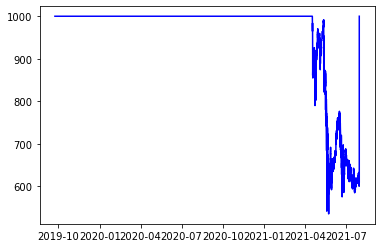

In [122]:
plt.plot(df.loc[len(train_predict)+(look_back*2)+1:,['Date']].values,df.loc[len(train_predict)+(look_back*2)+1:,['log_budget']].values,color='blue')

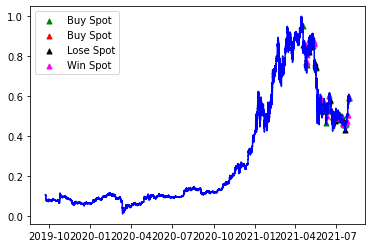

In [123]:
plt.plot(df.loc[len(train_predict)+(look_back*2)+1:,['Date']].values,df.loc[len(train_predict)+(look_back*2)+1:,['Close']].values,color='blue')
plt.scatter(df[len(train_predict)+(look_back*2)+1:].loc[df['Actual_act'] == 'Buy', 'Date']\
                .values,df[len(train_predict)+(look_back*2)+1:].loc[df['Actual_act'] == 'Buy','Close'].values\
                , label='Buy Spot', color='green', s=25, marker="^")
plt.scatter(df[len(train_predict)+(look_back*2)+1:].loc[df['Actual_act'] == 'Sell', 'Date']\
                .values,df[len(train_predict)+(look_back*2)+1:].loc[df['Actual_act'] == 'Sell','Close'].values\
                , label='Buy Spot', color='red', s=25, marker="^")
plt.scatter(df[len(train_predict)+(look_back*2)+1:].loc[df['Actual_act'] == 'Lose', 'Date']\
                .values,df[len(train_predict)+(look_back*2)+1:].loc[df['Actual_act'] == 'Lose','Close'].values\
                , label='Lose Spot', color='black', s=25, marker="^")
plt.scatter(df[len(train_predict)+(look_back*2)+1:].loc[df['Actual_act'] == 'Win', 'Date']\
                .values,df[len(train_predict)+(look_back*2)+1:].loc[df['Actual_act'] == 'Win','Close'].values\
                , label='Win Spot', color='magenta', s=25, marker="^")
plt.legend()

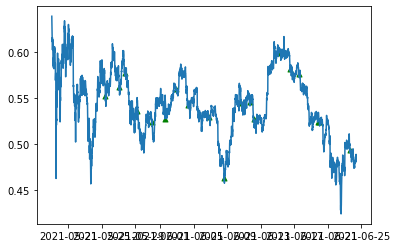

In [124]:
num = int(.9*len(df))
num_end = len(df)-int(.05*len(df))
plt.plot(df.loc[num:num_end,'Date'],df.loc[num:num_end,'Close'])
plt.scatter(df[num:num_end].loc[df['Actual_act'] == 'Buy', 'Date']\
                .values,df[num:num_end].loc[df['Actual_act'] == 'Buy','Close'].values\
                , label='Buy Spot', color='green', s=25, marker="^")
plt.scatter(df[num:num_end].loc[df['Actual_act'] == 'Sell', 'Date']\
                .values,df[num:num_end].loc[df['Actual_act'] == 'Sell','Close'].values\
                , label='Buy Spot', color='red', s=25, marker="^")


In [125]:
#df.to_csv('Result_25_50_BTC_2020_2021_15m_spread_3_patterned_10epochs.csv',index=False)

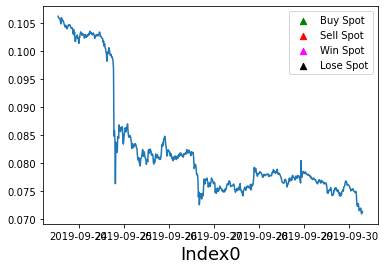

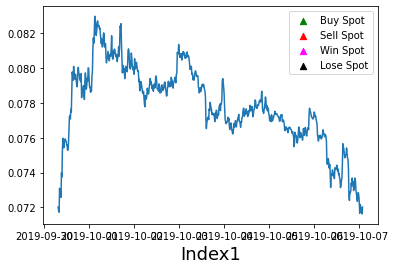

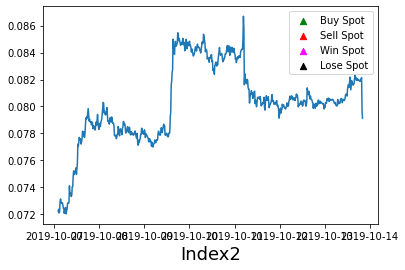

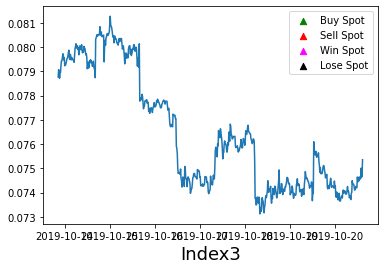

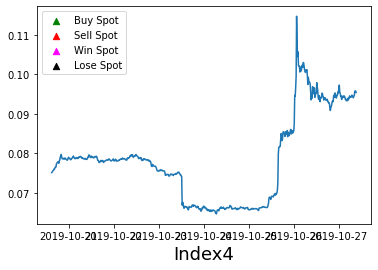

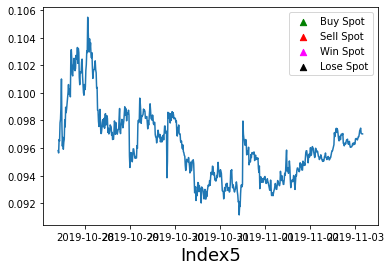

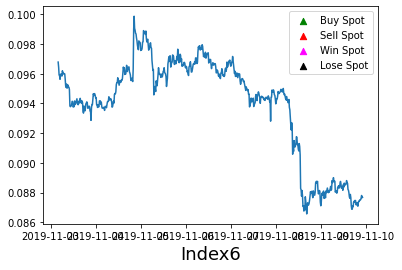

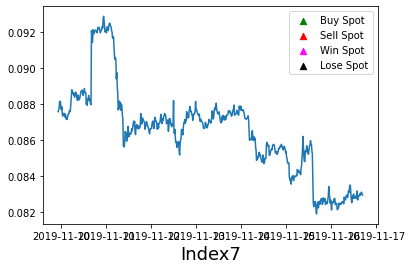

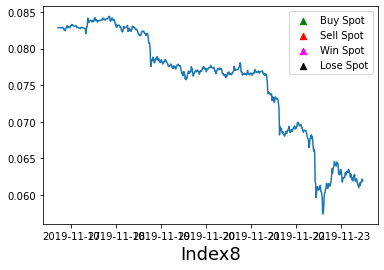

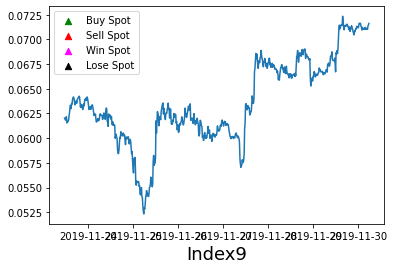

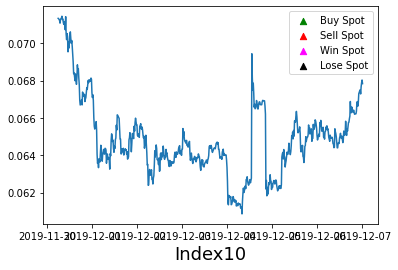

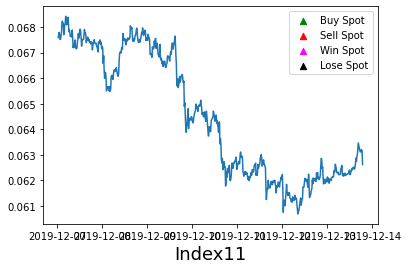

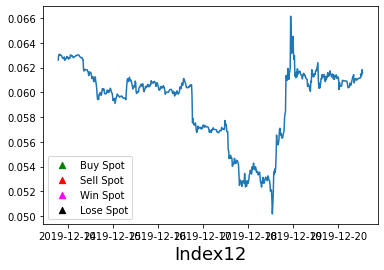

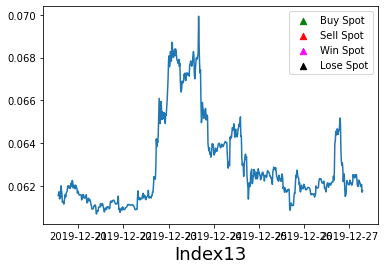

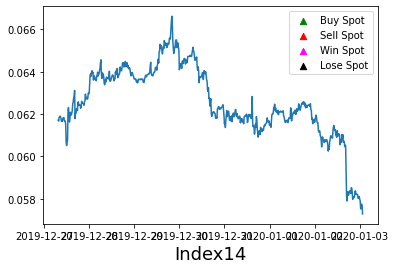

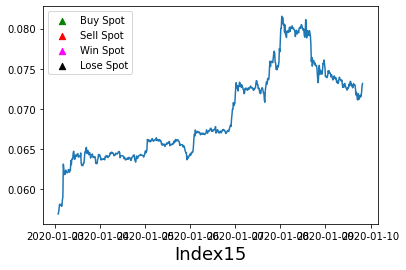

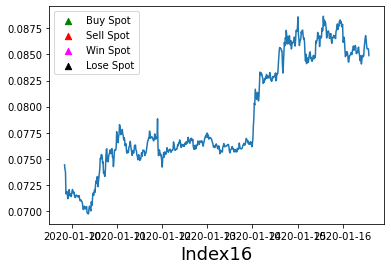

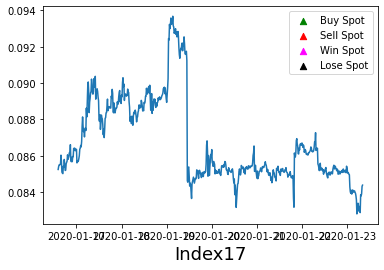

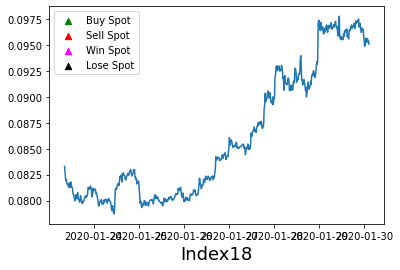

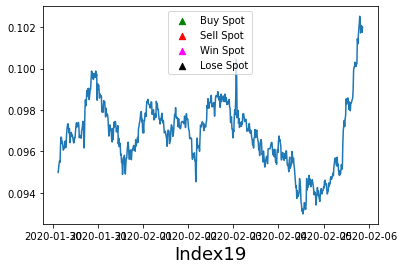

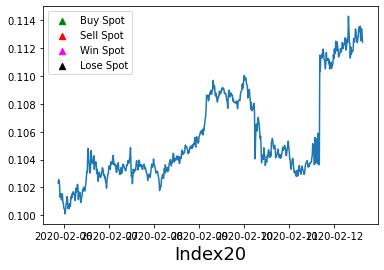

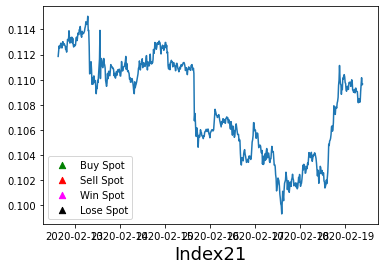

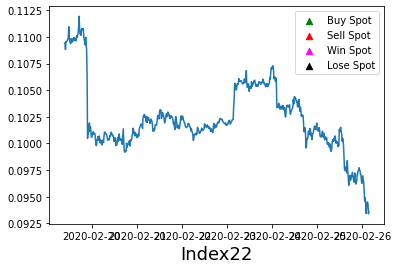

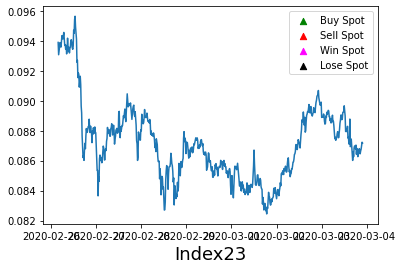

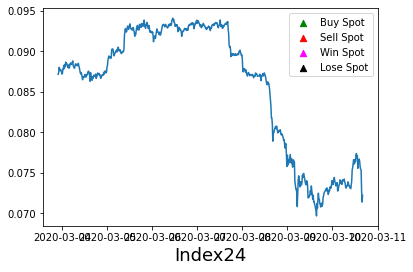

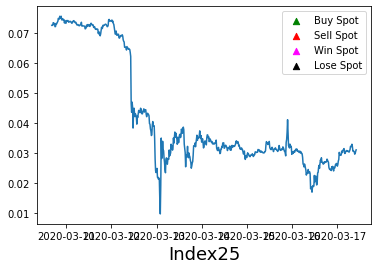

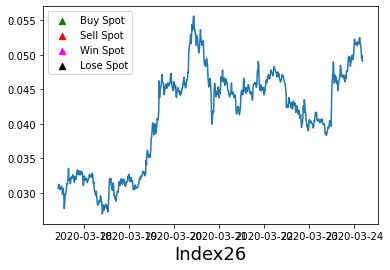

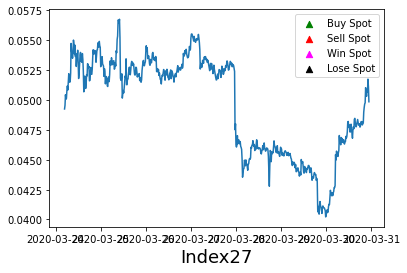

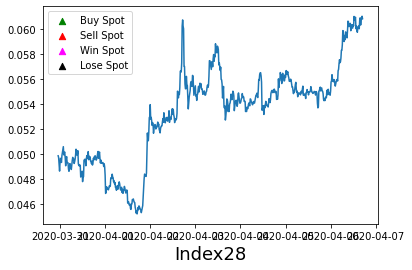

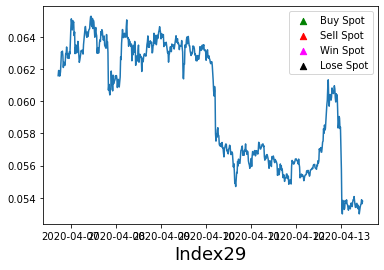

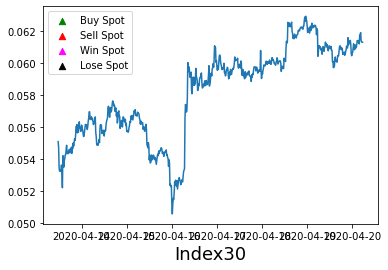

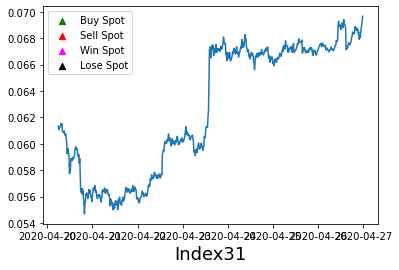

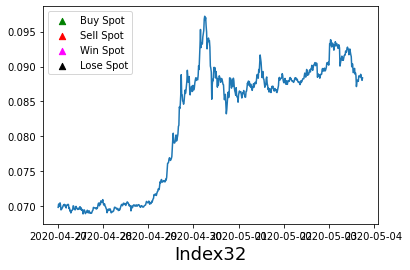

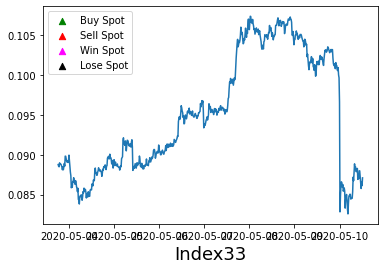

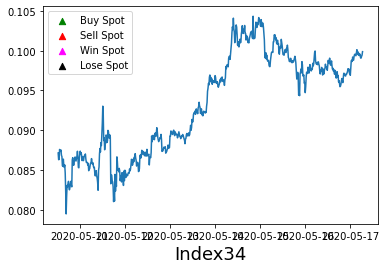

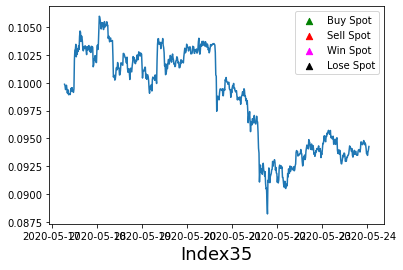

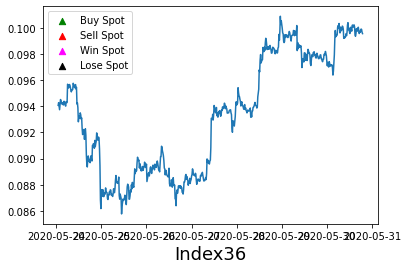

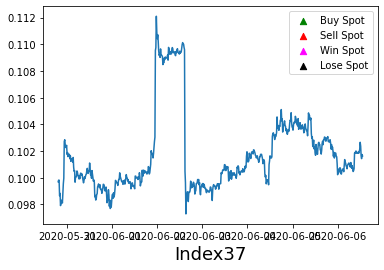

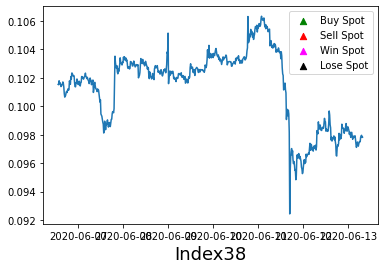

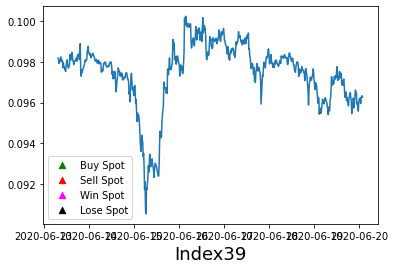

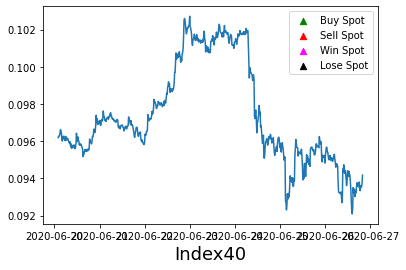

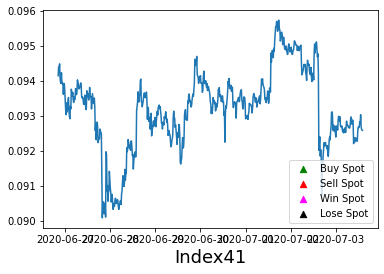

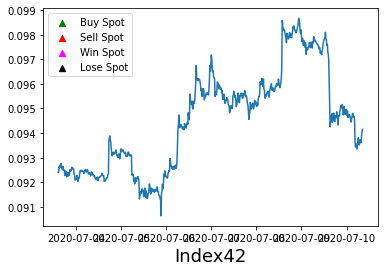

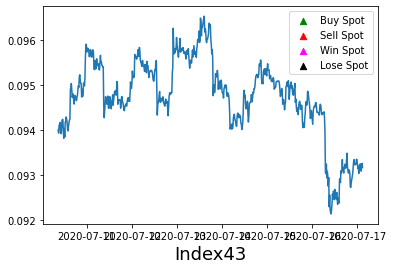

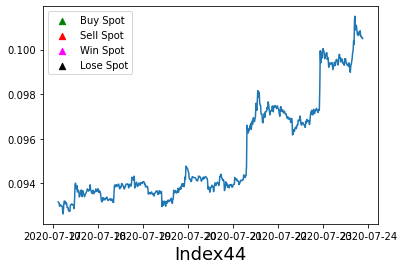

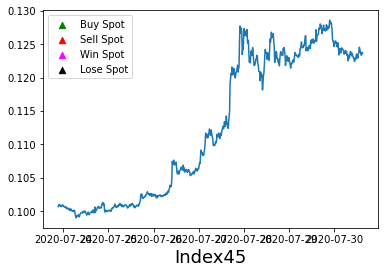

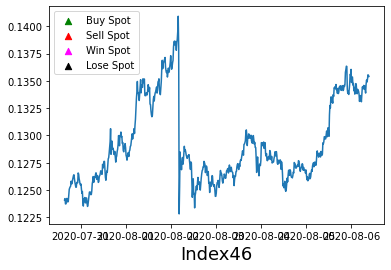

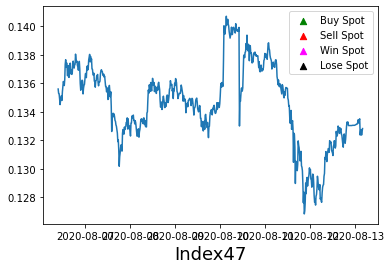

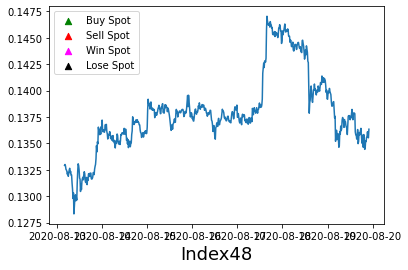

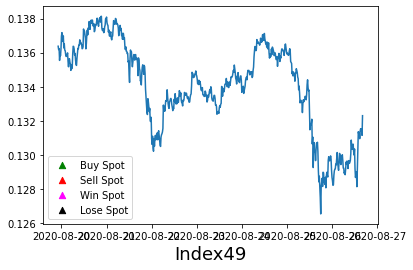

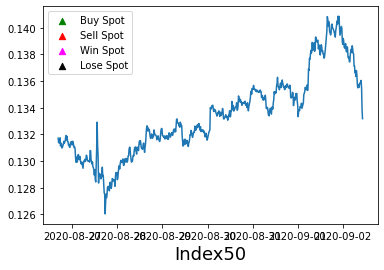

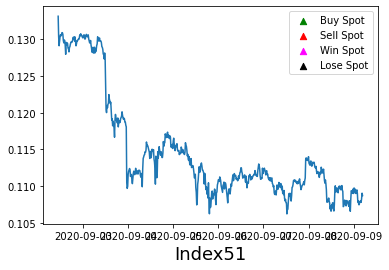

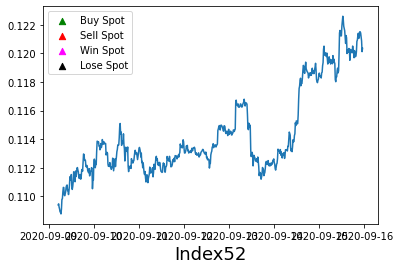

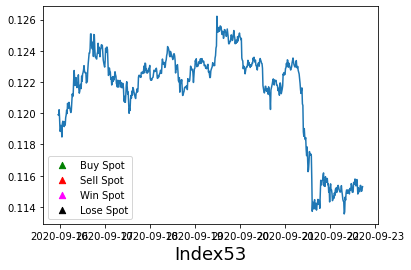

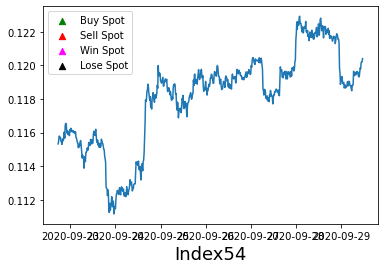

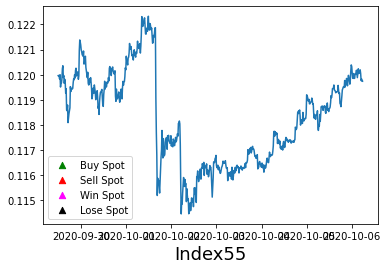

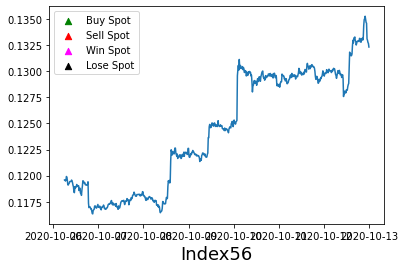

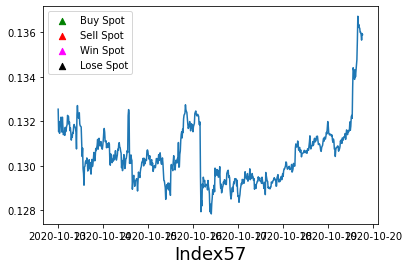

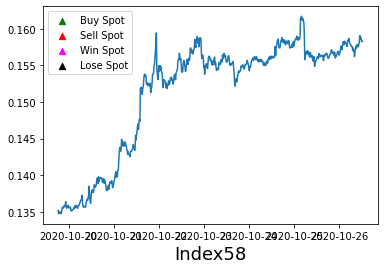

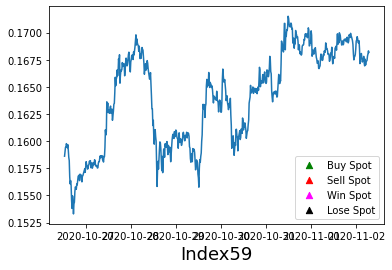

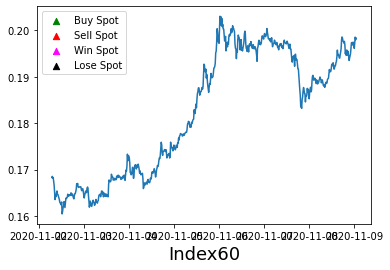

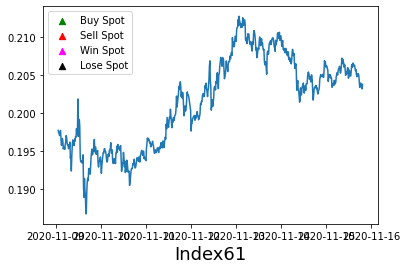

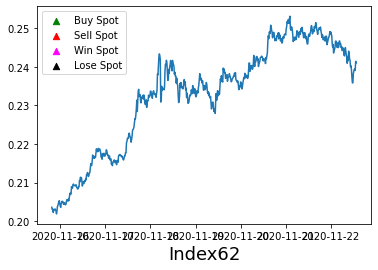

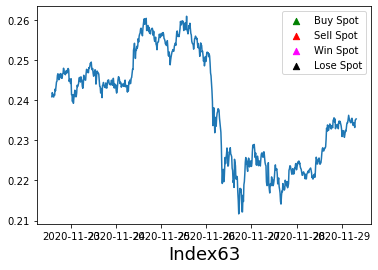

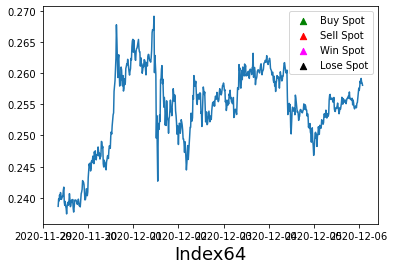

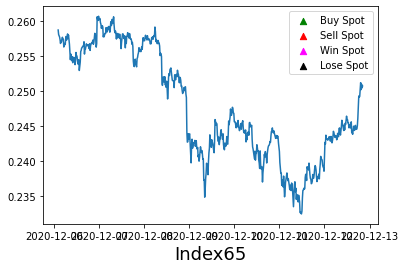

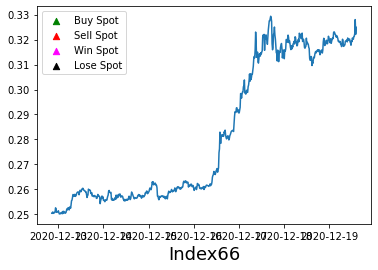

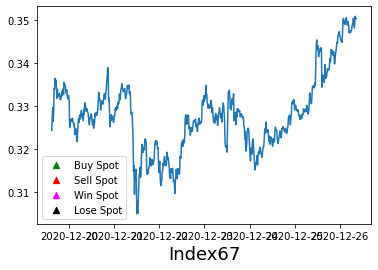

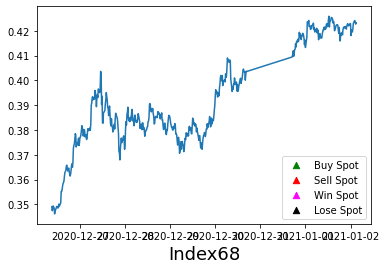

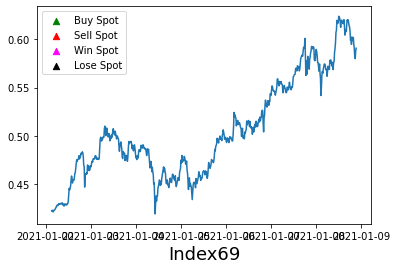

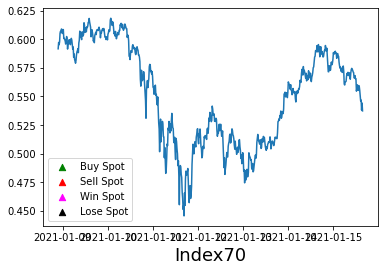

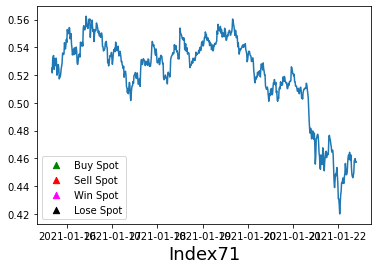

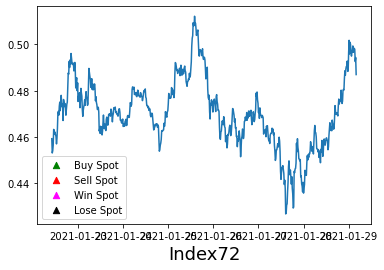

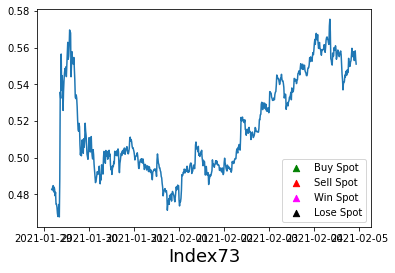

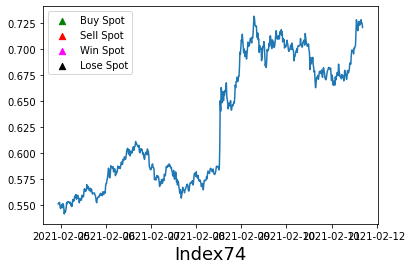

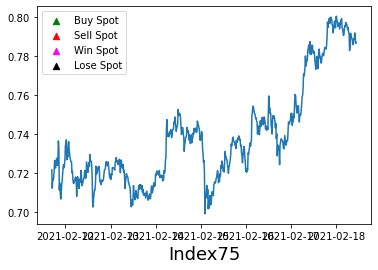

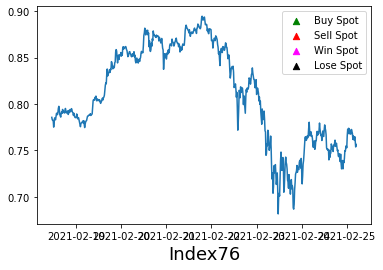

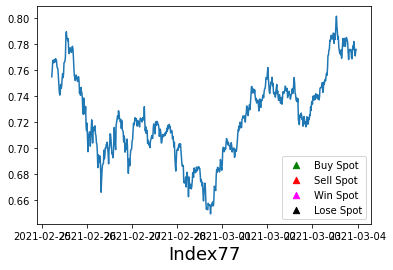

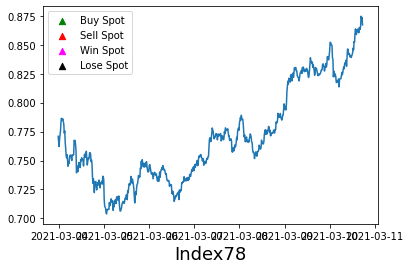

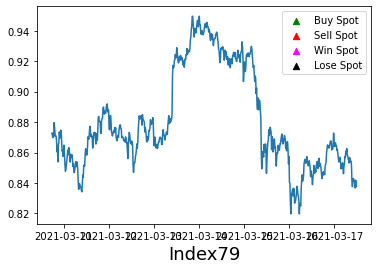

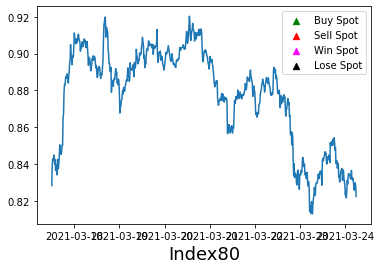

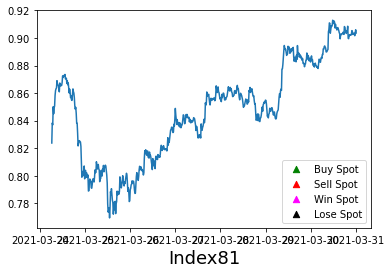

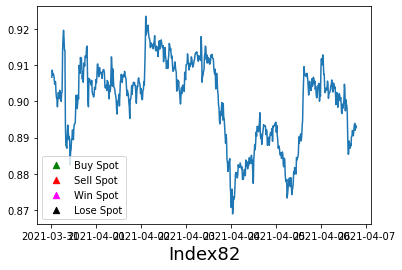

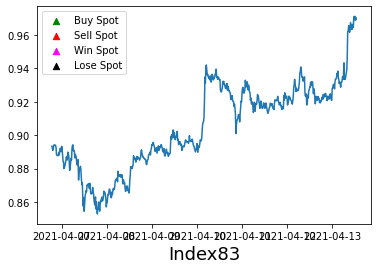

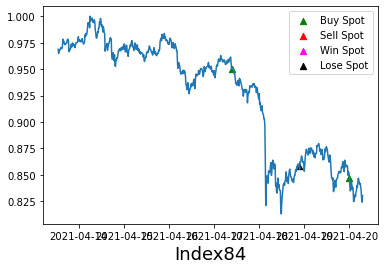

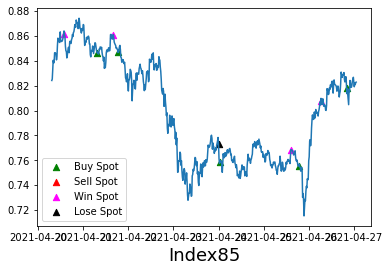

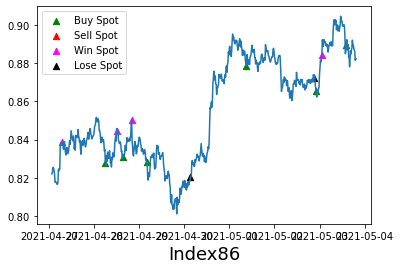

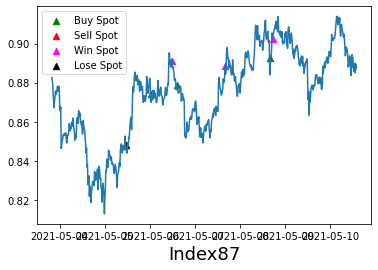

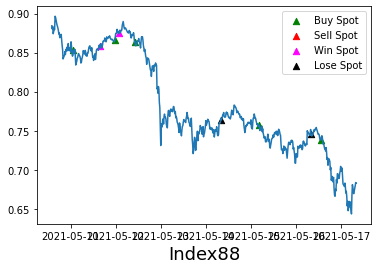

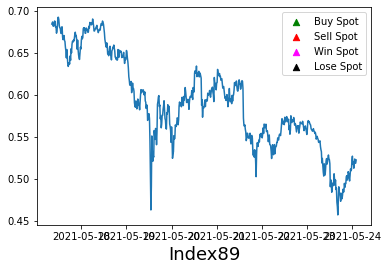

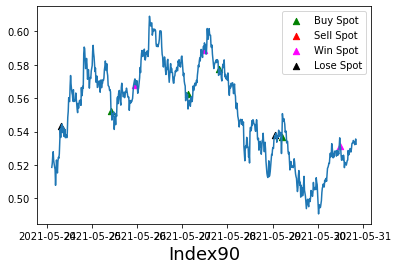

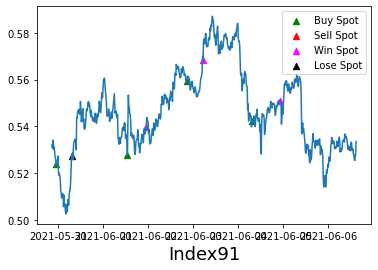

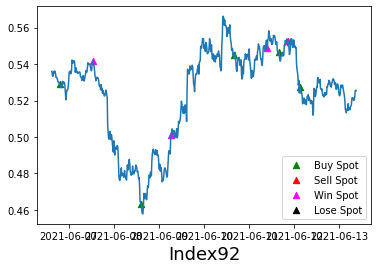

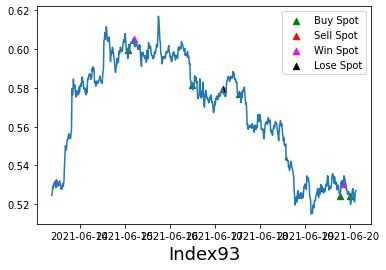

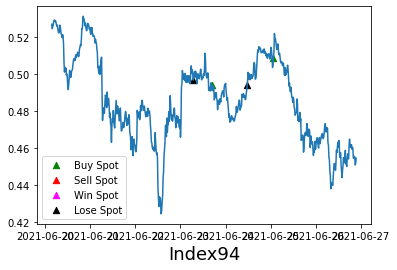

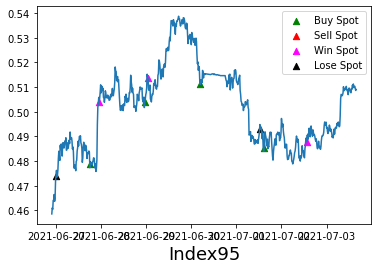

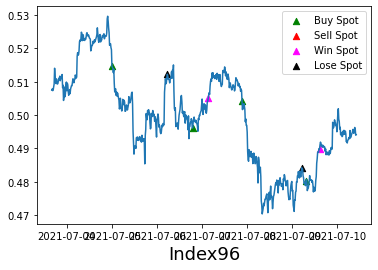

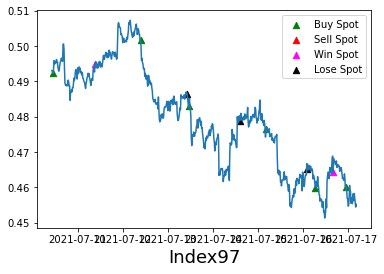

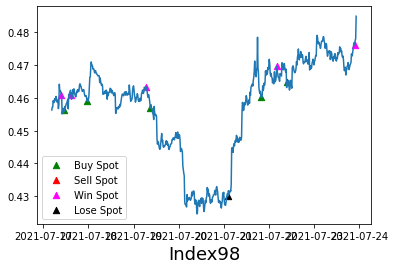

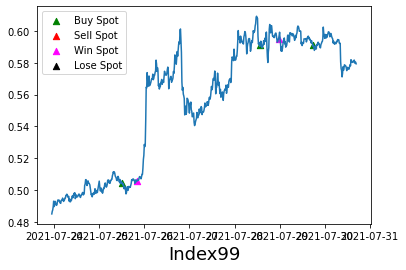

In [126]:
df_to_display = df[len(train_predict)+(look_back*2)+1:]
visualizeProportion(df_to_display,100,'Date','Close','Actual_act','Buy','Sell',100,False)